# Metadata analysis

This notebook explores the results from the K-Means clustering, and analyzes the static metadata.

## Imports

## Extract metadata patterns after clustering

In [105]:
readings_job_events_df = dd.from_delayed(dfs_job_events)
jobs_metadata = readings_job_events_df[readings_job_events_df["job ID"].isin(readings_task_usage_df.index)].groupby(["job ID", "user", "logical job name"])["scheduling class"].mean().compute().reset_index()


In [106]:
jobs_metadata

job ID                                          user  \
0         3418309  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=   
1         3418329  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=   
2         3418334  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=   
3         6590391  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=   
4         6933059  y1zb4shvaJurgBq+U8Ba9lm6r6qffGJOHPOT+2c7Zzo=   
...           ...                                           ...   
64916  6486577243  ZHAzkawqKRJLjH0vstw83yLYltCctQ0DZEmZvQgnTvM=   
64917  6486605021  E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=   
64918  6486606105  fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=   
64919  6486612710  HxdST/yDI1TlIkr0Povf9KaXGGG8x4iVXX6o/iSIghM=   
64920  6486624675  E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=   

                                   logical job name  scheduling class  
0      wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=               3.0  
1      OEeQsaVr4kdGHFwQ2liQlDZ18529HEMmu6B6/3K1cBA=               3.0  
2      ys6VJLz4Tz6SJxZJ7kwAZgxPgWnQAQiGIRIMcjOfU7I=               3.0  
3      vC+1PemZ9kW3YJxS35HJ9gcZr4aQT8gNPfxSHMgWtCI=               3.0  
4      kqlDH32nrvZtVtGK3OnoDal/dufv6yjUf+1AEzhjVdA=               2.0  
...                                             ...               ...  
64916  oHQYViMUeNEojiW9p3u0Vdt8N4KBASt2eODnyJhwSSo=               1.0  
64917  /Yf4VkGD9oVfi6mNB00U40K21Df8/zfyy5H+zWh7174=               1.0  
64918  pybQctecHPUbE1LLvMa9IKw0xyz8v2Vj434xHWKdF18=               0.0  
64919  YI5372ouHbbTv6b594D2bDWC283uv6QcuE41Mst3BFk=               0.0  
64920  b0avj5Nlg7emhHKQuwX03WzHiPKiSkbyHawj8FyPu28=               1.0  

[64921 rows x 4 columns]

In [108]:
jobs_metadata["scheduling class"].value_counts()

0.0    24281
1.0    21288
2.0    18866
3.0      486
Name: scheduling class, dtype: int64

In [114]:
cols_task_events = df_schema[df_schema['file pattern'] == 'task_events/part-?????-of-?????.csv.gz'].content.values
task_events_files = [os.path.join(data_path, 'task_events','part-00'+ str(v).zfill(3)+'-of-00500.csv.gz')
                        for v in range(0, 500)]

dfs_task_events = [delayed(pd.read_csv)(fn, header=None, index_col=False, names=cols_task_events, delimiter=',') for fn in
           task_events_files]
readings_task_events_df = dd.from_delayed(dfs_task_events)
readings_task_events_df = readings_task_events_df[readings_task_events_df['job ID'].isin(readings_task_usage_df.index)].groupby(["job ID"])["priority", "CPU request", "memory request", "disk space request", "different machines restriction"].mean().compute().reset_index()

In [115]:
readings_task_events_df 

job ID  priority  CPU request  memory request  disk space request  \
0         3418309       9.0     0.125000        0.074460            0.000424   
1         3418329       9.0     0.125000        0.099240            0.001049   
2         3418334       9.0     0.062500        0.094850            0.000494   
3         6590391       9.0     0.053571        0.094886            0.000493   
4         6933059      10.0     0.080137        0.047274            0.000154   
...           ...       ...          ...             ...                 ...   
64916  6486577243       0.0     0.062500        0.012440            0.000019   
64917  6486605021       1.0     0.015620        0.015530            0.000038   
64918  6486606105       4.0     0.024990        0.033390            0.000386   
64919  6486612710       4.0     0.012500        0.022280            0.000386   
64920  6486624675       1.0     0.015620        0.015530            0.000038   

       different machines restriction  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  
...                               ...  
64916                             0.0  
64917                             0.0  
64918                             1.0  
64919                             0.0  
64920                             0.0  

[64921 rows x 6 columns]

**TODO**: Do one-hot encoding
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
- https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970


In [805]:
def extract_quartiles(df: pd.DataFrame, column: str):
    q25_val = df[column].quantile(0.25)
    median_val = df[column].median()
    q75_val = df[column].quantile(0.75)
    max_val = df[column].max()
    df[column+" - Q1"] = 0
    df[column+" - Q2"] = 0
    df[column+" - Q3"] = 0
    df[column+" - Q4"] = 0
    df.loc[df[column] <=q25_val, f"{column} - Q1"] = 1
    df.loc[(q25_val < df[column]) & (df[column] <=median_val) , f"{column} - Q2"] = 1
    df.loc[(median_val < df[column]) & (df[column] <=q75_val) , f"{column} - Q3"] = 1
    df.loc[(q75_val < df[column]) & (df[column] <=max_val) , f"{column} - Q4"] = 1
    df.loc[df[column] <=q25_val, f"{column} - Quartiles"] = 'Q1'
    df.loc[(q25_val < df[column]) & (df[column] <=median_val) , f"{column} - Quartiles"] = 'Q2'
    df.loc[(median_val < df[column]) & (df[column] <=q75_val) , f"{column} - Quartiles"] = 'Q3'
    df.loc[(q75_val < df[column]) & (df[column] <=max_val) , f"{column} - Quartiles"] = 'Q4'


In [322]:
def extract_priority(df: pd.DataFrame, column='priority'):
    df.loc[(0 <= df[column]) & (df[column] <= 1), 'priority labels'] = 'Free [0,1]'
    df.loc[(2 <= df[column]) & (df[column] <= 8) , 'priority labels'] = 'Other [2,8]'
    df.loc[(df[column] == 9) , 'priority labels'] = 'Production [9]'
    df.loc[(df[column] == 10), 'priority labels'] = 'Monitoring [10]'
    df.loc[(df[column] == 11), 'priority labels'] = 'Infrastructure [11]'

In [911]:
extract_quartiles(readings_task_events_df, "disk space request")

In [912]:
extract_quartiles(readings_task_events_df, "memory request")

In [913]:
extract_quartiles(readings_task_events_df, "CPU request")

In [914]:
extract_priority(readings_task_events_df)

In [915]:
readings_task_events_df

job ID  priority  CPU request  memory request  disk space request  \
0         3418309       9.0     0.125000        0.074460            0.000424   
1         3418329       9.0     0.125000        0.099240            0.001049   
2         3418334       9.0     0.062500        0.094850            0.000494   
3         6590391       9.0     0.053571        0.094886            0.000493   
4         6933059      10.0     0.080137        0.047274            0.000154   
...           ...       ...          ...             ...                 ...   
64916  6486577243       0.0     0.062500        0.012440            0.000019   
64917  6486605021       1.0     0.015620        0.015530            0.000038   
64918  6486606105       4.0     0.024990        0.033390            0.000386   
64919  6486612710       4.0     0.012500        0.022280            0.000386   
64920  6486624675       1.0     0.015620        0.015530            0.000038   

       different machines restriction  disk space request - Q1  \
0                                 0.0                        0   
1                                 0.0                        0   
2                                 0.0                        0   
3                                 0.0                        0   
4                                 0.0                        0   
...                               ...                      ...   
64916                             0.0                        0   
64917                             0.0                        0   
64918                             1.0                        0   
64919                             0.0                        0   
64920                             0.0                        0   

       disk space request - Q2  disk space request - Q3  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
64916                        1                        0   
64917                        1                        0   
64918                        0                        0   
64919                        0                        0   
64920                        1                        0   

       disk space request - Q4  ...  memory request - Q3  memory request - Q4  \
0                            1  ...                    0                    1   
1                            1  ...                    0                    1   
2                            1  ...                    0                    1   
3                            1  ...                    0                    1   
4                            1  ...                    0                    1   
...                        ...  ...                  ...                  ...   
64916                        0  ...                    1                    0   
64917                        0  ...                    1                    0   
64918                        1  ...                    0                    1   
64919                        1  ...                    0                    1   
64920                        0  ...                    1                    0   

       CPU request - Q1  CPU request - Q2  CPU request - Q3  CPU request - Q4  \
0                     0                 0                 0                 1   
1                     0                 0                 0                 1   
2                     0                 0                 0                 1   
3                     0                 0                 0                 1   
4                     0                 0                 0                 1   
...                 ...               ...               ...               ...   
64916   

In [916]:
static_metrics["CPU request - Quartiles"] = readings_task_events_df["CPU request - Quartiles"]
static_metrics["CPU request - Q1"] = readings_task_events_df["CPU request - Q1"]
static_metrics["CPU request - Q2"] = readings_task_events_df["CPU request - Q2"]
static_metrics["CPU request - Q3"] = readings_task_events_df["CPU request - Q3"]
static_metrics["CPU request - Q4"] = readings_task_events_df["CPU request - Q4"]

static_metrics["memory request - Quartiles"] = readings_task_events_df["memory request - Quartiles"]
static_metrics["memory request - Q1"] = readings_task_events_df["memory request - Q1"]
static_metrics["memory request - Q2"] = readings_task_events_df["memory request - Q2"]
static_metrics["memory request - Q3"] = readings_task_events_df["memory request - Q3"]
static_metrics["memory request - Q4"] = readings_task_events_df["memory request - Q4"]

static_metrics["disk space request - Quartiles"] = readings_task_events_df["disk space request - Quartiles"]
static_metrics["disk space request - Q1"] = readings_task_events_df["disk space request - Q1"]
static_metrics["disk space request - Q2"] = readings_task_events_df["disk space request - Q2"]
static_metrics["disk space request - Q3"] = readings_task_events_df["disk space request - Q3"]
static_metrics["disk space request - Q4"] = readings_task_events_df["disk space request - Q4"]



In [917]:
readings_task_events_df_final = readings_task_events_df.drop(columns=['CPU request', 'memory request', 'disk space request'])

In [918]:
static_metrics = readings_task_events_df_final.set_index("job ID").join(jobs_metadata.set_index('job ID'))

In [919]:
static_metrics['priority'] = static_metrics['priority'].astype(int)
static_metrics['different machines restriction'] = static_metrics['different machines restriction'].astype(int)
static_metrics['scheduling class'] = static_metrics['scheduling class'].astype(int)

In [920]:
static_metrics

priority  different machines restriction  disk space request - Q1  \
job ID                                                                          
3418309            9                               0                        0   
3418329            9                               0                        0   
3418334            9                               0                        0   
6590391            9                               0                        0   
6933059           10                               0                        0   
...              ...                             ...                      ...   
6486577243         0                               0                        0   
6486605021         1                               0                        0   
6486606105         4                               1                        0   
6486612710         4                               0                        0   
6486624675         1                               0                        0   

            disk space request - Q2  disk space request - Q3  \
job ID                                                         
3418309                           0                        0   
3418329                           0                        0   
3418334                           0                        0   
6590391                           0                        0   
6933059                           0                        0   
...                             ...                      ...   
6486577243                        1                        0   
6486605021                        1                        0   
6486606105                        0                        0   
6486612710                        0                        0   
6486624675                        1                        0   

            disk space request - Q4  memory request - Q1  memory request - Q2  \
job ID                                                                          
3418309                           1                    0                    0   
3418329                           1                    0                    0   
3418334                           1                    0                    0   
6590391                           1                    0                    0   
6933059                           1                    0                    0   
...                             ...                  ...                  ...   
6486577243                        0                    0                    0   
6486605021                        0                    0                    0   
6486606105                        1                    0                    0   
6486612710                        1                    0                    0   
6486624675                        0                    0                    0   

            memory request - Q3  memory request - Q4  ...  CPU request - Q2  \
job ID                                                ...                     
3418309                       0                    1  ...                 0   
3418329                       0                    1  ...                 0   
3418334                       0                    1  ...                 0   
6590391                       0                    1  ...                 0   
6933059                       0                    1  ...                 0   
...                         ...                  ...  ...               ...   
6486577243                    1                    0  ...                 0   
6486605021                    1                    0  ...                 0   
6486606105                    0                    1  ...                 0   
6486612710                    0                    1  ...                 1   
6486624675                    1                    0  ...                 0   

            CPU request - Q3  CPU request -

In [214]:
static_metrics["user"].value_counts().sort_values(ascending=False).head(3)

r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=    9788
68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4=    7151
F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=    4001
Name: user, dtype: int64

In [217]:
static_metrics[(cluster_labels_2 == 0) & (static_metrics['user'] == "F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=")]['user'].value_counts()

F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c=    3993
Name: user, dtype: int64

In [219]:
len(set(static_metrics[(cluster_labels_2 == 0)]['user']).intersection(set(static_metrics[(cluster_labels_2 == 1)]['user'])))

86

In [222]:
print(len(set(static_metrics[(cluster_labels_2 == 0)]['user'])), len(set(static_metrics[(cluster_labels_2 == 1)]['user'])))

472 146


In [223]:
len(set(static_metrics[(cluster_labels_2 == 0)]['logical job name']).intersection(set(static_metrics[(cluster_labels_2 == 1)]['logical job name'])))

53

In [224]:
print(len(set(static_metrics[(cluster_labels_2 == 0)]['logical job name'])), len(set(static_metrics[(cluster_labels_2 == 1)]['logical job name'])))

10871 303


## K-Means

### K-Means = 2

#### Frequency distribution of users

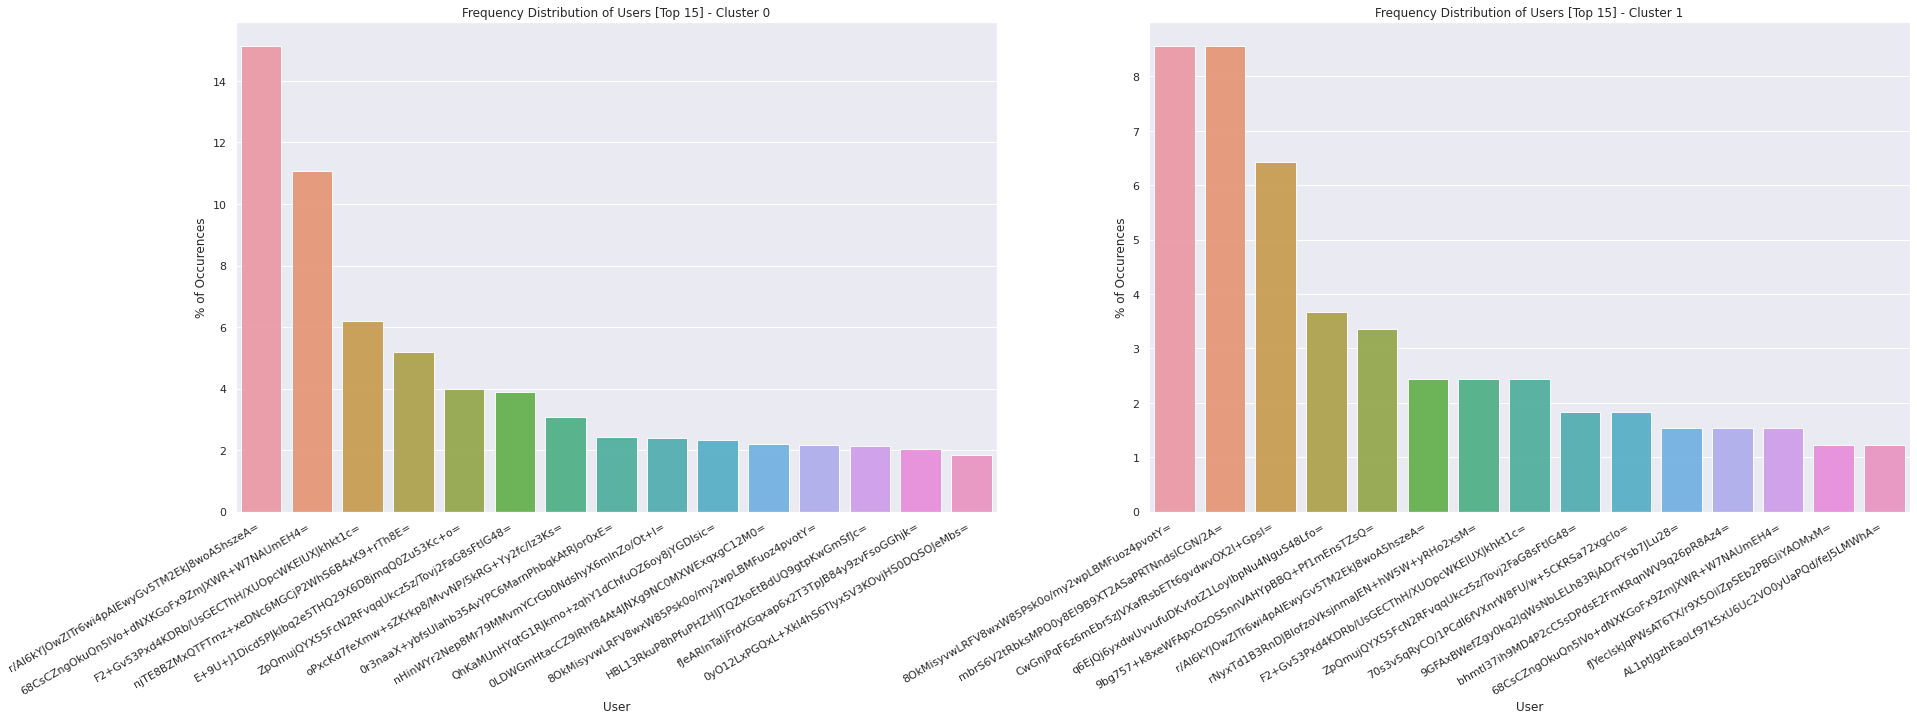

In [195]:
top_x=15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 9)
axes = [ax1, ax2]
for i in sorted(list(set(cluster_labels_2))):
    column_count = static_metrics[cluster_labels_2 == i]["user"].value_counts().head(top_x)
    sns.set(style="darkgrid")
    sns.barplot(column_count.index, column_count.values / len(static_metrics[cluster_labels_2 == i]) * 100, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
    axes[i].set_ylabel('% of Occurences', fontsize=12)
    axes[i].set_xlabel('User', fontsize=12)
    axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

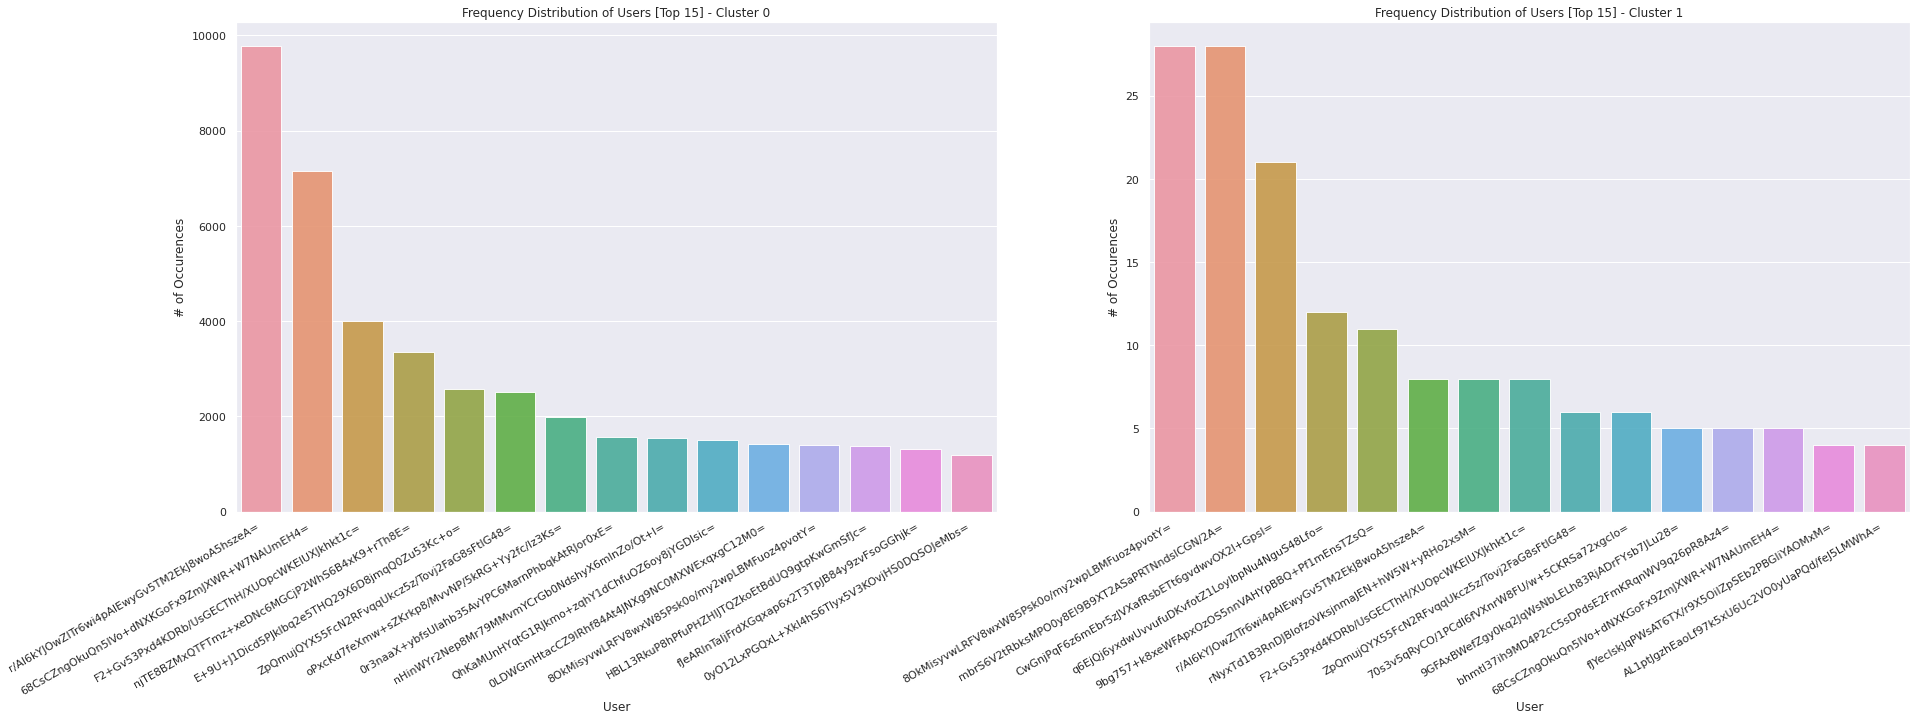

In [211]:
top_x=15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 9)
axes = [ax1, ax2]
for i in sorted(list(set(cluster_labels_2))):
    column_count = static_metrics[cluster_labels_2 == i]["user"].value_counts().head(top_x)
    sns.set(style="darkgrid")
    sns.barplot(column_count.index, column_count.values, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
    axes[i].set_ylabel('# of Occurences', fontsize=12)
    axes[i].set_xlabel('User', fontsize=12)
    axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

##### User intersection

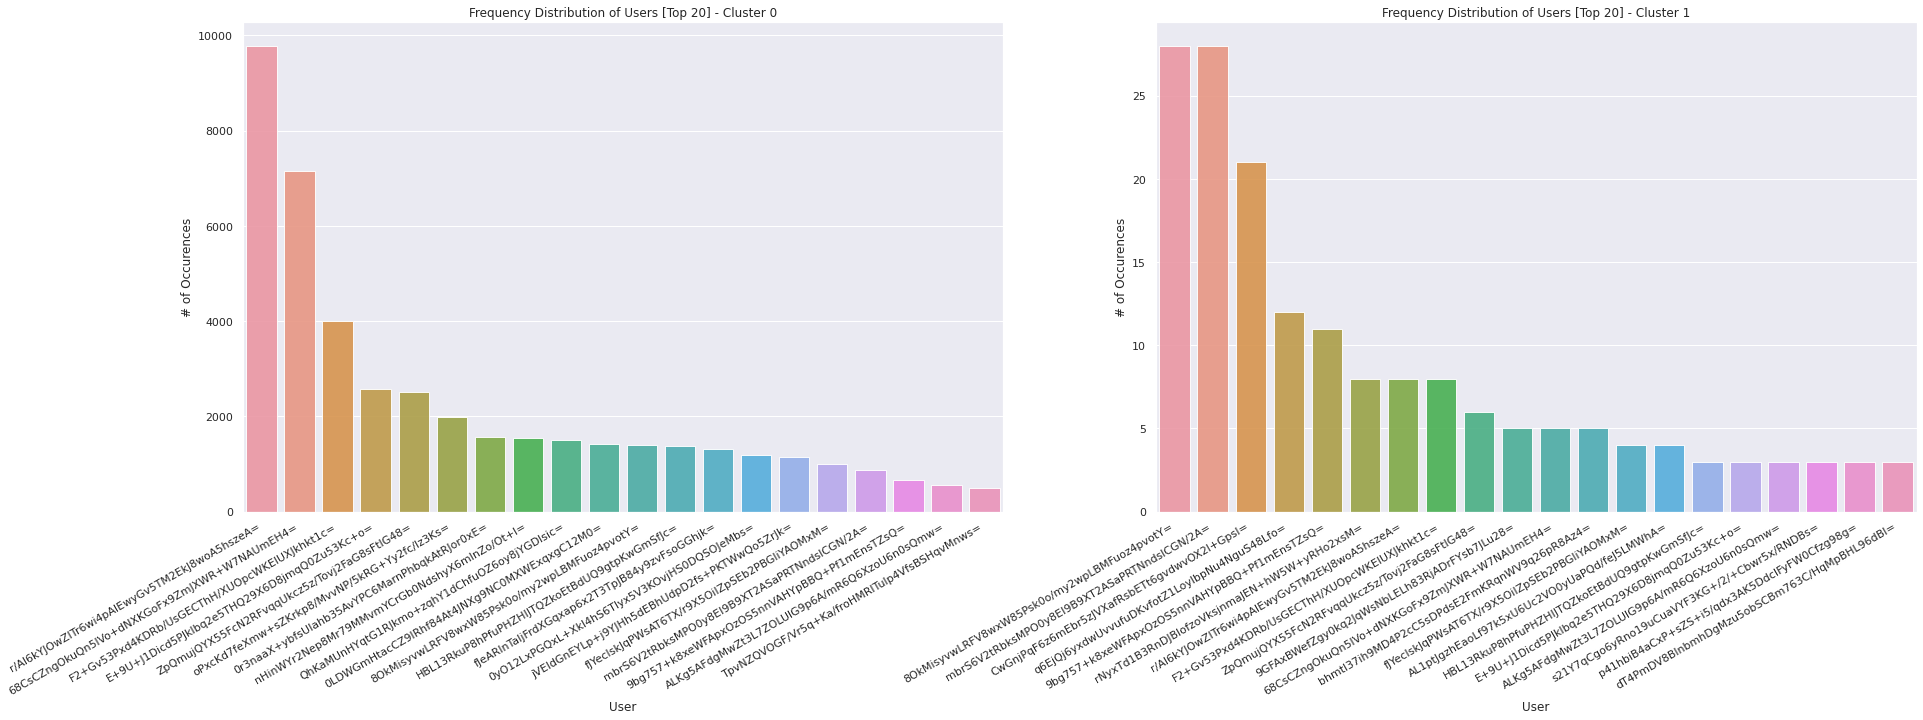

In [225]:
intersecting_users = set(static_metrics[(cluster_labels_2 == 0)]['user']).intersection(set(static_metrics[(cluster_labels_2 == 1)]['user']))
top_x=20
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 9)
axes = [ax1, ax2]
for i in sorted(list(set(cluster_labels_2))):
    column_count = static_metrics[(cluster_labels_2 == i) & (static_metrics['user'].isin(intersecting_users))]["user"].value_counts().head(top_x)
    sns.set(style="darkgrid")
    sns.barplot(column_count.index, column_count.values, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
    axes[i].set_ylabel('# of Occurences', fontsize=12)
    axes[i].set_xlabel('User', fontsize=12)
    axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

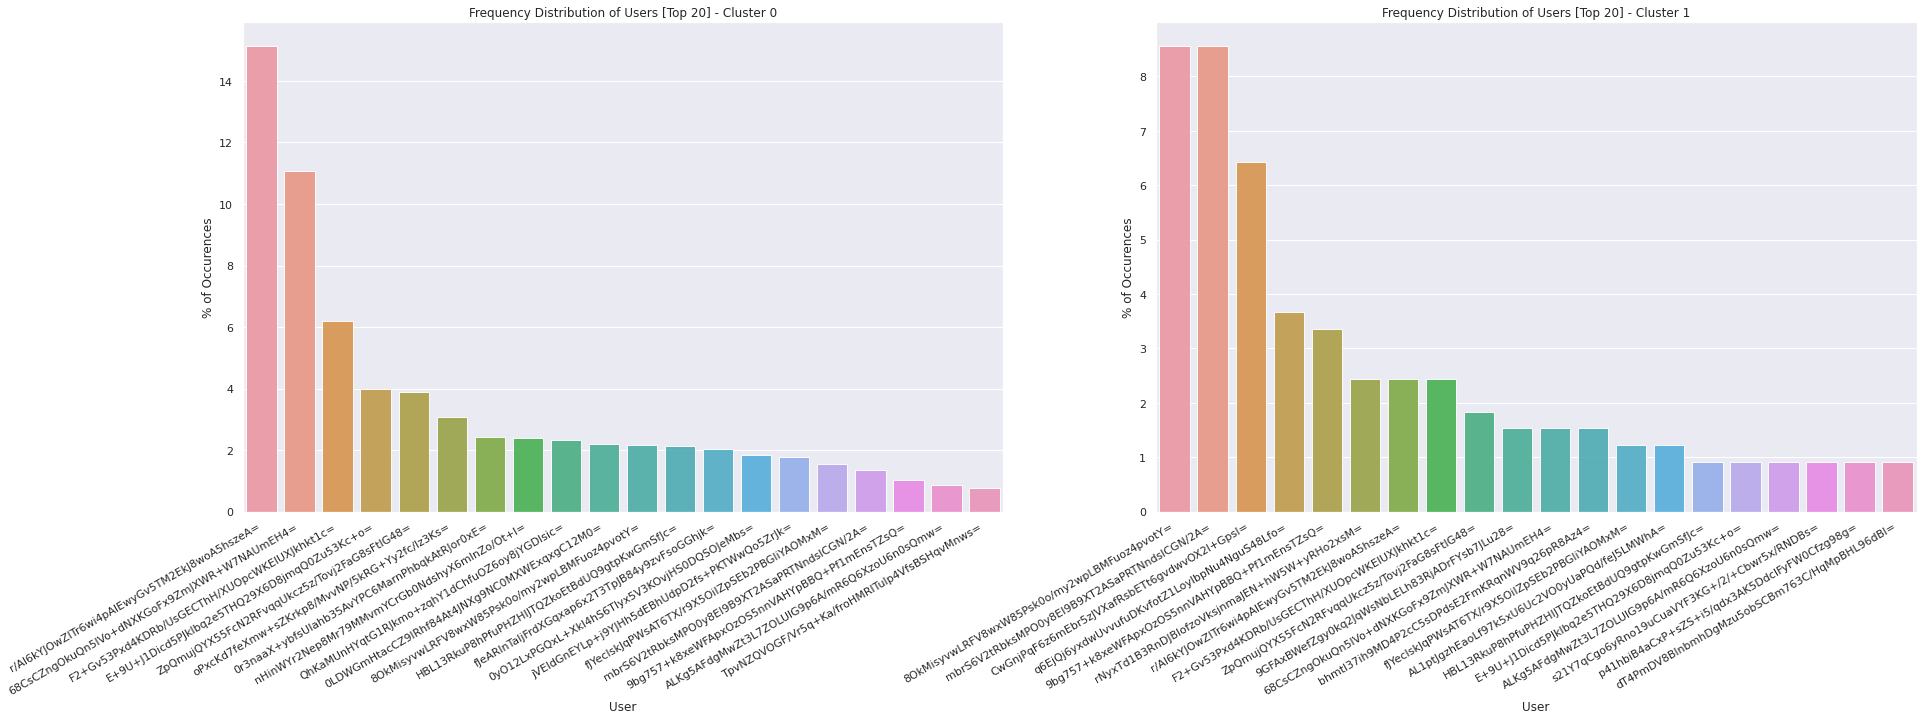

In [227]:
intersecting_users = set(static_metrics[(cluster_labels_2 == 0)]['user']).intersection(set(static_metrics[(cluster_labels_2 == 1)]['user']))
top_x=20
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 9)
axes = [ax1, ax2]
for i in sorted(list(set(cluster_labels_2))):
    column_count = static_metrics[(cluster_labels_2 == i) & (static_metrics['user'].isin(intersecting_users))]["user"].value_counts().head(top_x)
    sns.set(style="darkgrid")
    sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels_2 == i]) * 100, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
    axes[i].set_ylabel('% of Occurences', fontsize=12)
    axes[i].set_xlabel('User', fontsize=12)
    axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

##### Top 10 users in cluster 0 vs their freq in cluster 1

([<matplotlib.axis.XTick at 0x7fd8f9b61970>,
 [Text(0, 0, 'r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA='),
  Text(1, 0, '68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4='),
  Text(2, 0, 'F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c='),
  Text(3, 0, 'njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E='),
  Text(4, 0, 'E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o='),
  Text(5, 0, 'ZpQmujQYX55FcN2RFvqqUkcz5z/Tovj2FaG8sFtlG48='),
  Text(6, 0, 'oPxcKd7feXmw+sZKrkp8/MvvNP/5kRG+Yy2fc/lz3Ks='),
  Text(7, 0, '0r3naaX+ybfsUIahb35AvYPC6MarnPhbqkAtRJor0xE='),
  Text(8, 0, 'nHinWYr2Nep8Mr79MMvmYCrGb0NdshyX6mlnZo/Ot+I='),
  Text(9, 0, 'QhKaMUnHYqtG1RJkmo+zqhY1dChfuOZ6oy8jYGDlsic='),
  Text(10, 0, '0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWExqxgC12M0='),
  Text(11, 0, '8OkMisyvwLRFV8wxW85Psk0o/my2wpLBMFuoz4pvotY='),
  Text(12, 0, 'HBL13RkuP8hPfuPHZHIJTQZkoEtBdUQ9gtpKwGmSfJc='),
  Text(13, 0, 'fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk='),
  Text(14, 0, '0yO12LxPGQxL+XkI4hS6Tlyx5V3KOvjHS0DQSOJeMbs=')])

<Figure size 2160x648 with 0 Axes>

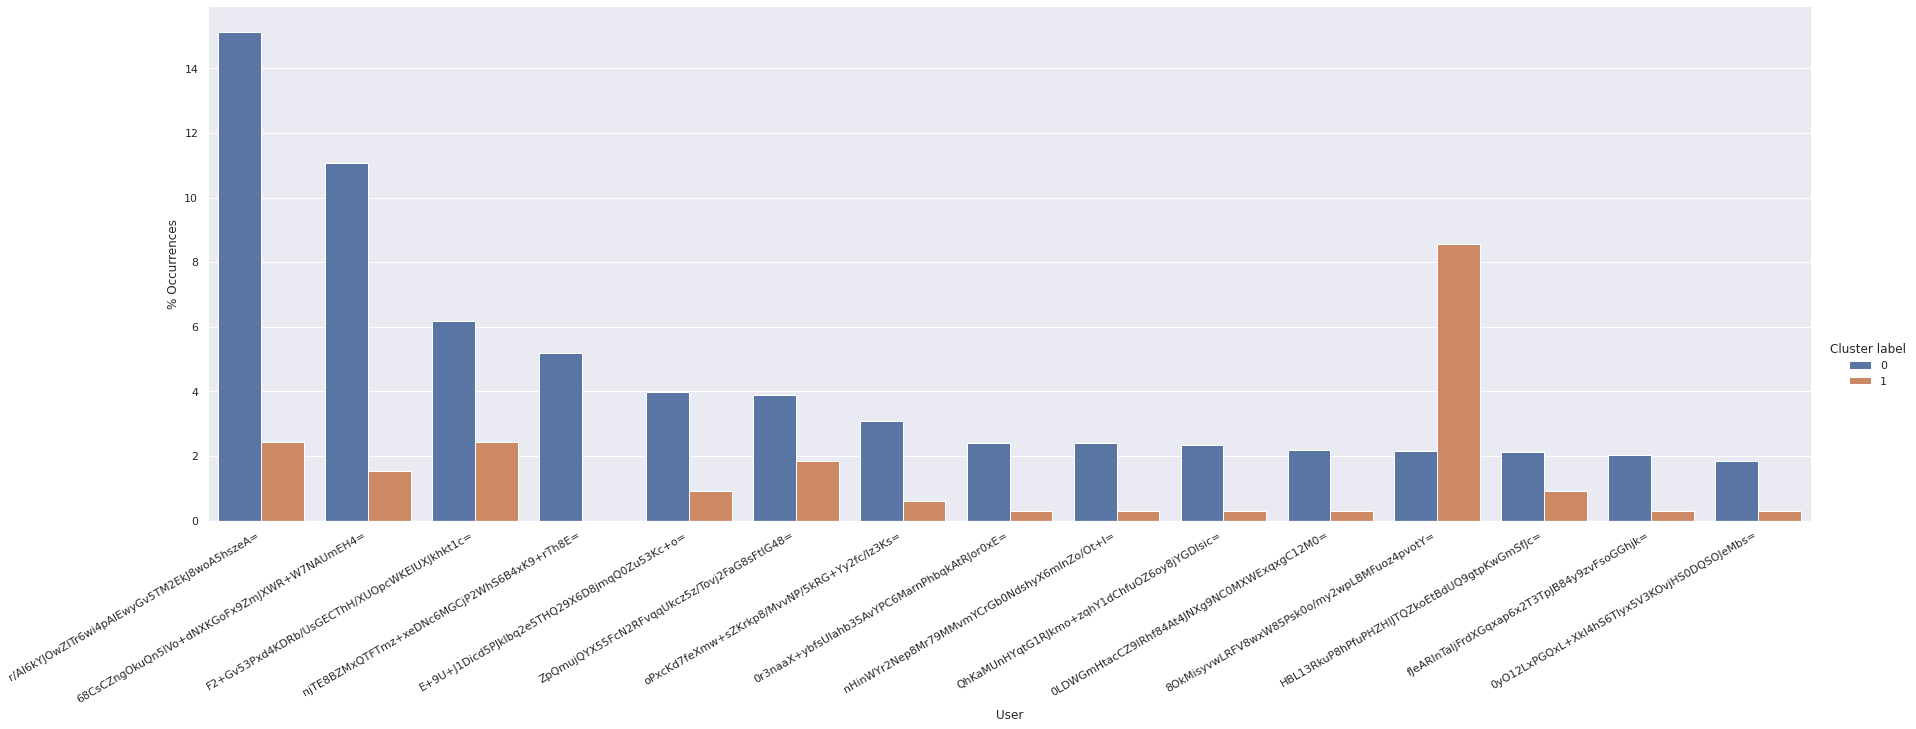

In [291]:
top_15_users_cluster_0 = static_metrics[(cluster_labels_2 == 0)]['user'].value_counts().head(15).index.values

column_count_0 = static_metrics[(cluster_labels_2 == 0) & (static_metrics['user'].isin(top_15_users_cluster_0))]["user"].value_counts().values
column_count_1 = []
for user in top_15_users_cluster_0:
    val = 0
    val_return = static_metrics[(cluster_labels_2 == 1) & (static_metrics['user'] == user)]["user"].value_counts().values
    if len(val_return) > 0:
        val = val_return[0]
    column_count_1.append(val)
                                                                                                                
values = [
    (np.array(column_count_0)  / len(static_metrics[cluster_labels_2 == 0]) * 100),
     (np.array(column_count_1)  / len(static_metrics[cluster_labels_2 == 1]) * 100)
]

final_data_0 =[el for el in zip(top_15_users_cluster_0, values[0], [0]*len(column_count_0))]
final_data_1 =[el for el in zip(top_15_users_cluster_0, values[1], [1]*len(column_count_1))]

df_cl_0 = pd.DataFrame(final_data_0, columns=["User", "% Occurrences", "Cluster label"])
df_cl_1 = pd.DataFrame(final_data_1, columns=["User", "% Occurrences", "Cluster label"])

df_top_cl_0 = pd.concat([df_cl_0, df_cl_1], ignore_index=True)

plt.figure(figsize=(30, 9))
sns.set(style="darkgrid")
sns.catplot(x='User', y="% Occurrences", hue="Cluster label", data=df_top_cl_0, kind='bar', height=8, aspect=3)

#print(values)
#plt.figure(figsize=(15,9))
#
#sns.barplot(range(len(top_15_users_cluster_0)),values , alpha=0.9)
#plt.title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
#plt.ylabel('% of Occurences', fontsize=12)
#plt.xlabel('User', fontsize=12)
plt.xticks(ticks=range(len(top_15_users_cluster_0)), labels=top_15_users_cluster_0, rotation=30, horizontalalignment='right')

##### Top 10 users in cluster 1 vs their freq in cluster 0

([<matplotlib.axis.XTick at 0x7fd73bd39730>,
 [Text(0, 0, '8OkMisyvwLRFV8wxW85Psk0o/my2wpLBMFuoz4pvotY='),
  Text(1, 0, 'mbrS6V2tRbksMPO0y8EI9B9XT2ASaPRTNndslCGN/2A='),
  Text(2, 0, 'CwGnjPqF6z6mEbr5zJVXafRsbETt6gvdwvOX2l+GpsI='),
  Text(3, 0, 'q6EjQj6yxdwUvvufuDKvfotZ1LoylbpNu4NguS48Lfo='),
  Text(4, 0, '9bg757+k8xeWFApxOzOS5nnVAHYpBBQ+Pf1mEnsTZsQ='),
  Text(5, 0, 'r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA='),
  Text(6, 0, 'rNyxTd1B3RnDJBIofzoVksjnmaJEN+hW5W+yRHo2xsM='),
  Text(7, 0, 'F2+Gv53Pxd4KDRb/UsGECThH/XUOpcWKElUXJkhkt1c='),
  Text(8, 0, 'ZpQmujQYX55FcN2RFvqqUkcz5z/Tovj2FaG8sFtlG48='),
  Text(9, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo='),
  Text(10, 0, '9GFAxBWefZgy0kq2JqWsNbLELh83RjADrFYsb7JLu28='),
  Text(11, 0, 'bhmtl37ih9MD4P2cC5sDPdsE2FmKRqnWV9q26pR8Az4='),
  Text(12, 0, '68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4='),
  Text(13, 0, 'fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM='),
  Text(14, 0, 'AL1ptJgzhEaoLf97k5xU6Uc2VO0yUaPQd/feJ5LMWhA=')])

<Figure size 2160x648 with 0 Axes>

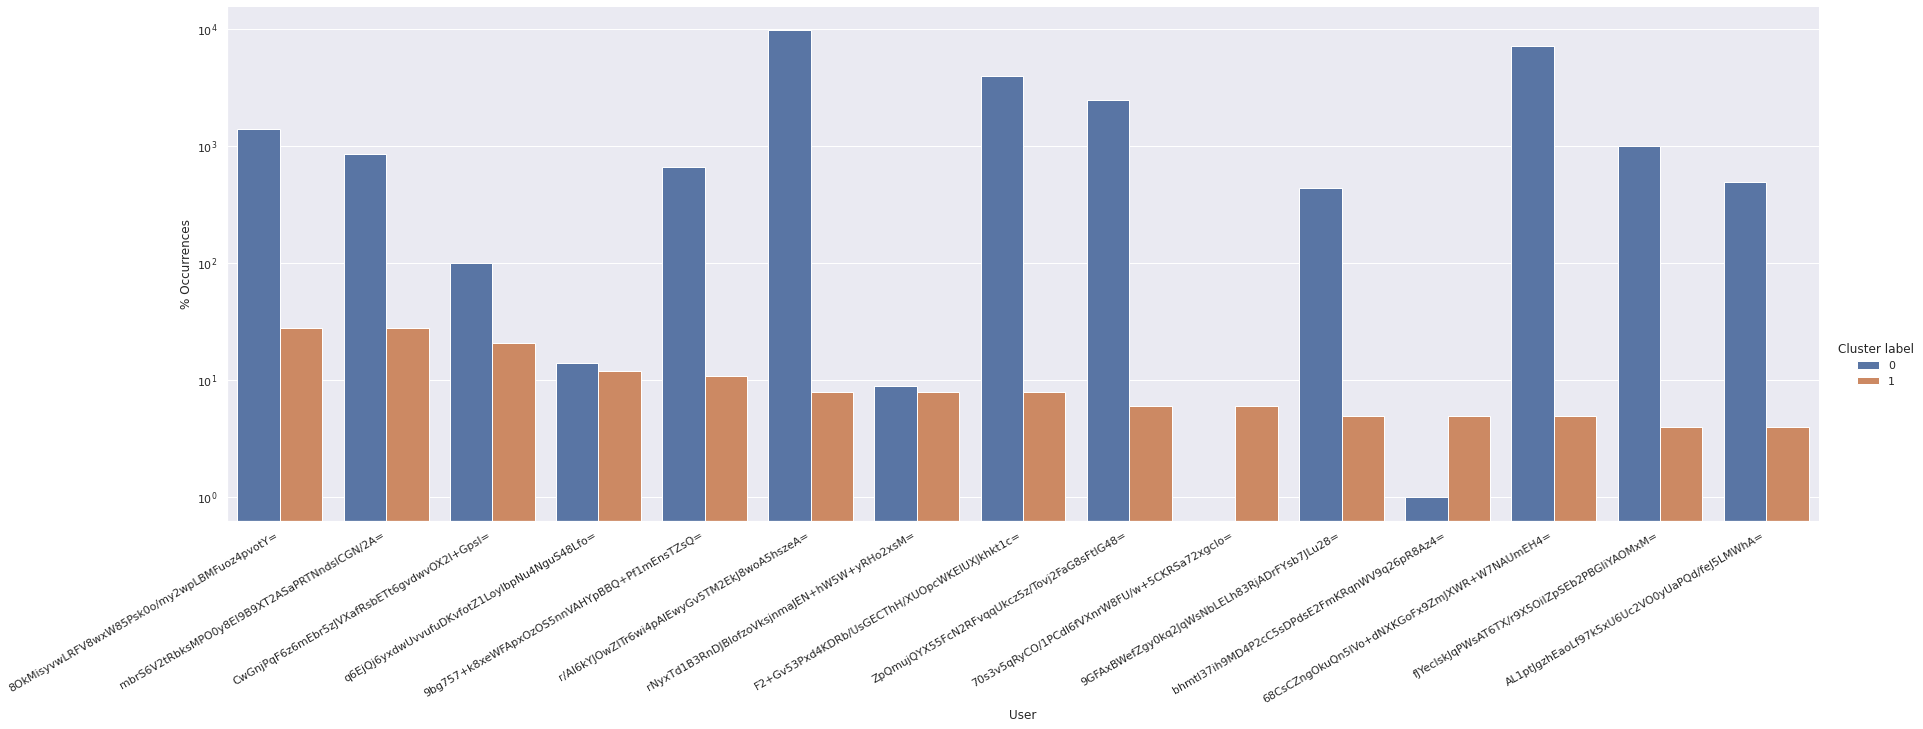

In [454]:
top_15_users_cluster_1 = static_metrics[(cluster_labels_2 == 1)]['user'].value_counts().head(15).index.values

column_count_1 = static_metrics[(cluster_labels_2 == 1) & (static_metrics['user'].isin(top_15_users_cluster_1))]["user"].value_counts().values
column_count_0 = []
for user in top_15_users_cluster_1:
    val = 0
    val_return = static_metrics[(cluster_labels_2 == 0) & (static_metrics['user'] == user)]["user"].value_counts().values
    if len(val_return) > 0:
        val = val_return[0]
    column_count_0.append(val)
                                                                                                                
values = [
    (np.array(column_count_0)), #/ len(static_metrics[cluster_labels_2 == 0]) * 100),  
     (np.array(column_count_1)) # / len(static_metrics[cluster_labels_2 == 1]) * 100)
]

final_data_0 =[el for el in zip(top_15_users_cluster_1, values[0], [0]*len(column_count_0))]
final_data_1 =[el for el in zip(top_15_users_cluster_1, values[1], [1]*len(column_count_1))]

df_cl_0 = pd.DataFrame(final_data_0, columns=["User", "% Occurrences", "Cluster label"])
df_cl_1 = pd.DataFrame(final_data_1, columns=["User", "% Occurrences", "Cluster label"])

df_top_cl_0 = pd.concat([df_cl_0, df_cl_1], ignore_index=True)

plt.figure(figsize=(30, 9))
sns.set(style="darkgrid")
sns.catplot(x='User', y="% Occurrences", hue="Cluster label", data=df_top_cl_0, kind='bar', height=8, aspect=3)
plt.yscale('log')
#print(values)
#plt.figure(figsize=(15,9))
#
#sns.barplot(range(len(top_15_users_cluster_0)),values , alpha=0.9)
#plt.title(f'Frequency Distribution of Users [Top {top_x}] - Cluster {i}')
#plt.ylabel('% of Occurences', fontsize=12)
#plt.xlabel('User', fontsize=12)
plt.xticks(ticks=range(len(top_15_users_cluster_1)), labels=top_15_users_cluster_1, rotation=30, horizontalalignment='right')

#### Frequency distribution of unique jobs name

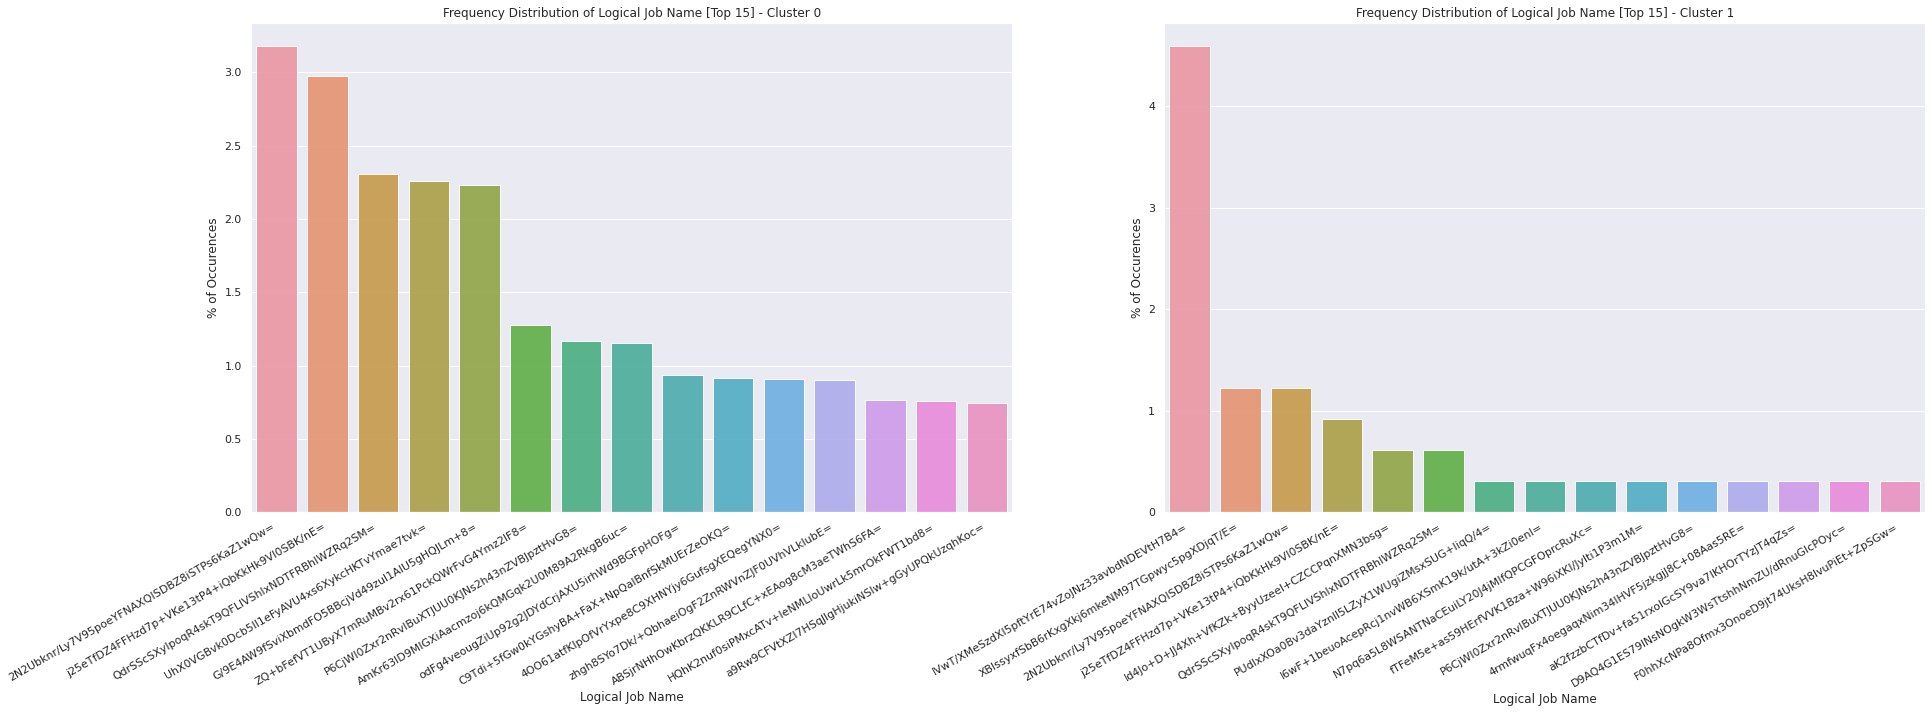

In [196]:
top_x=15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 9)
axes = [ax1, ax2]
for i in sorted(list(set(cluster_labels_2))):
    column_count = static_metrics[cluster_labels_2 == i]["logical job name"].value_counts().head(top_x)
    sns.set(style="darkgrid")
    sns.barplot(column_count.index, column_count.values / len(static_metrics[cluster_labels_2 == i]) * 100, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Frequency Distribution of Logical Job Name [Top {top_x}] - Cluster {i}')
    axes[i].set_ylabel('% of Occurences', fontsize=12)
    axes[i].set_xlabel('Logical Job Name', fontsize=12)
    axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

#### Frequency distribution of Priority, scheduling class and different machines restriction

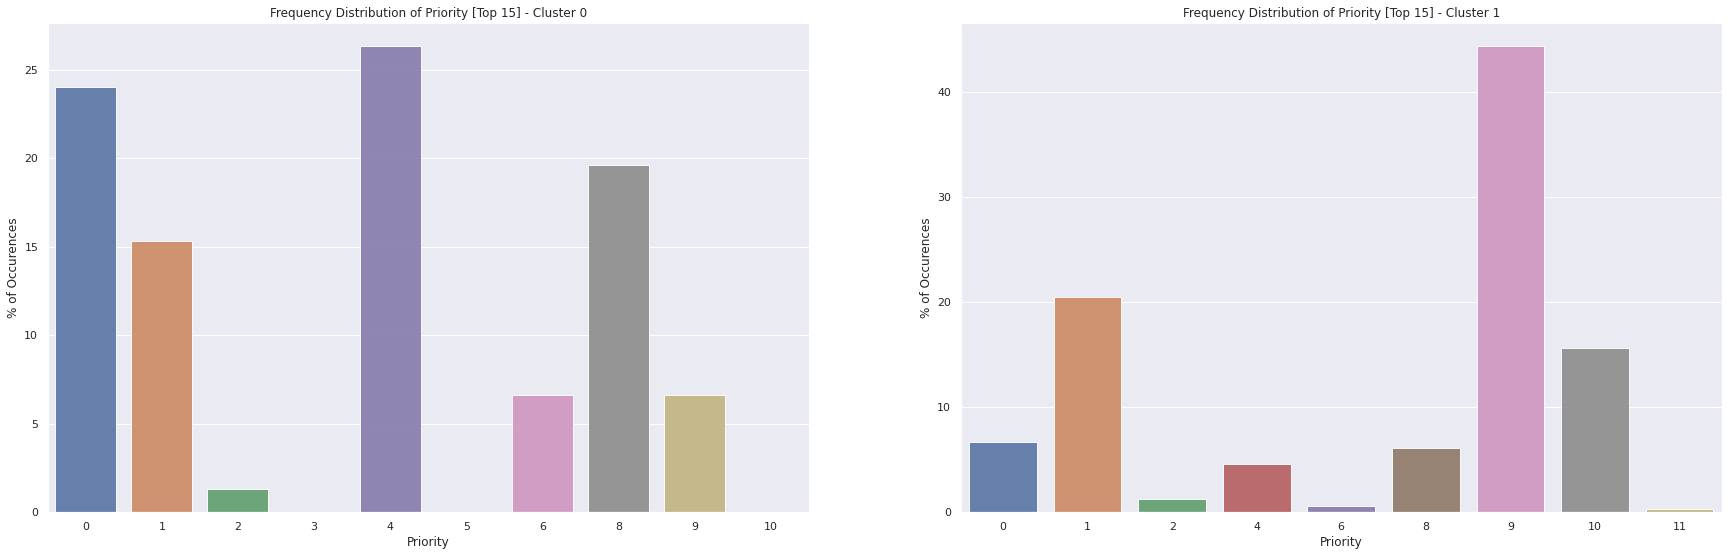

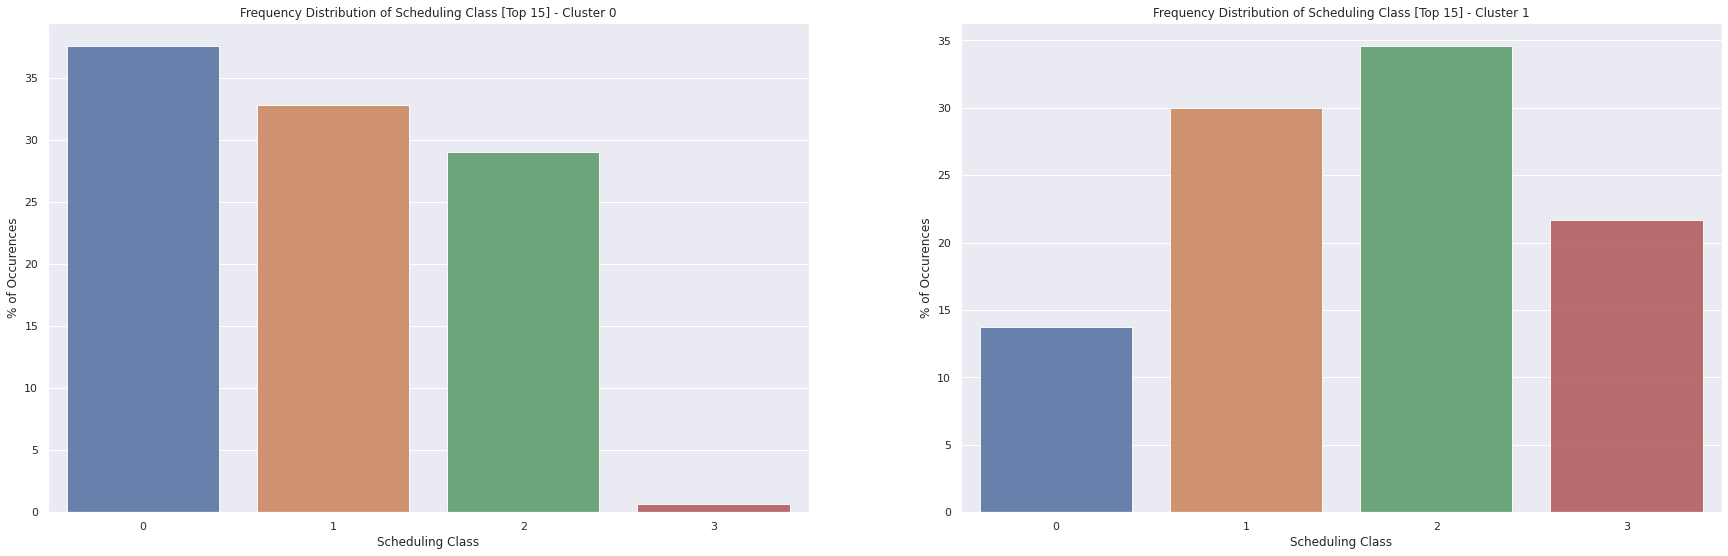

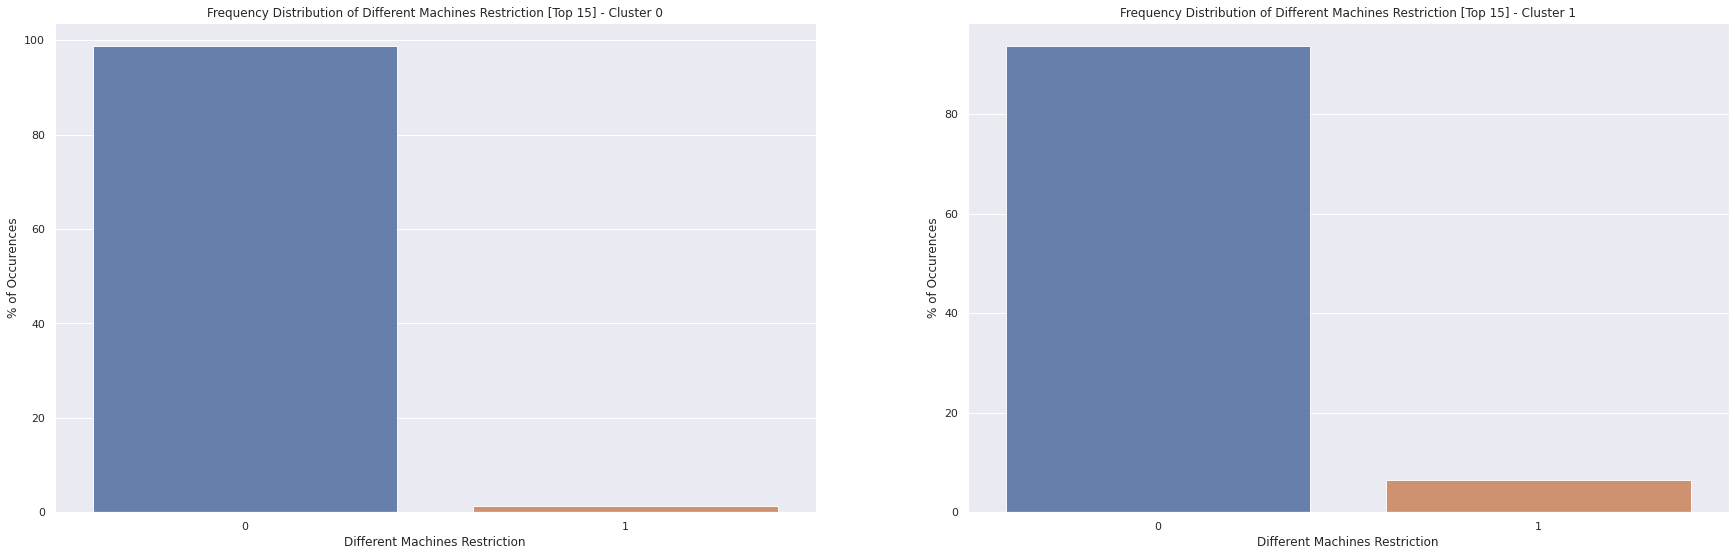

In [212]:
top_x=15
for label in ["priority", "scheduling class", "different machines restriction"]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes = [ax1, ax2]
    for i in sorted(list(set(cluster_labels_2))):
        column_count = static_metrics[cluster_labels_2 == i][label].value_counts().sort_values(ascending=False).head(top_x)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels_2 == i]) * 100, alpha=0.9, ax=axes[i])
        axes[i].set_title(f'Frequency Distribution of {label.title()} [Top {top_x}] - Cluster {i}')
        axes[i].set_ylabel('% of Occurences', fontsize=12)
        axes[i].set_xlabel(f'{label.title()}', fontsize=12)
        #axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

#### Frequency distribution of CPU, Memory, and Disk request quartiles

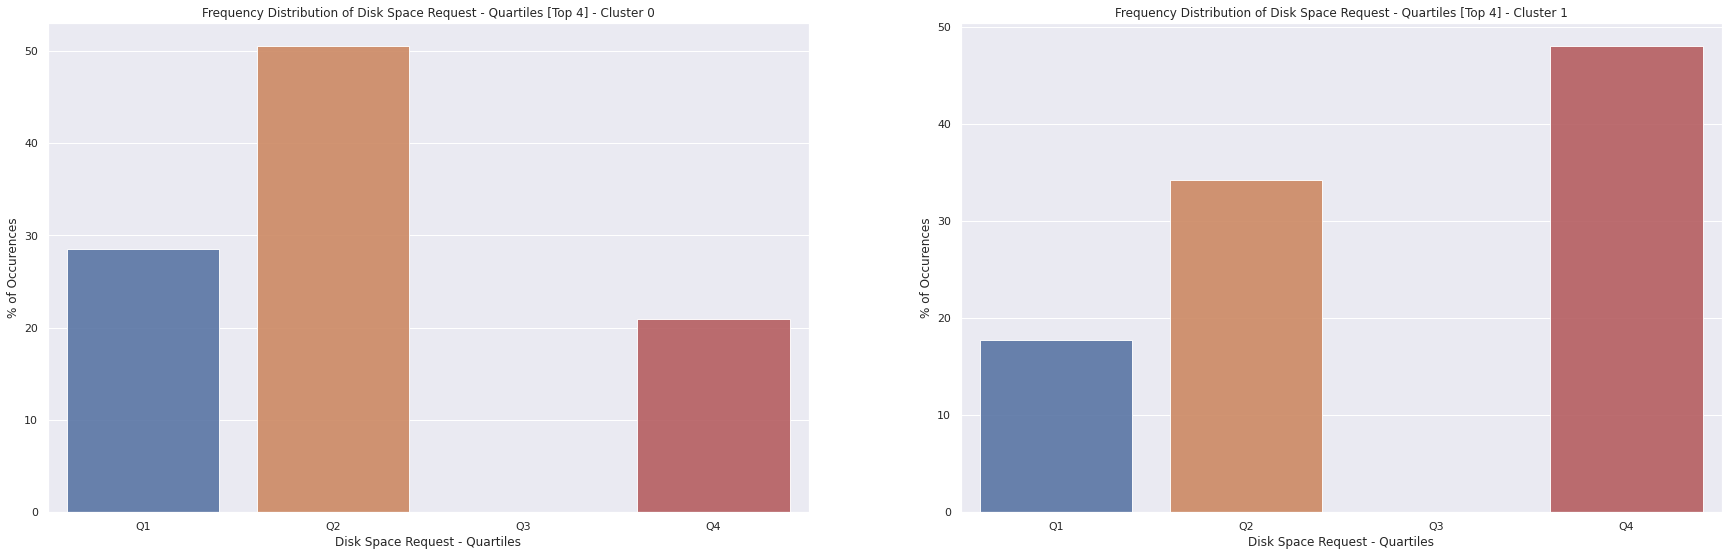

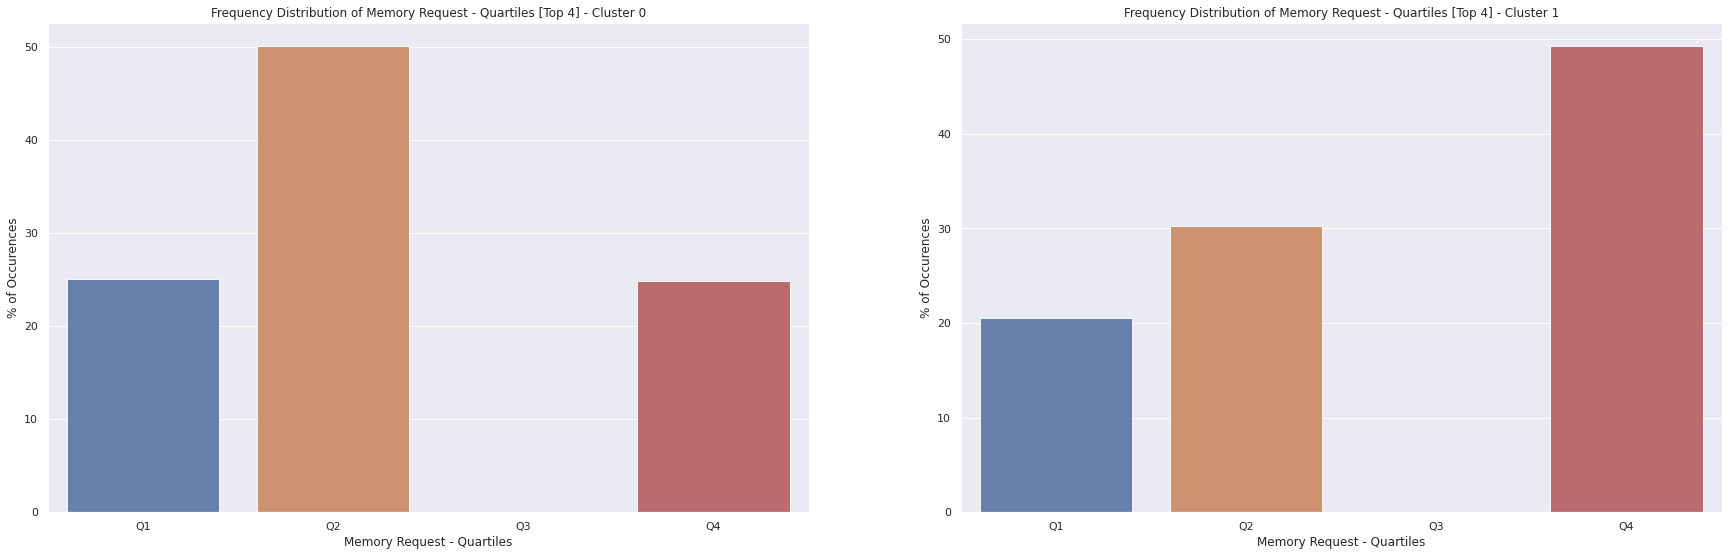

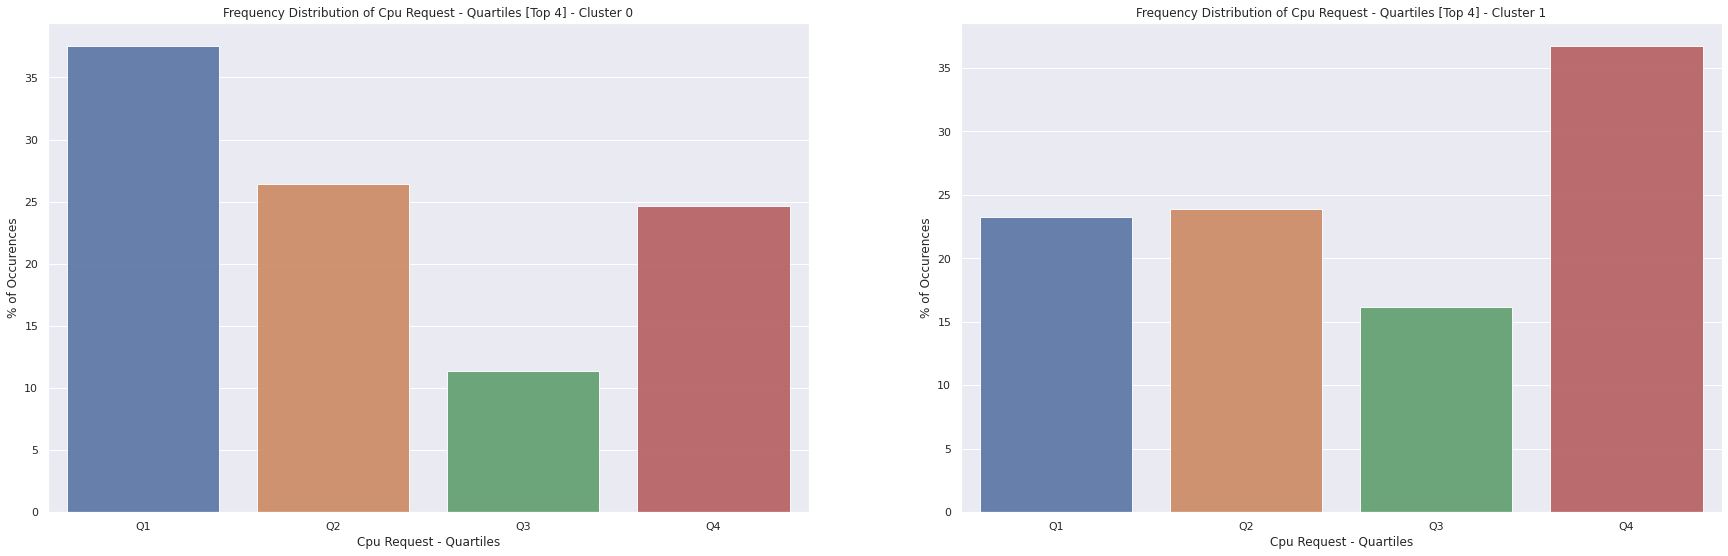

In [336]:
top_x=4
for label in ["disk space request - Quartiles", "memory request - Quartiles", "CPU request - Quartiles"]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes = [ax1, ax2]
    for i in sorted(list(set(cluster_labels_2))):
        column_count = static_metrics[cluster_labels_2 == i][label].value_counts().sort_index(ascending=True).head(top_x)
        for pr_lab in ['Q1', 'Q2', 'Q3', 'Q4']:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(['Q1', 'Q2', 'Q3', 'Q4'])
        sns.set(style="darkgrid")
        sns.barplot(column_count.index.astype(str), column_count.values  / len(static_metrics[cluster_labels_2 == i]) * 100, alpha=0.9, ax=axes[i])
        axes[i].set_title(f'Frequency Distribution of {label.title()} [Top {top_x}] - Cluster {i}')
        axes[i].set_ylabel('% of Occurences', fontsize=12)
        axes[i].set_xlabel(f'{label.title()}', fontsize=12)
        #axes[i].set_xticklabels(column_count.index, rotation=30, horizontalalignment='right')

### K-Means = 6

#### Frequency distribution of scheduling class

[1 1 1 ... 2 2 0]


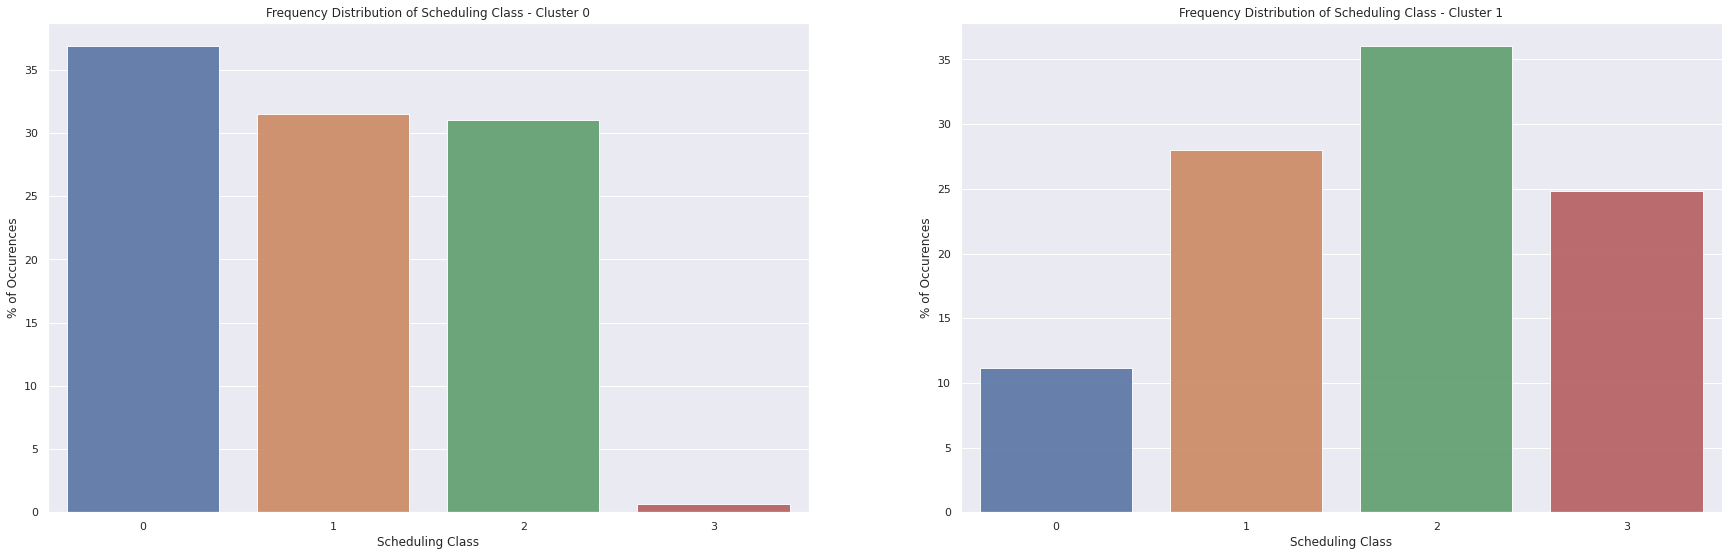

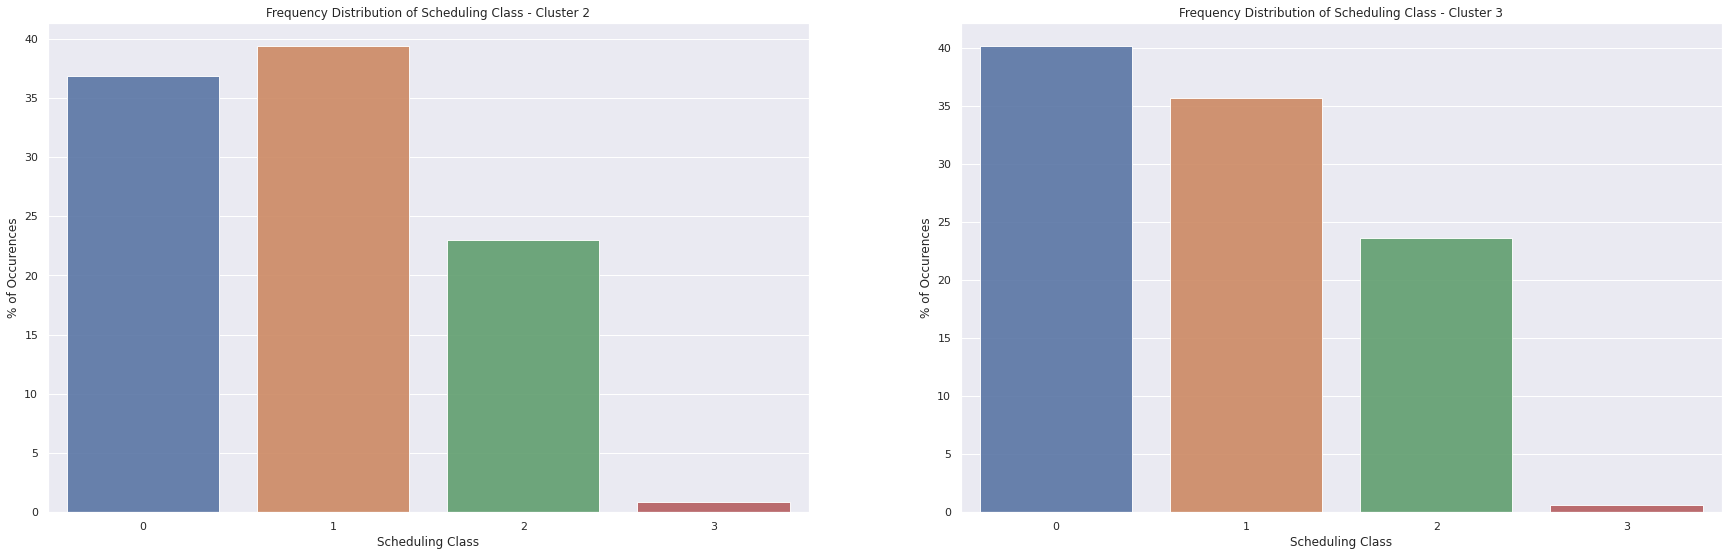

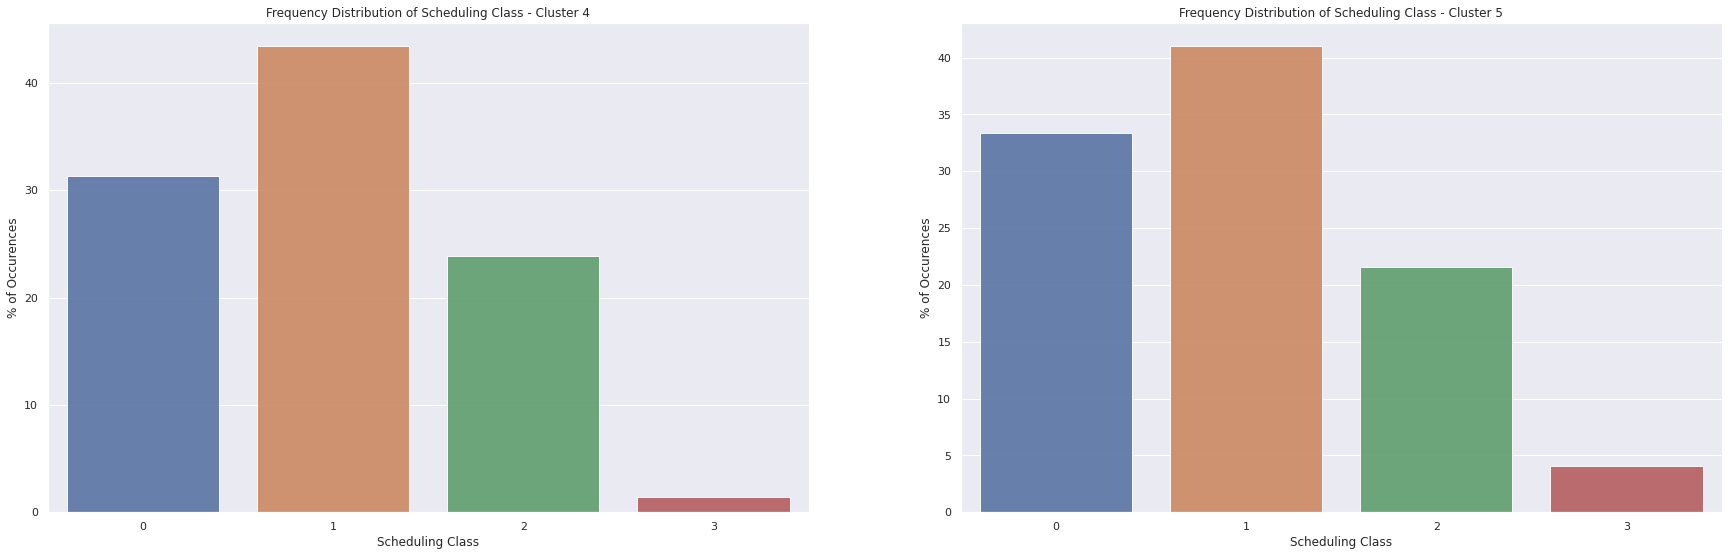

In [318]:
cluster_labels = cluster_labels_6
print(cluster_labels)
label = "scheduling class"

for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for sch_class in range(0,4):
            if sch_class not in column_count.index:
                s = pd.Series([0], index=[sch_class])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)


#### Frequency distribution of priority

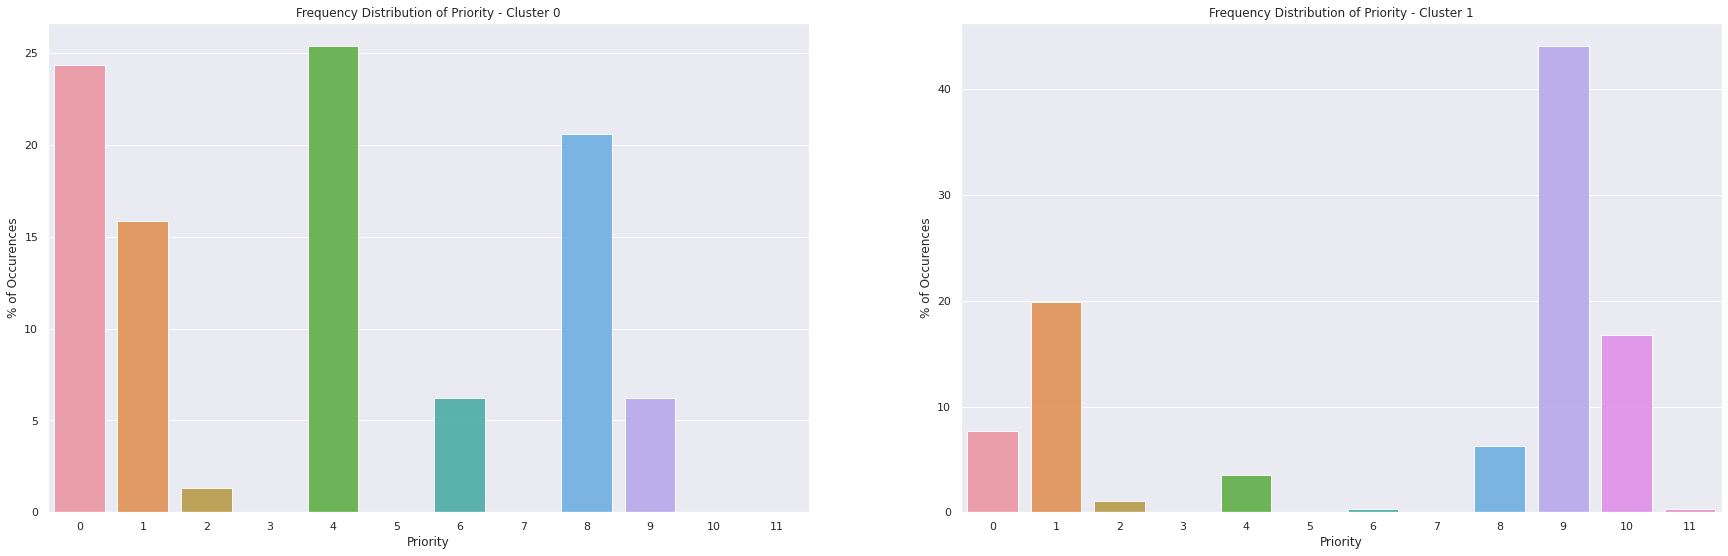

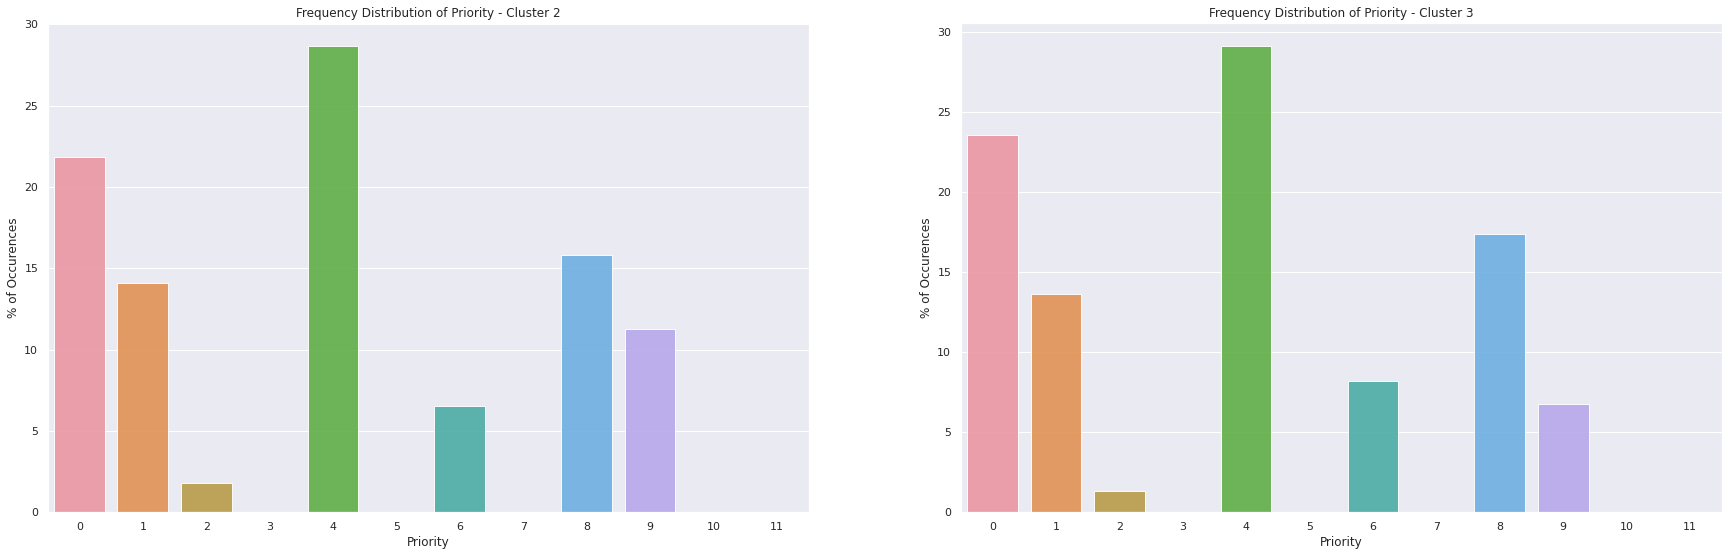

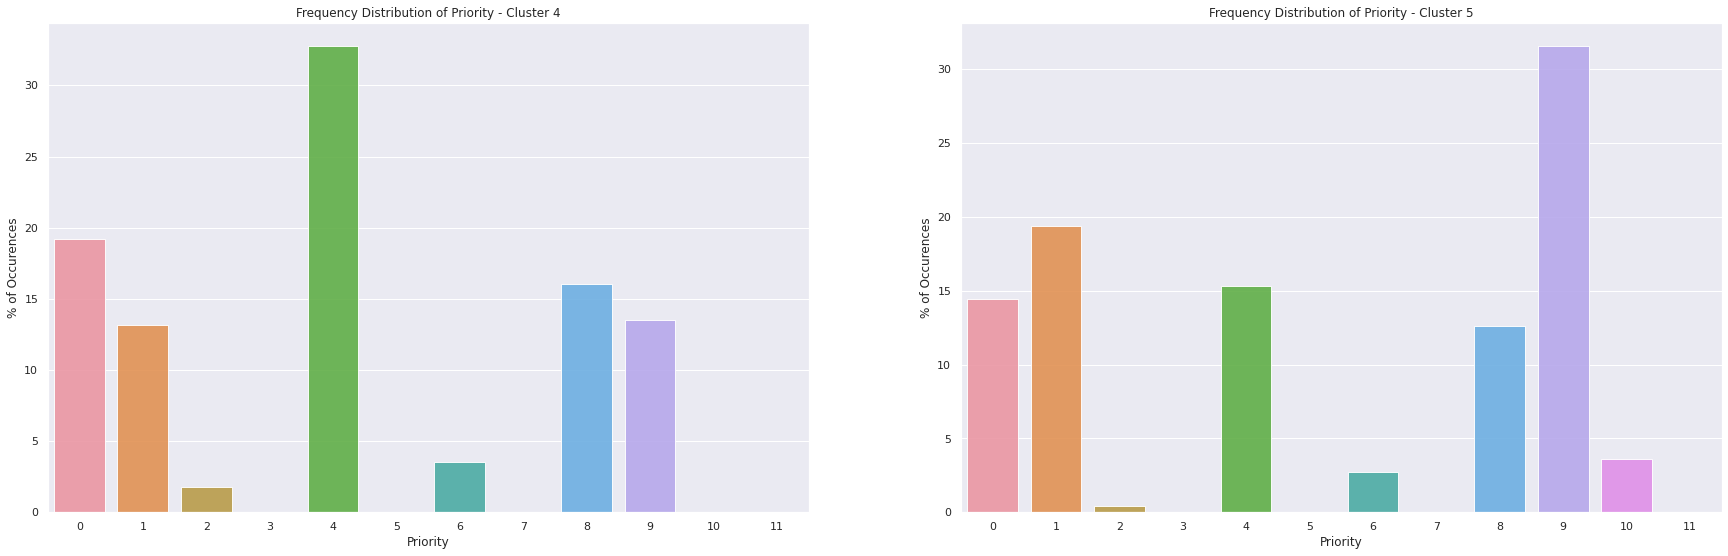

In [316]:
cluster_labels = cluster_labels_6
label = "priority"

for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in range(0,12):
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)


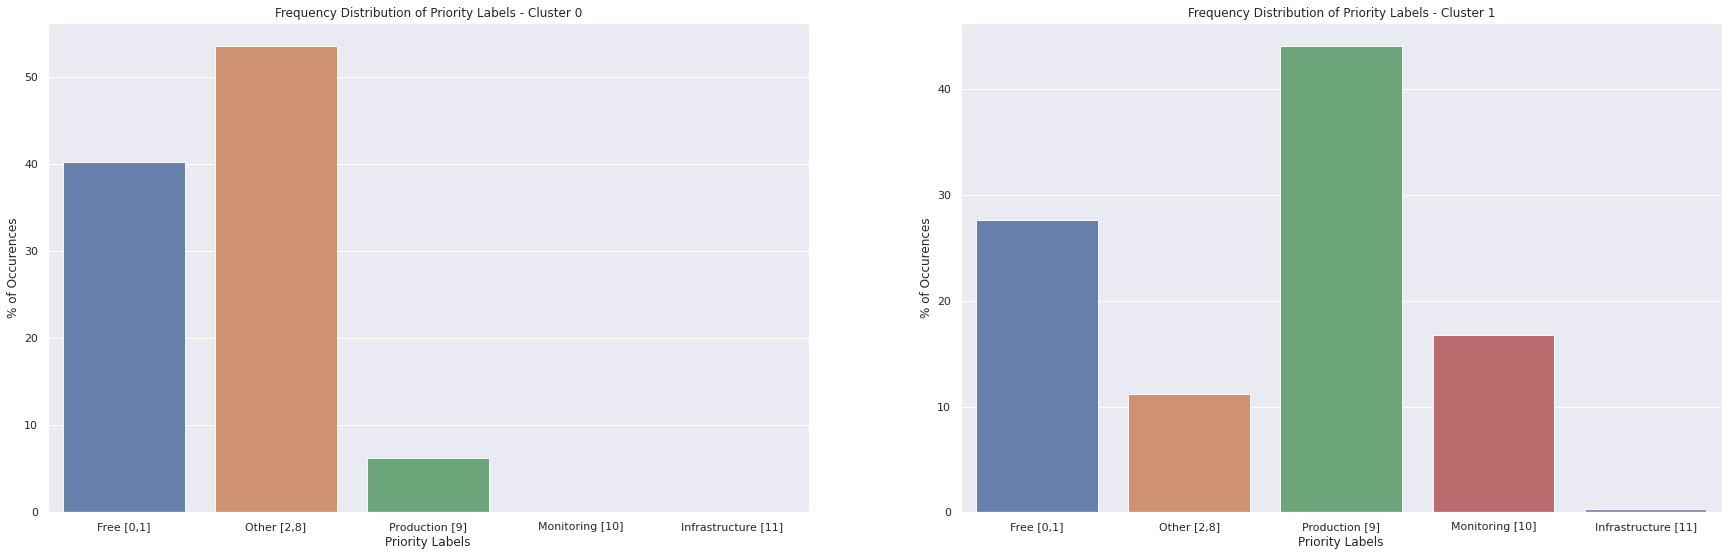

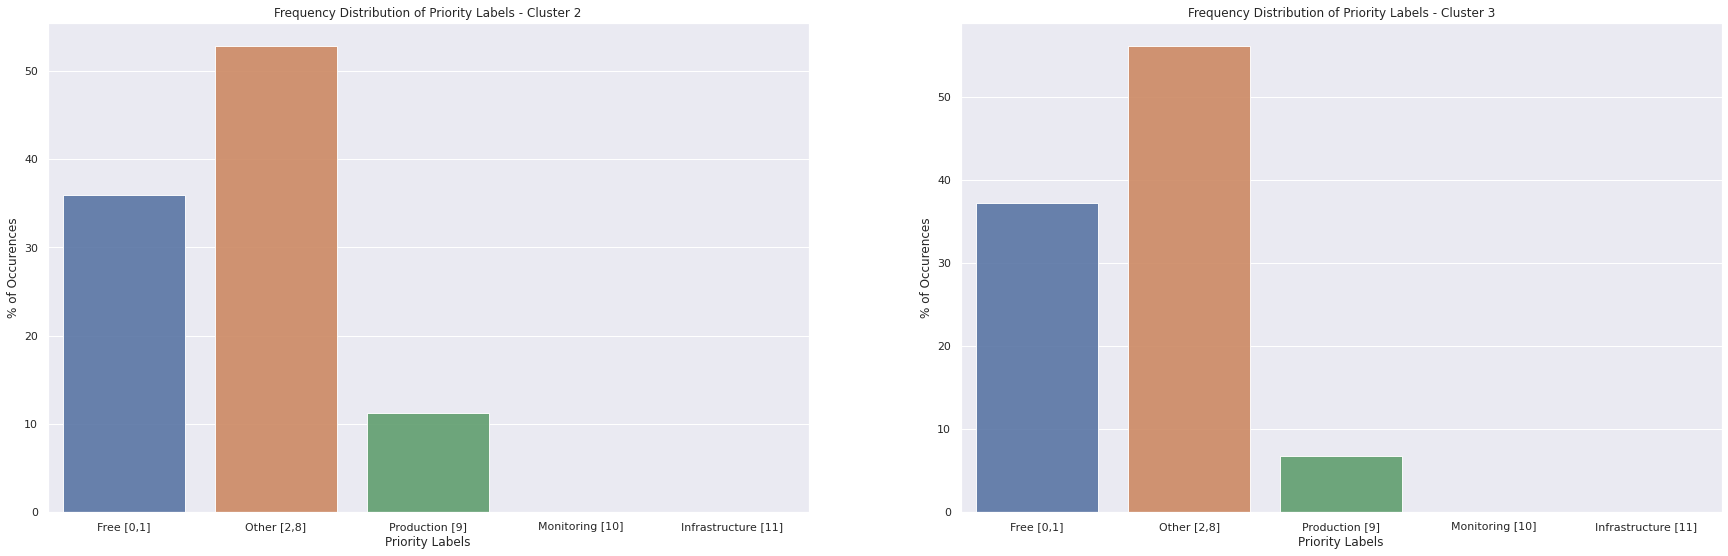

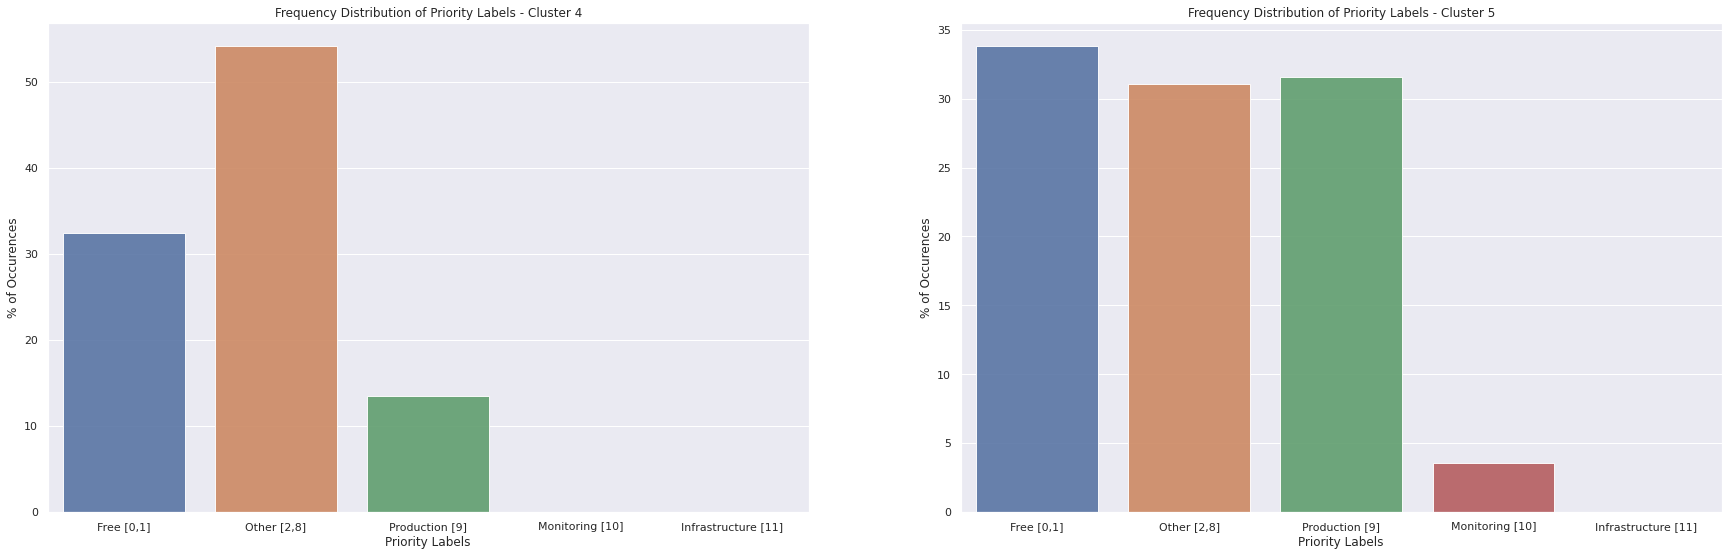

In [331]:
cluster_labels = cluster_labels_6
label = "priority labels"
priority_labels = ["Free [0,1]", "Other [2,8]", "Production [9]", "Monitoring [10]", "Infrastructure [11]"]

for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts()
        for pr_lab in priority_labels:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(priority_labels)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Freqency distribution for different machines restriction

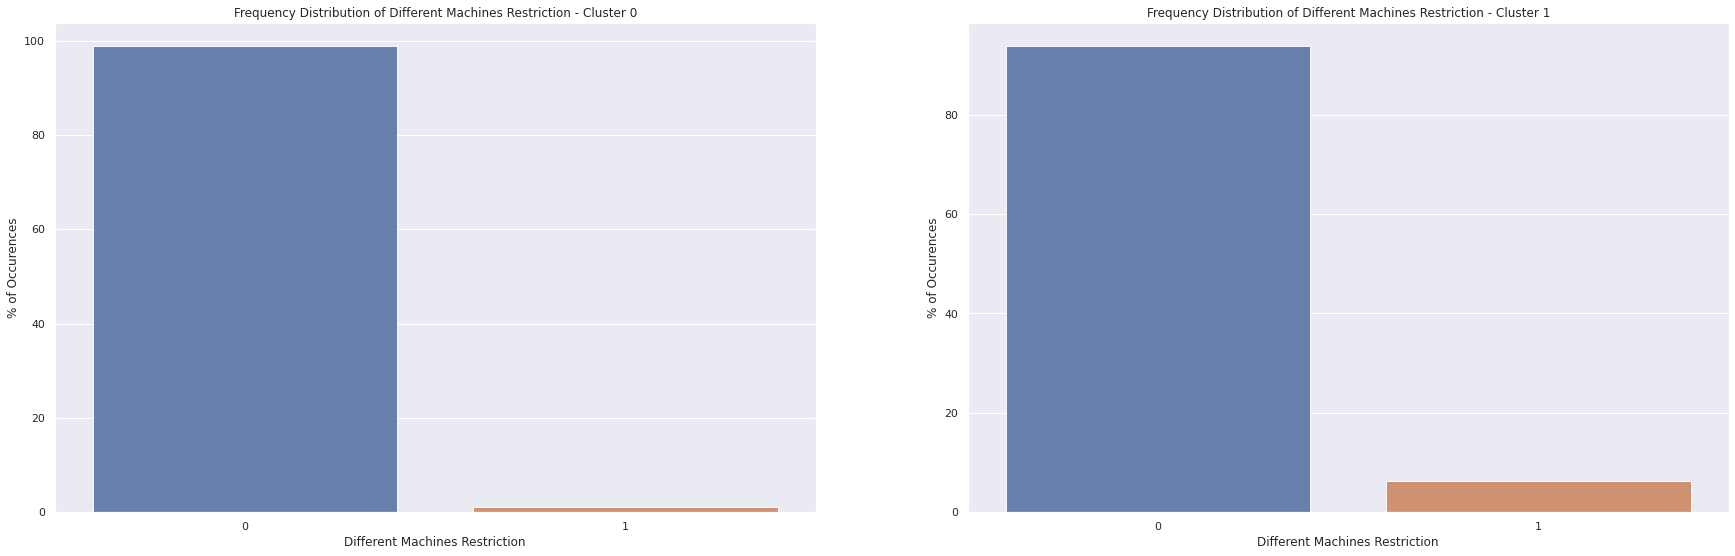

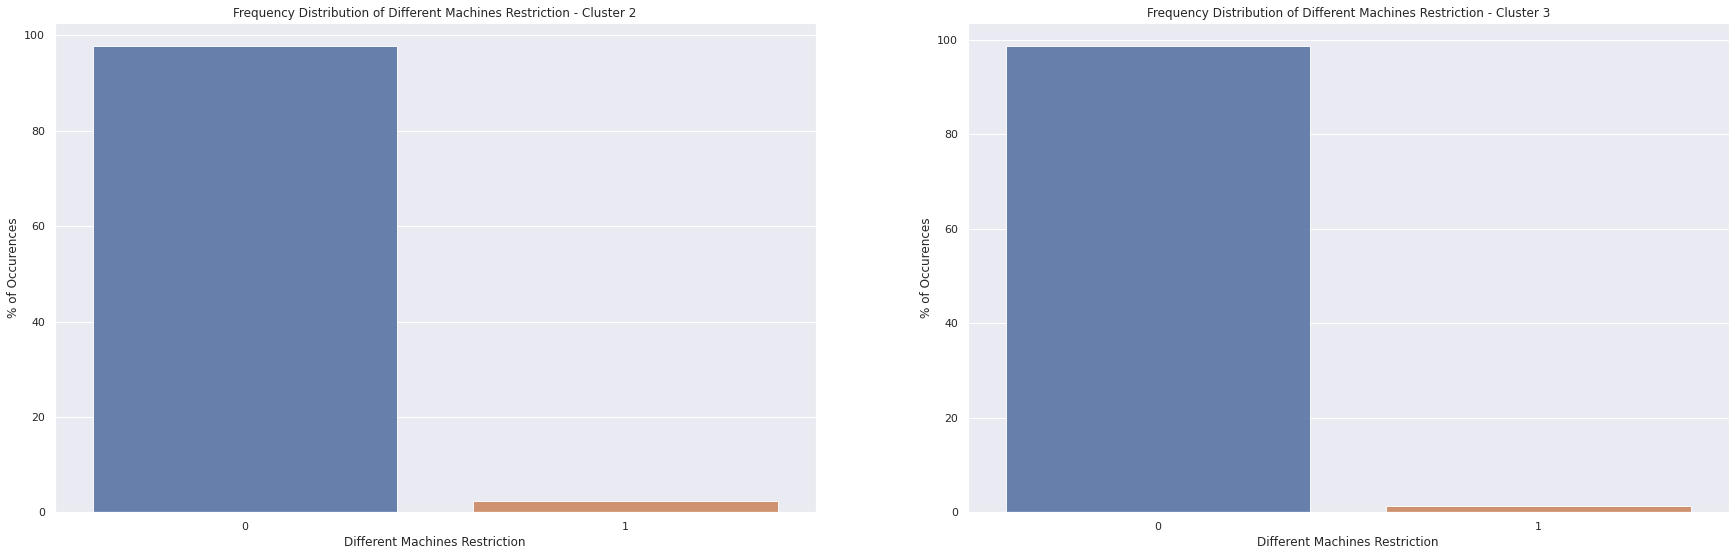

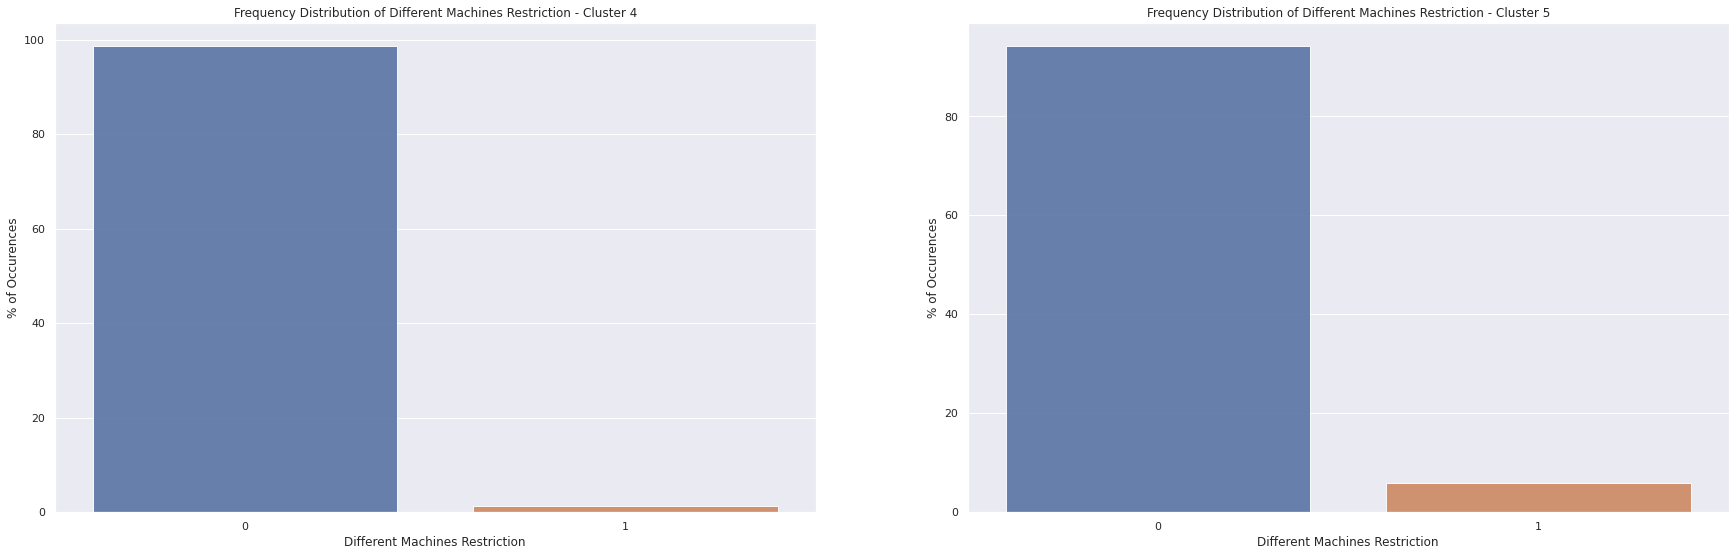

In [332]:
cluster_labels = cluster_labels_6
label = "different machines restriction"

for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in range(0,2):
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for disk request - quartiles

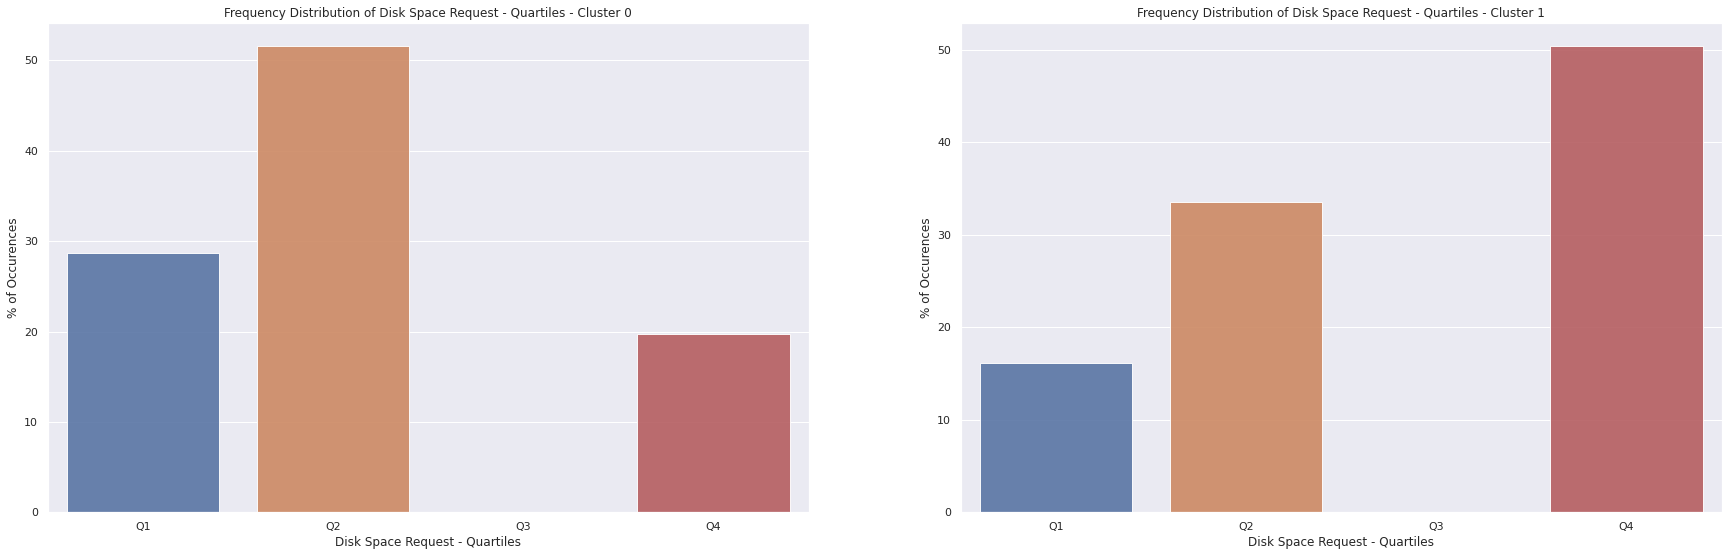

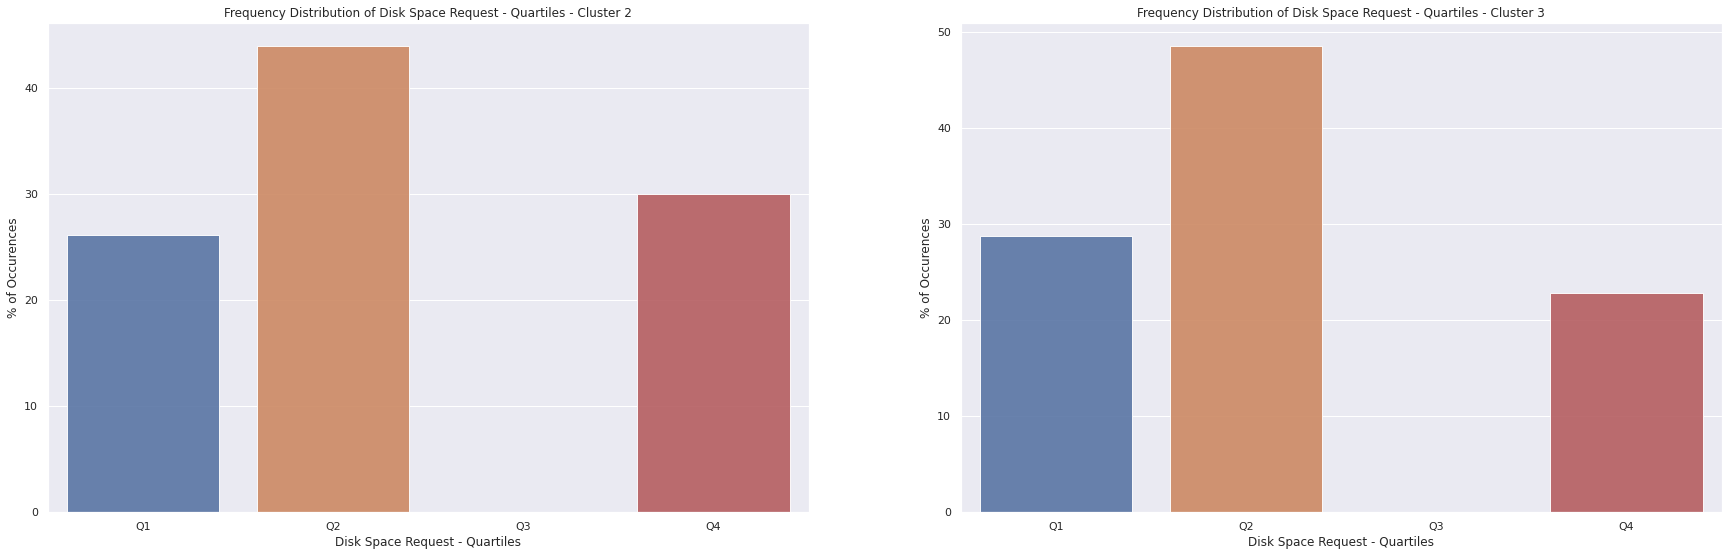

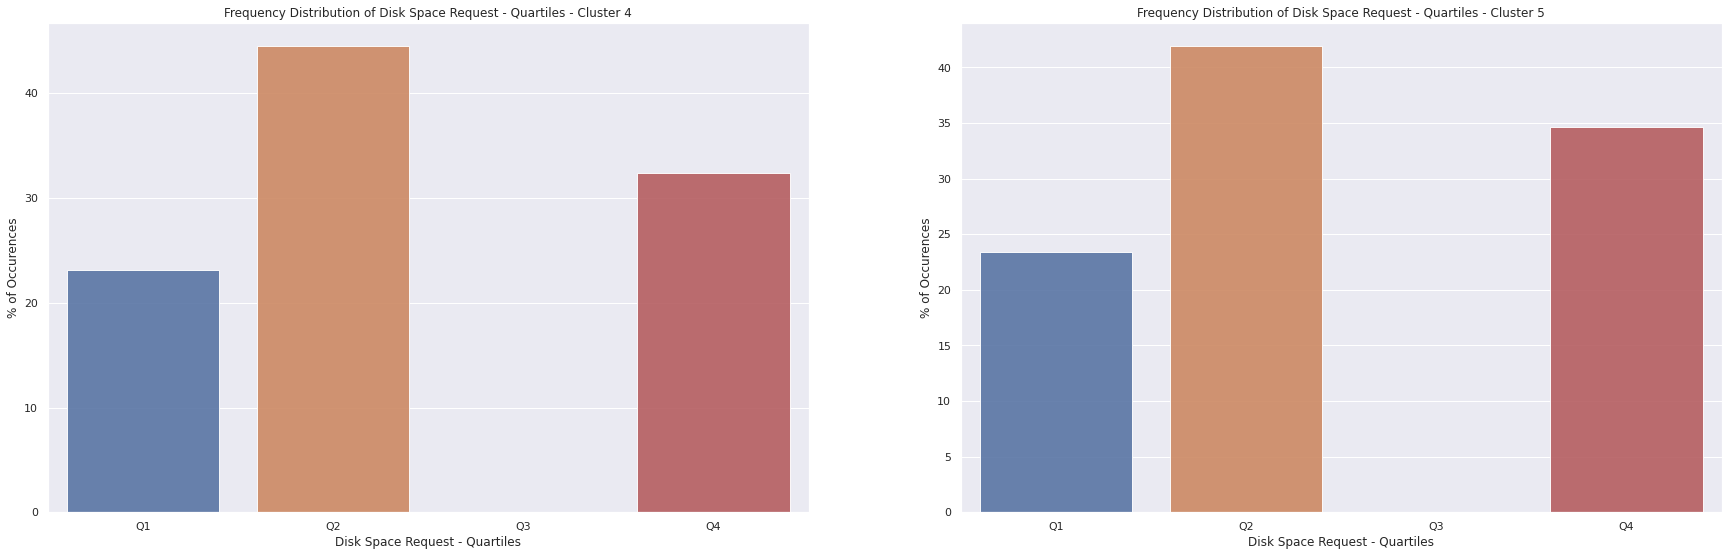

In [338]:
cluster_labels = cluster_labels_6
label = "disk space request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for memory request - quartiles

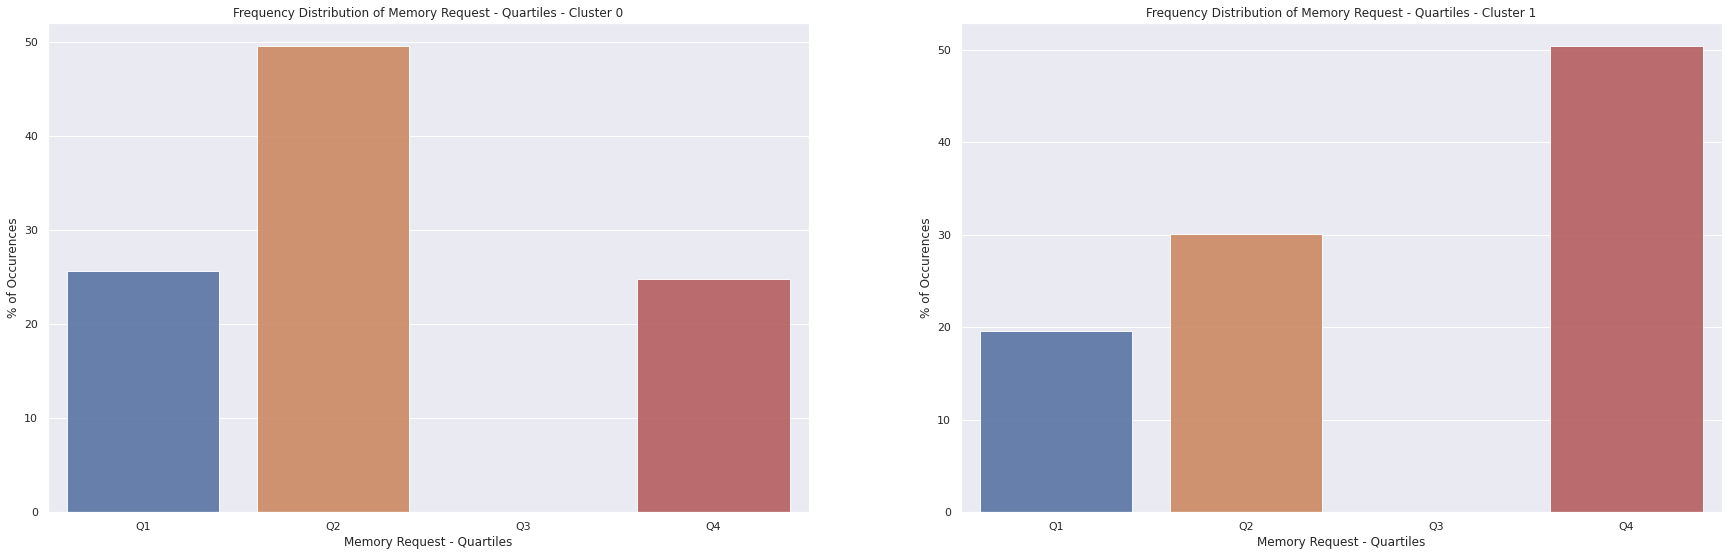

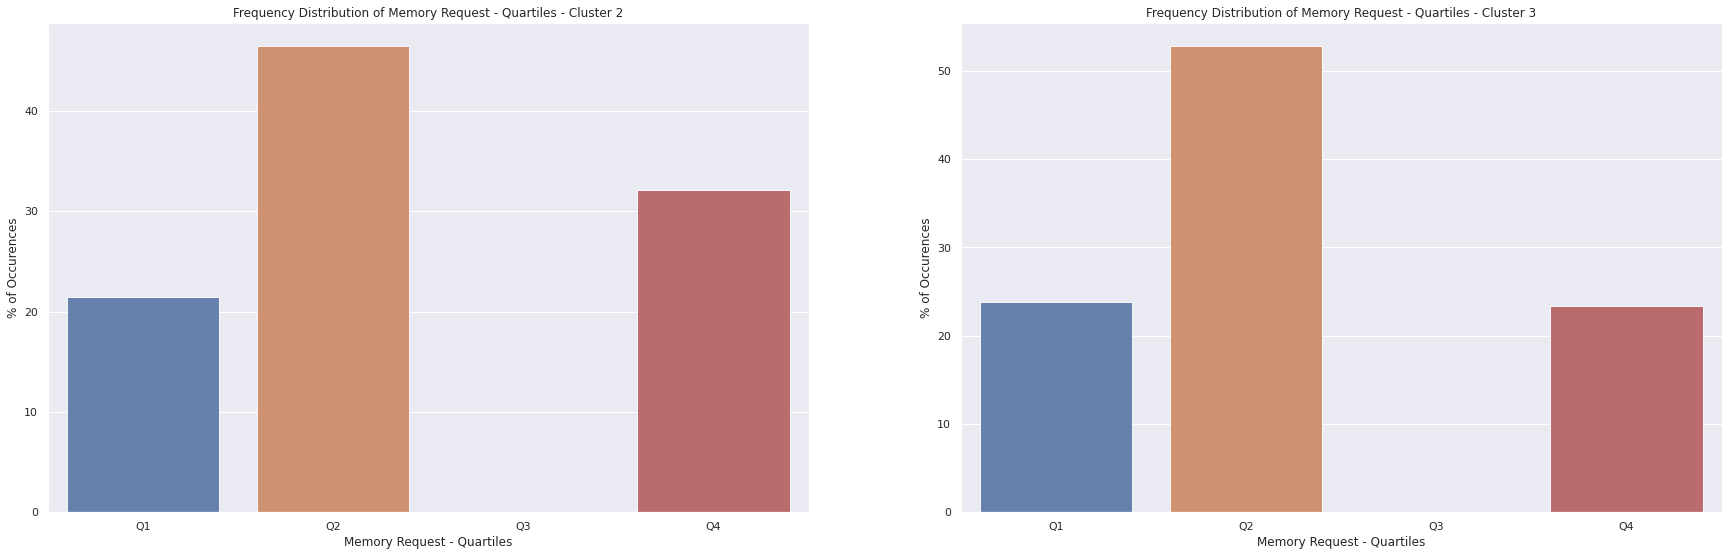

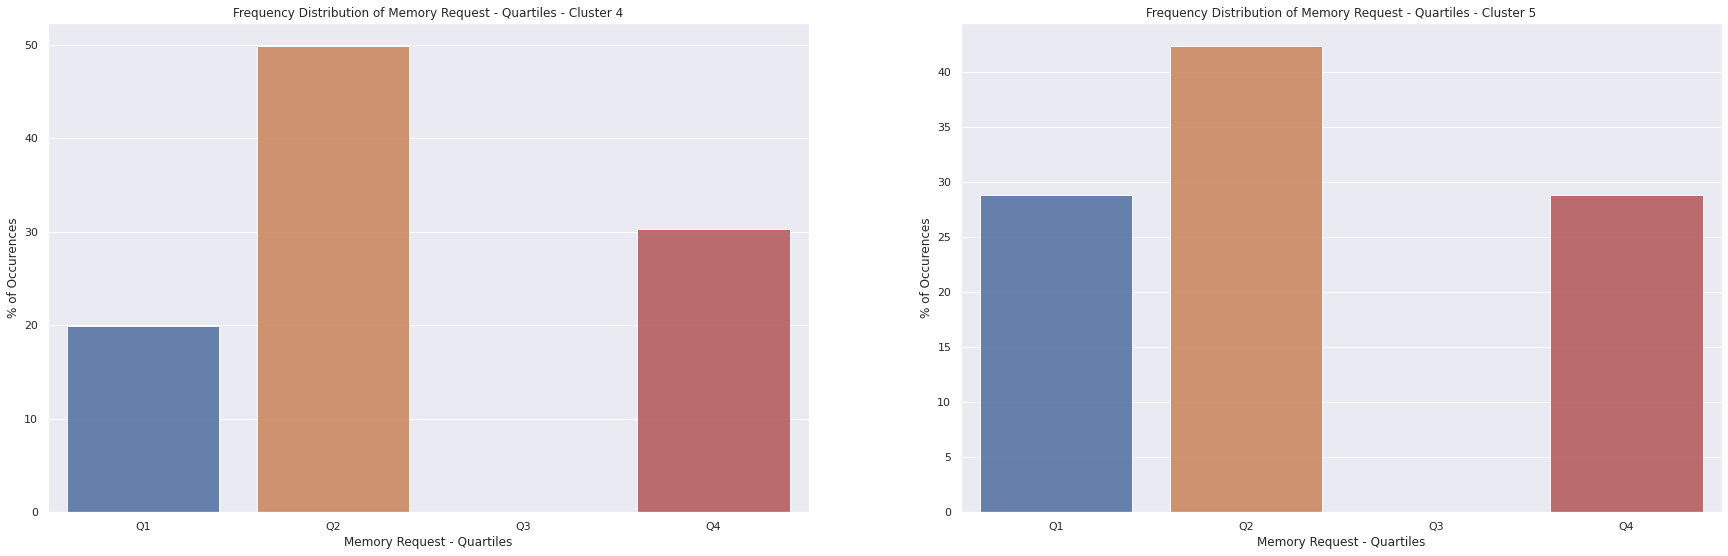

In [339]:
cluster_labels = cluster_labels_6
label = "memory request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for CPU request - quartiles

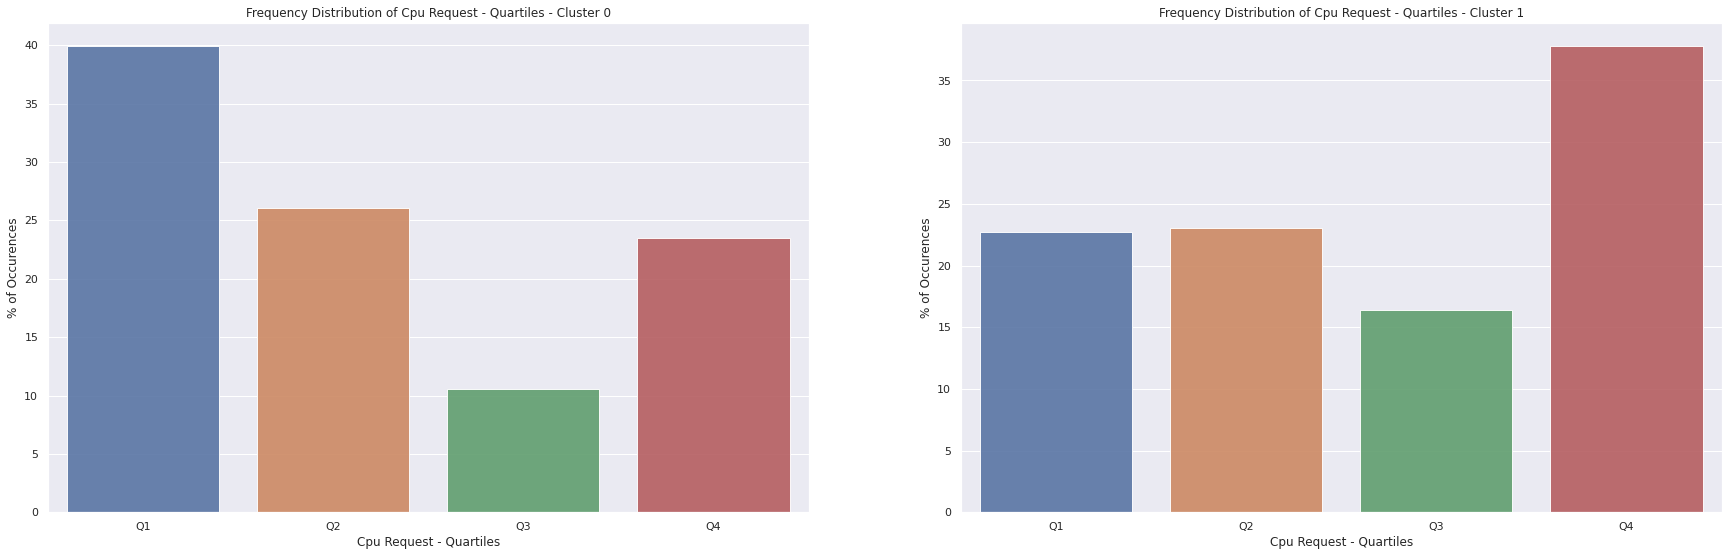

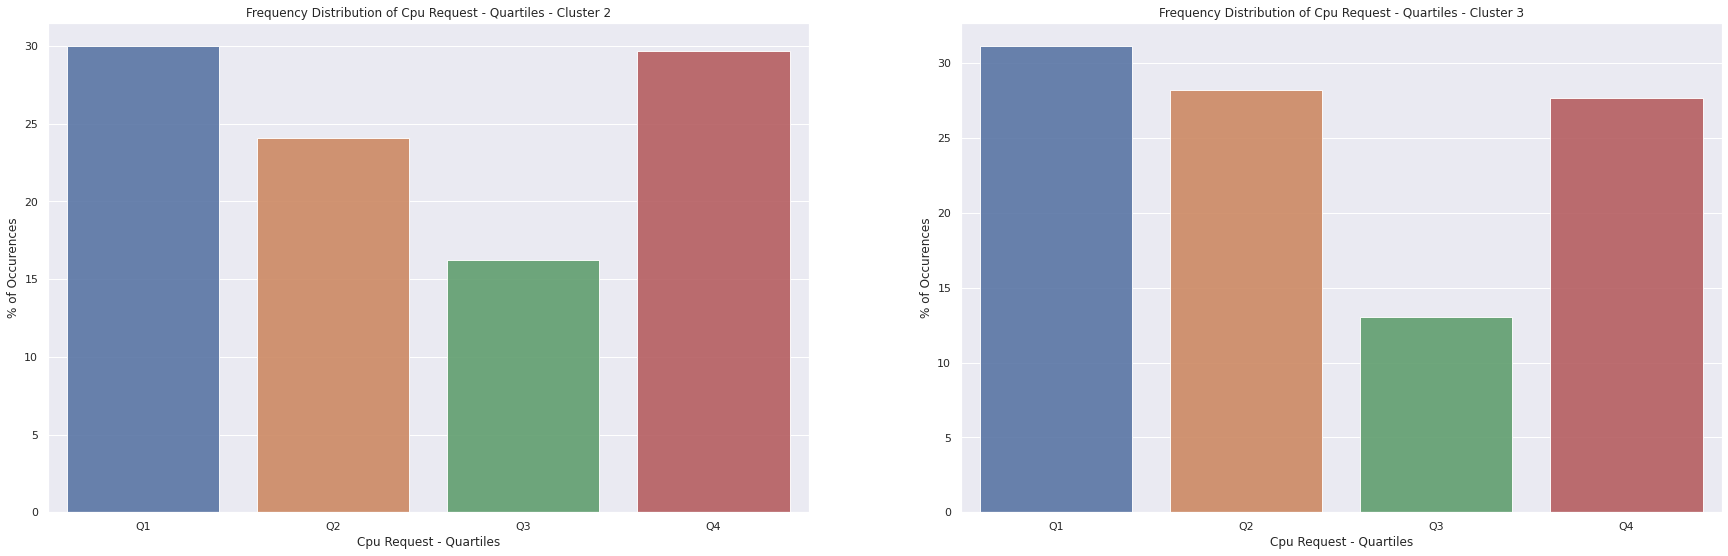

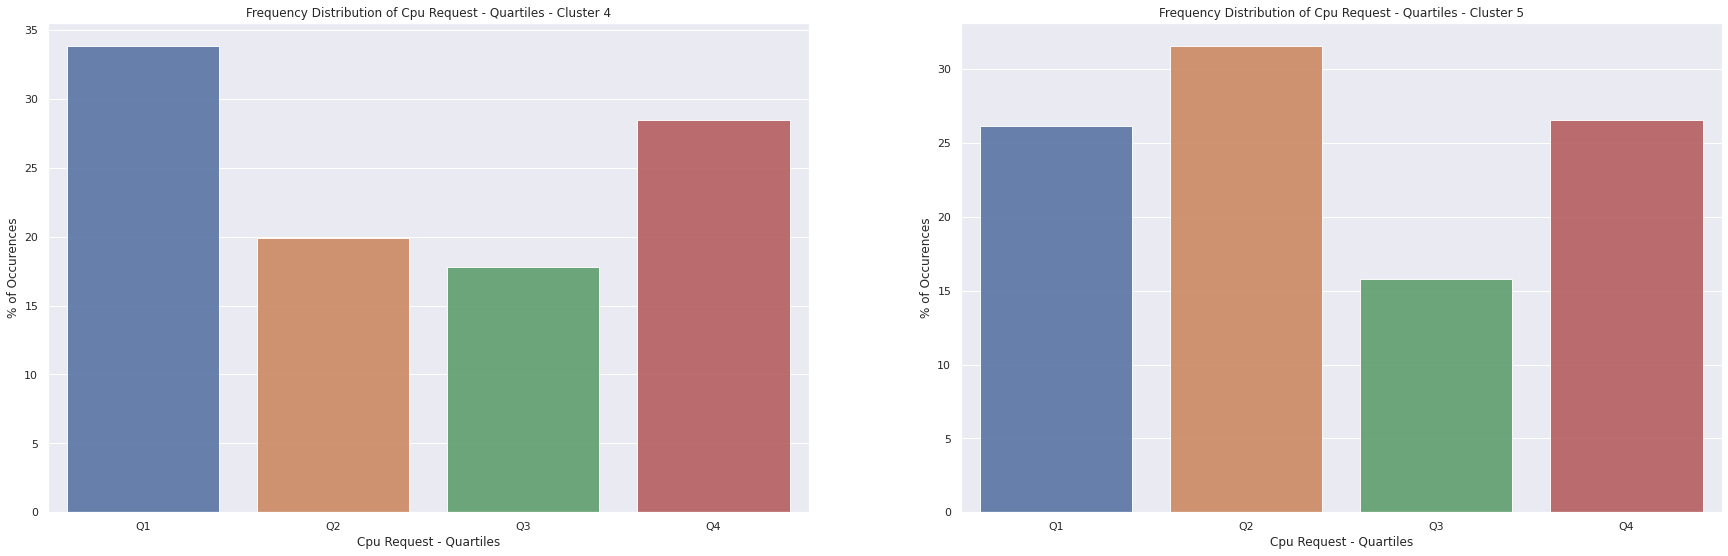

In [340]:
cluster_labels = cluster_labels_6
label = "CPU request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

### K-Means = 10

#### Frequency distribution of scheduling class

[1 1 1 ... 2 2 0]


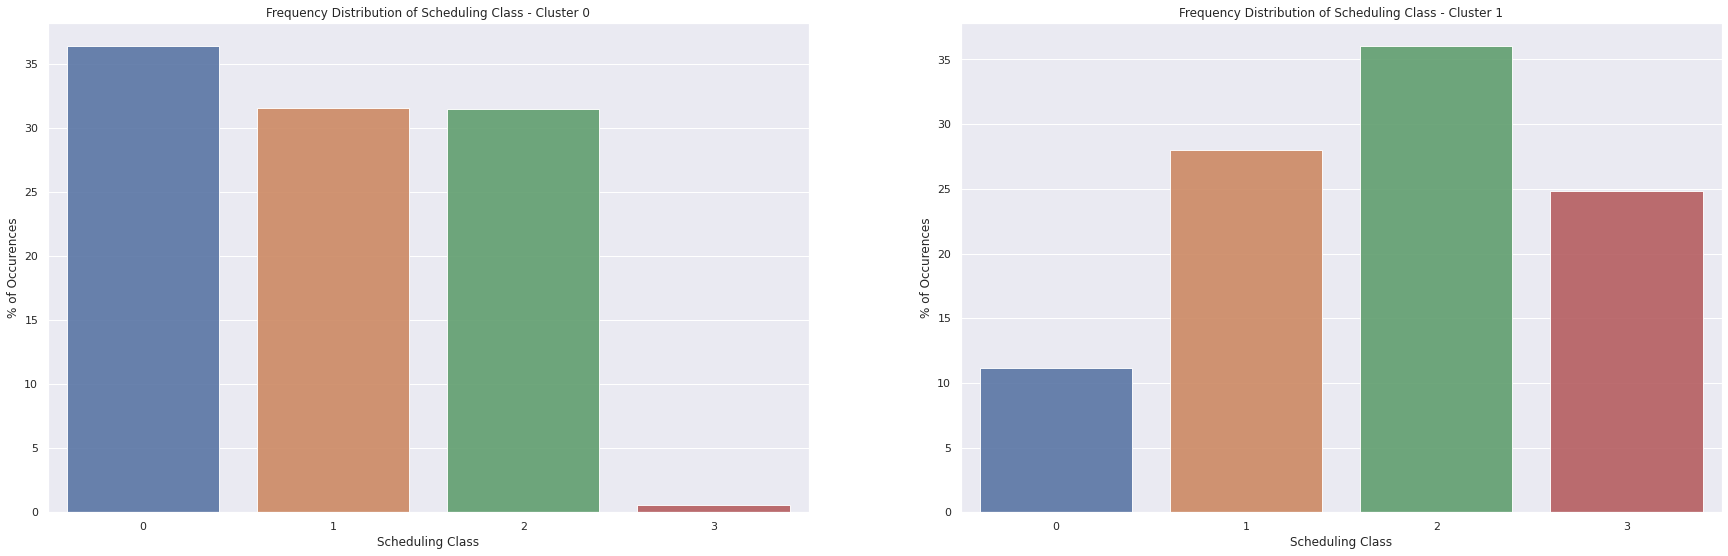

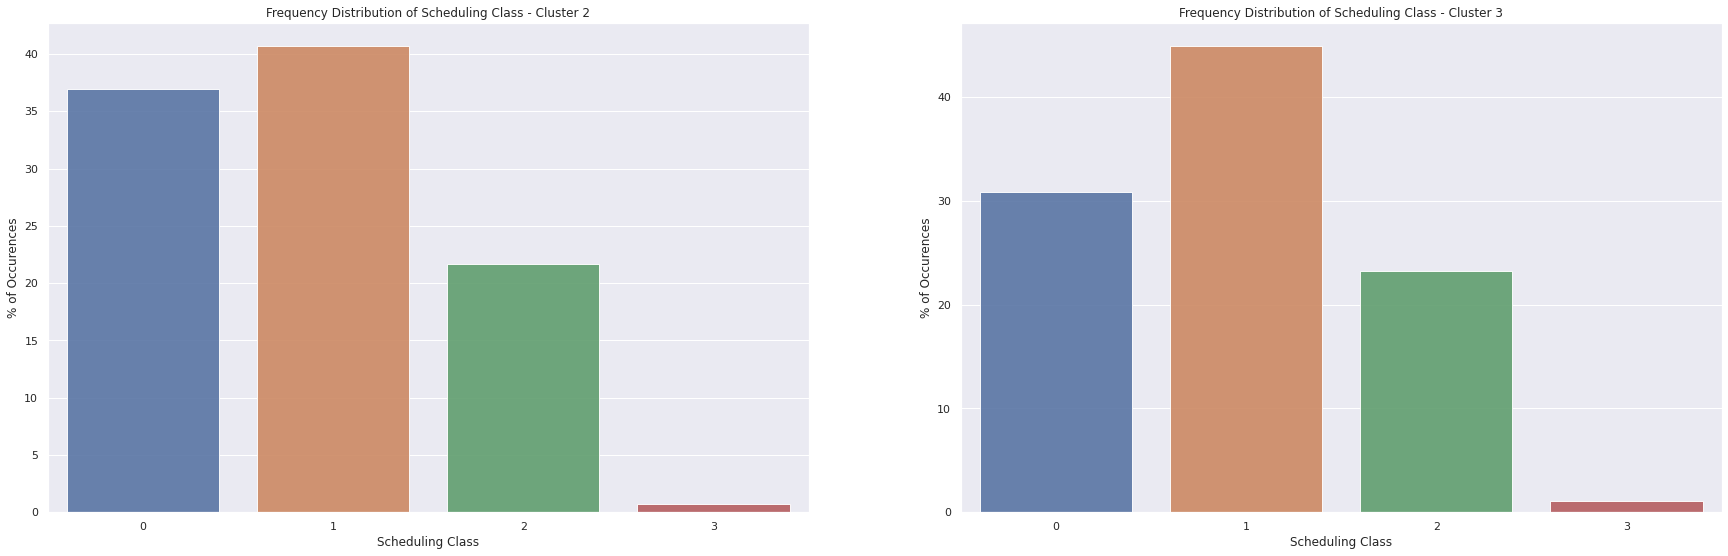

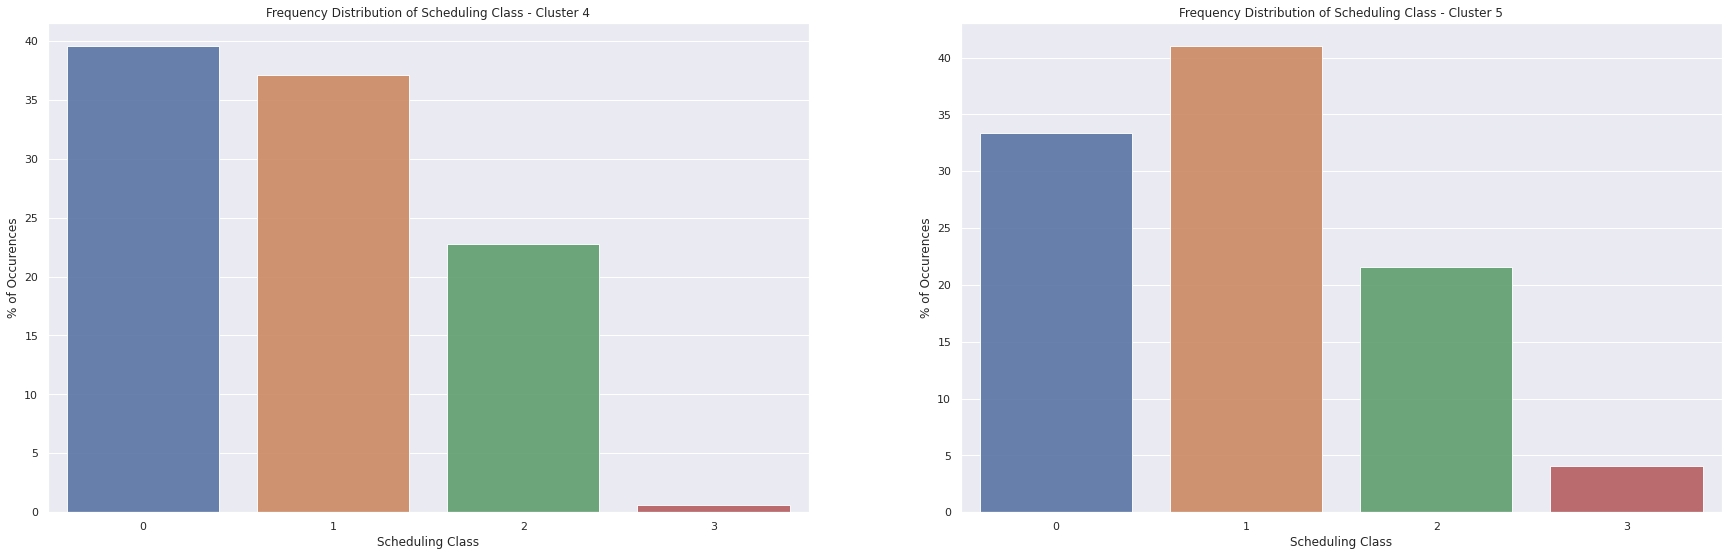

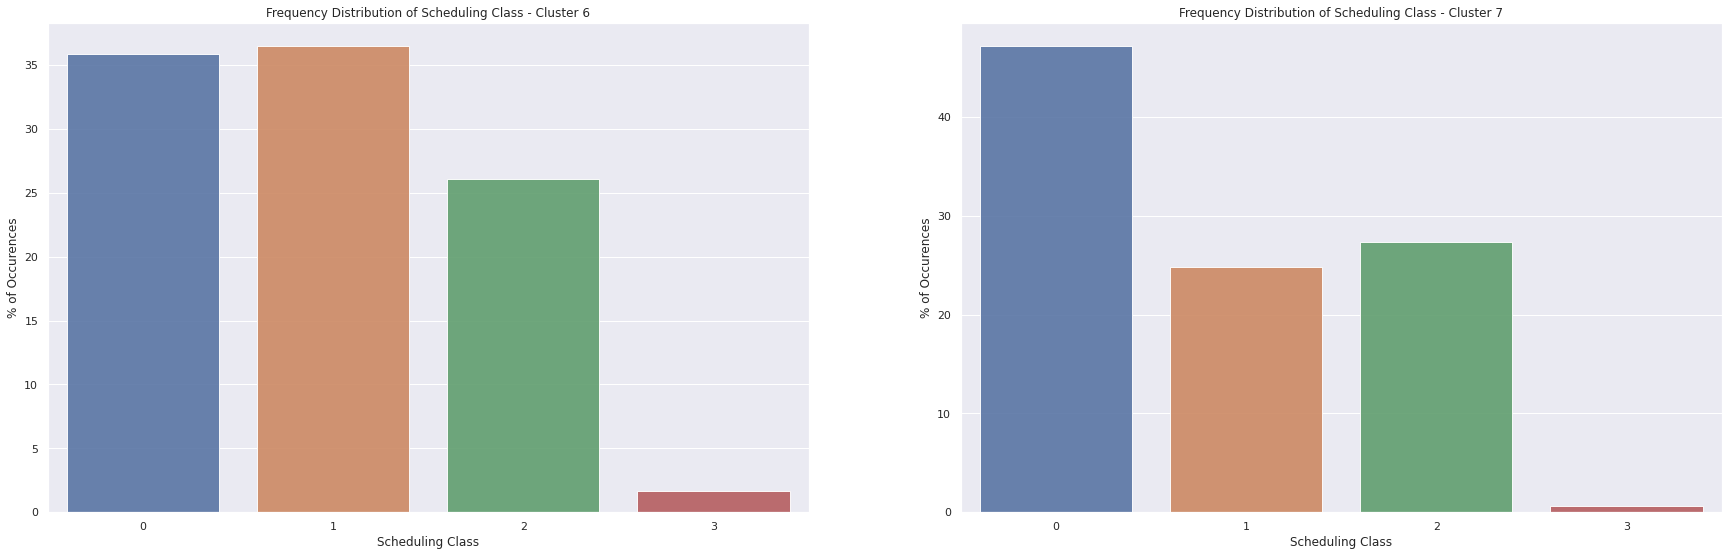

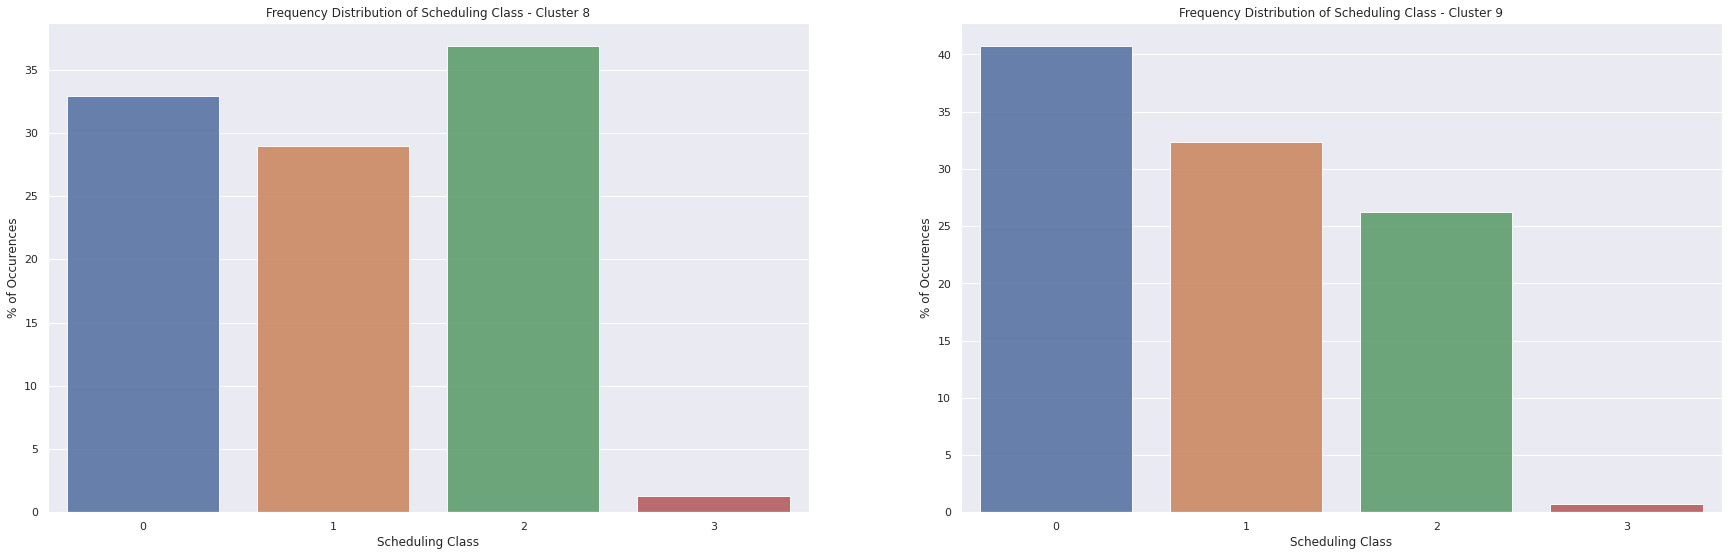

In [342]:
cluster_labels = cluster_labels_10
print(cluster_labels)
label = "scheduling class"

for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for sch_class in range(0,4):
            if sch_class not in column_count.index:
                s = pd.Series([0], index=[sch_class])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)


#### Frequency distribution of priority

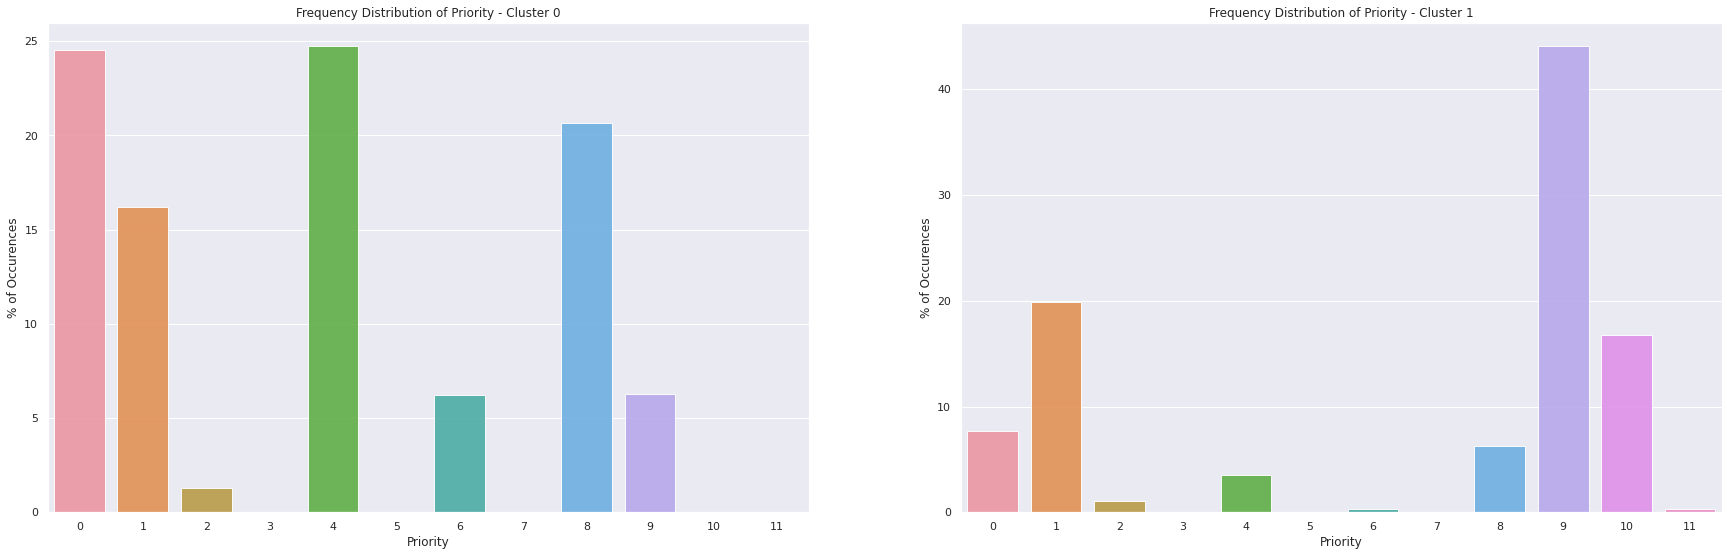

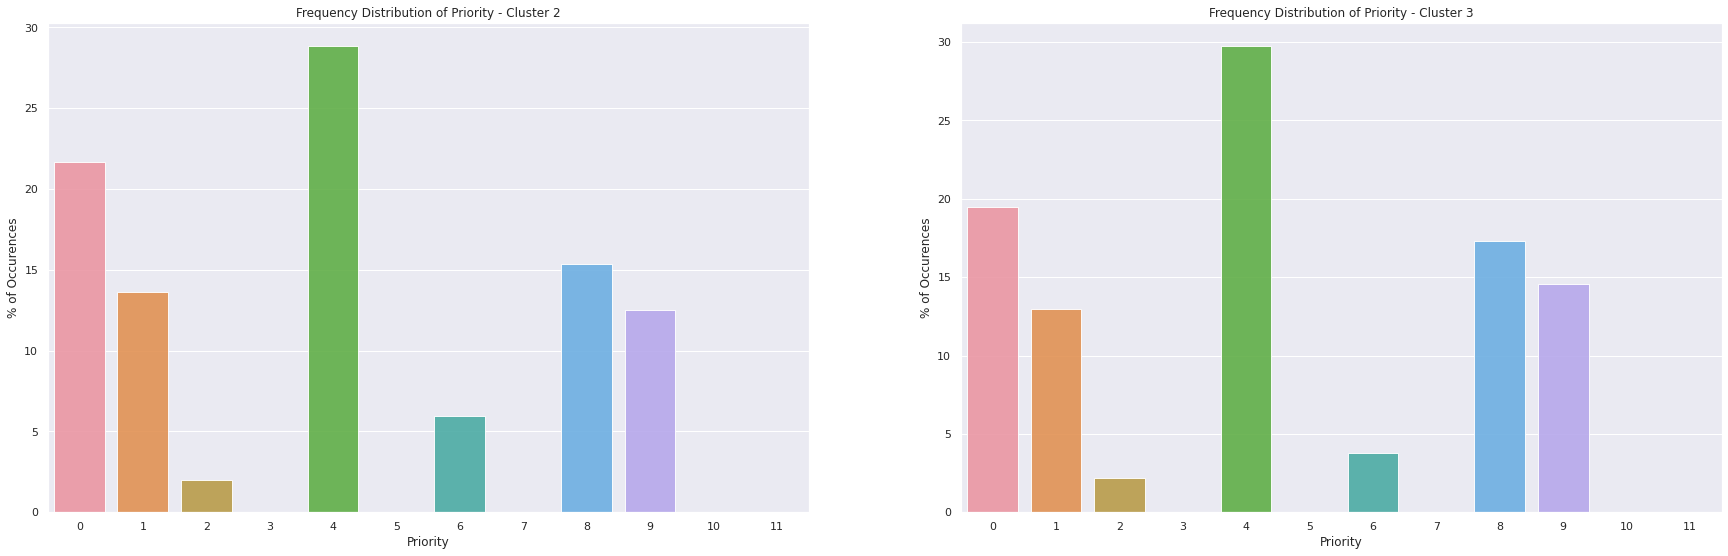

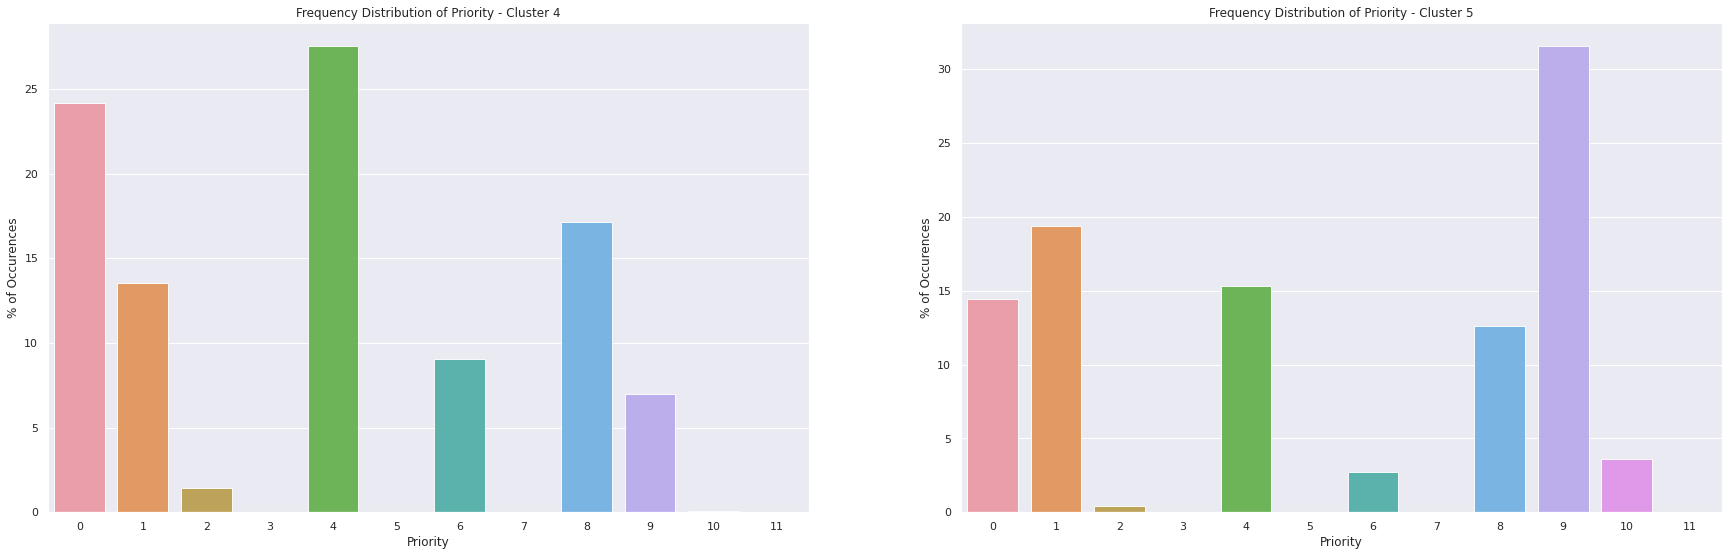

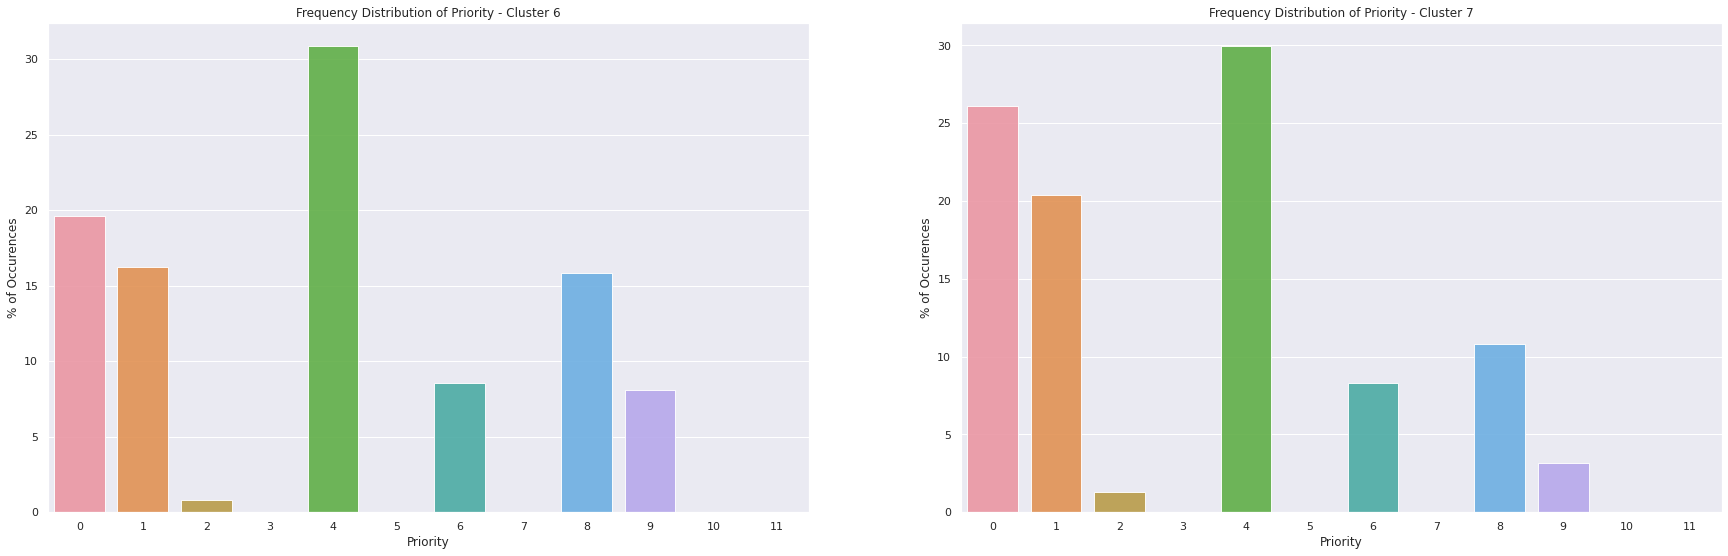

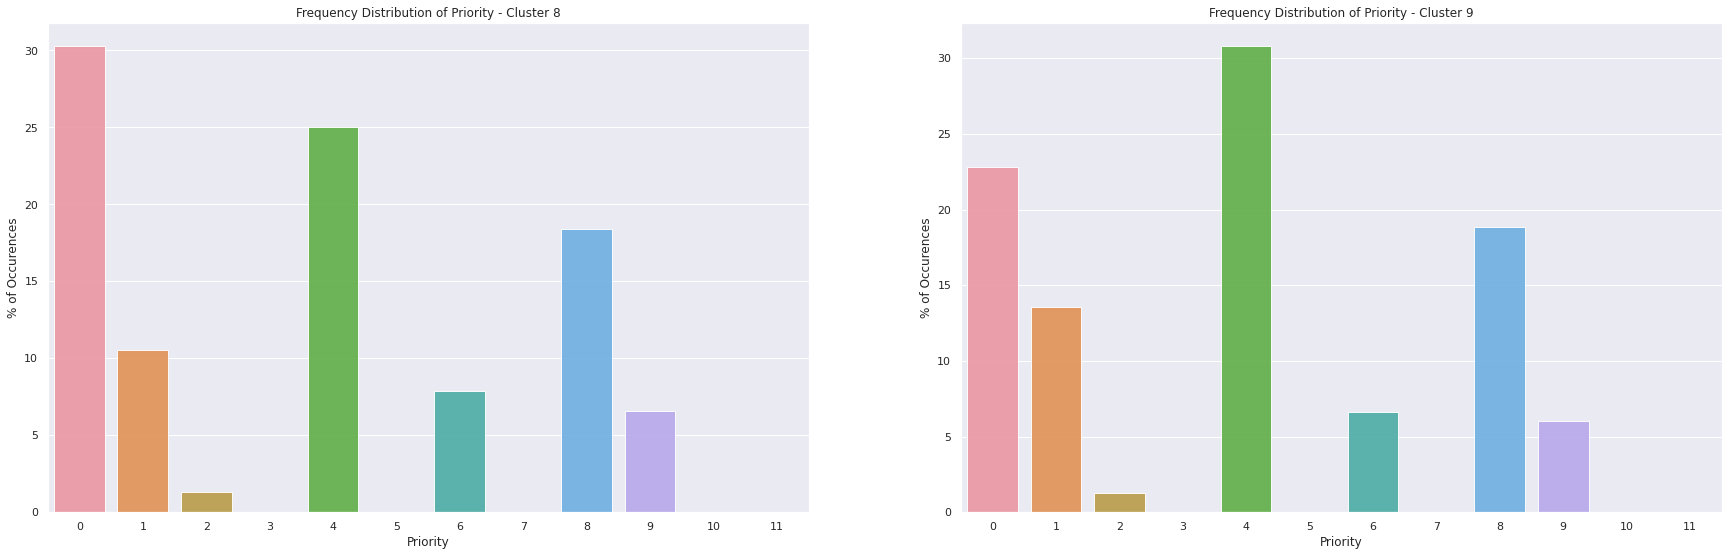

In [343]:
cluster_labels = cluster_labels_10
label = "priority"

for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in range(0,12):
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)


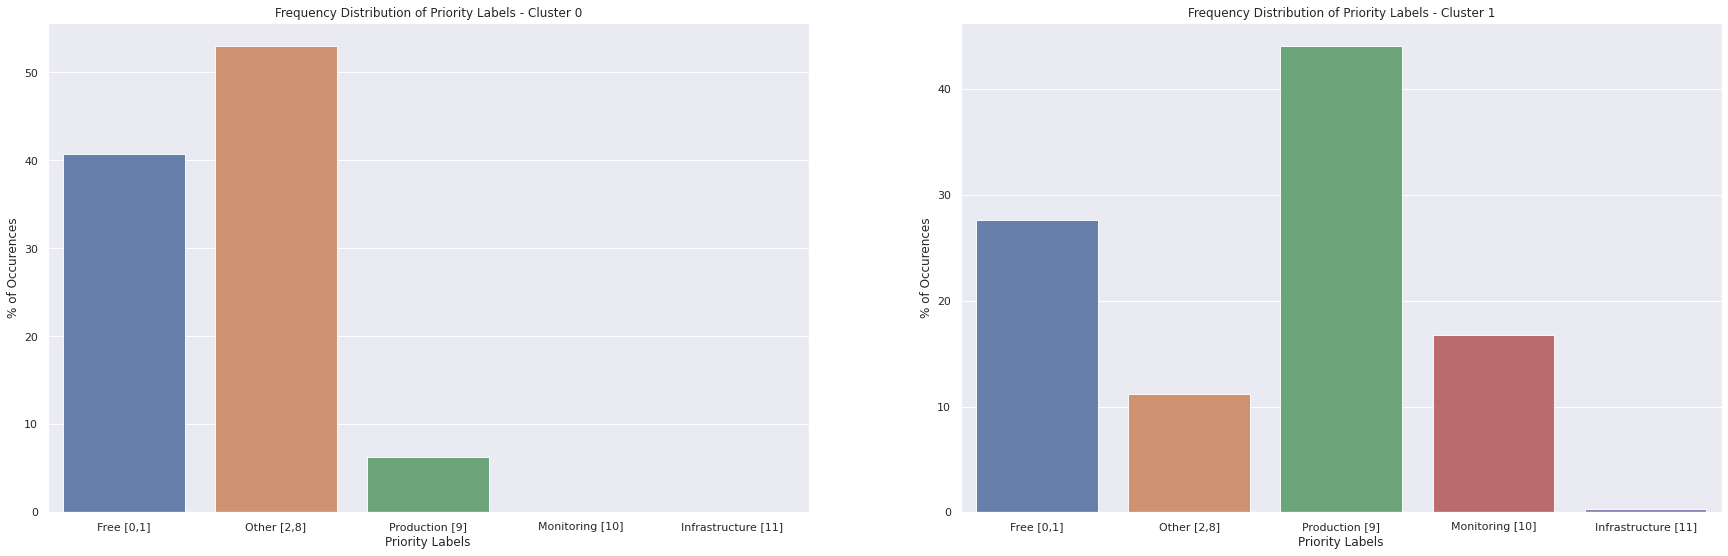

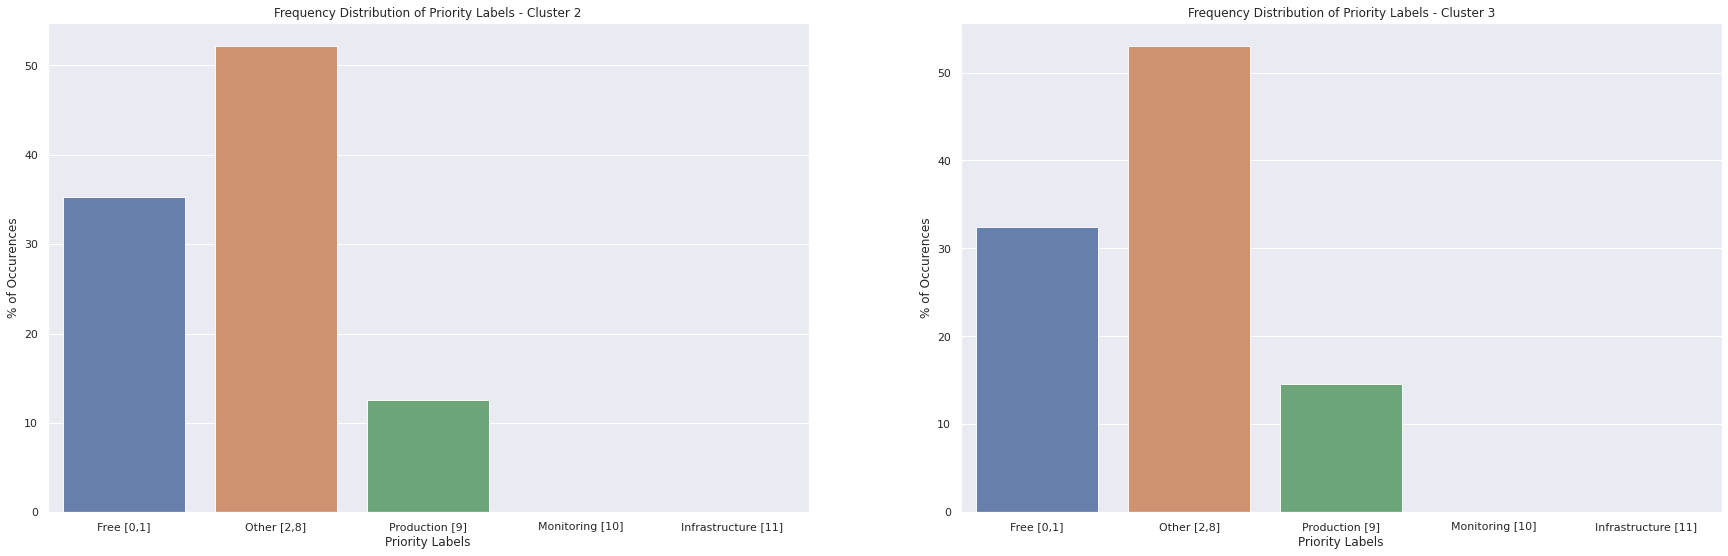

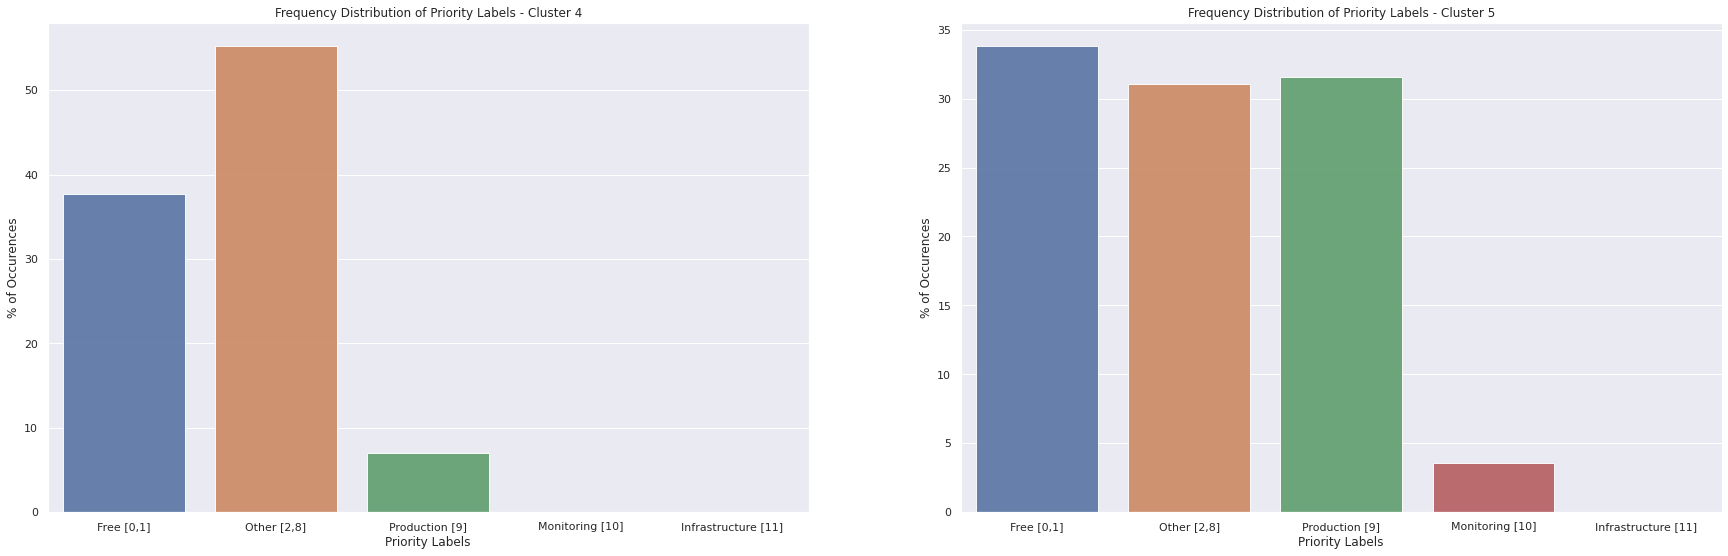

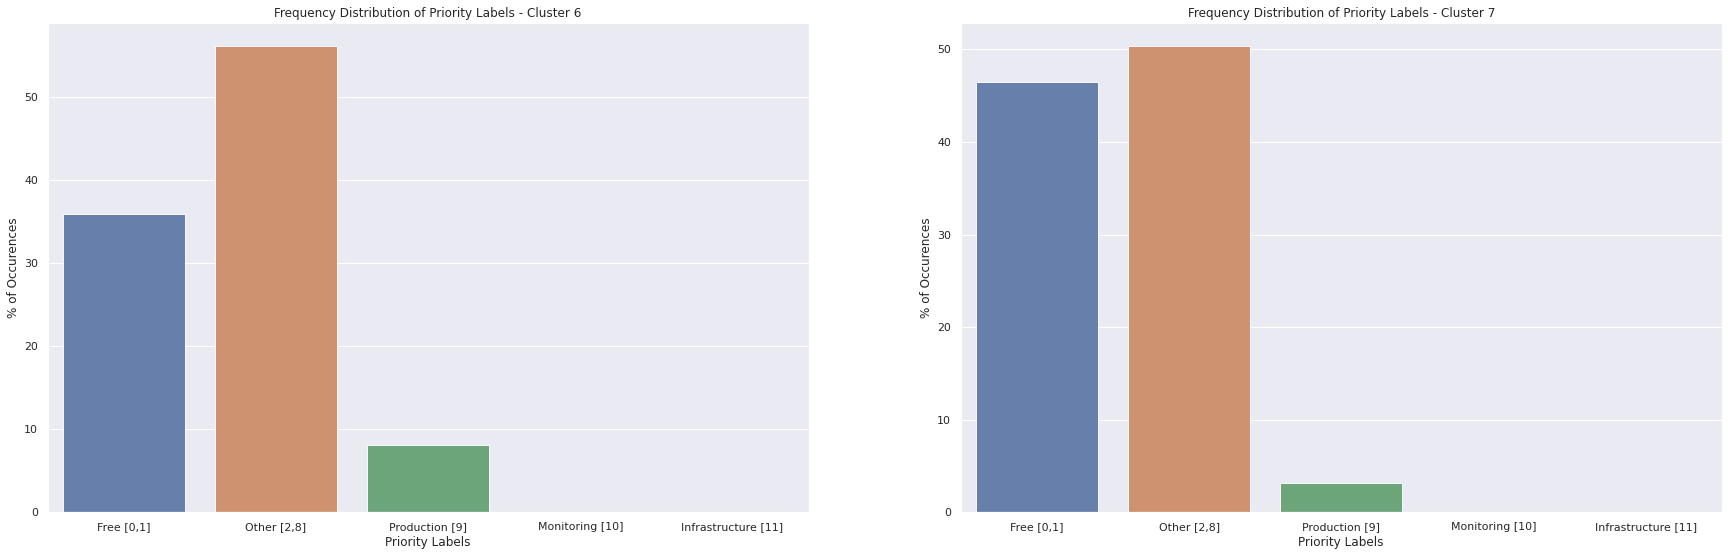

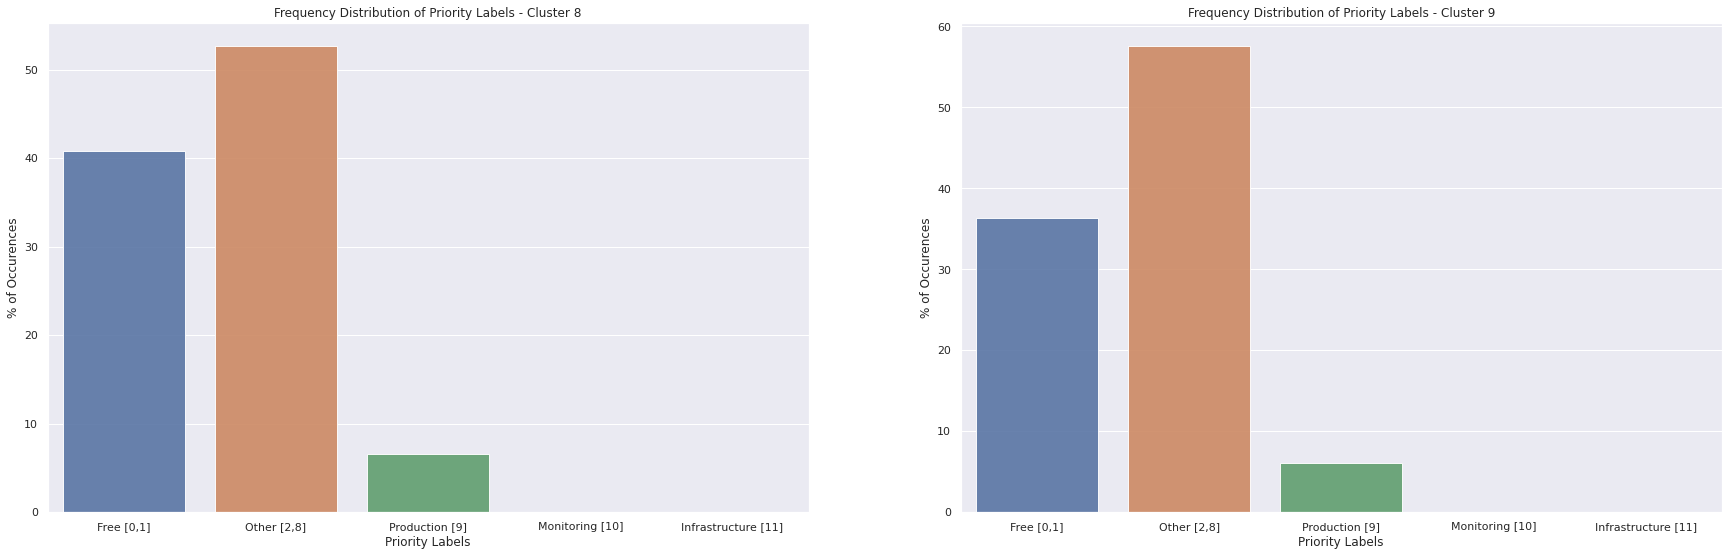

In [344]:
cluster_labels = cluster_labels_10
label = "priority labels"
priority_labels = ["Free [0,1]", "Other [2,8]", "Production [9]", "Monitoring [10]", "Infrastructure [11]"]

for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts()
        for pr_lab in priority_labels:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(priority_labels)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Freqency distribution for different machines restriction

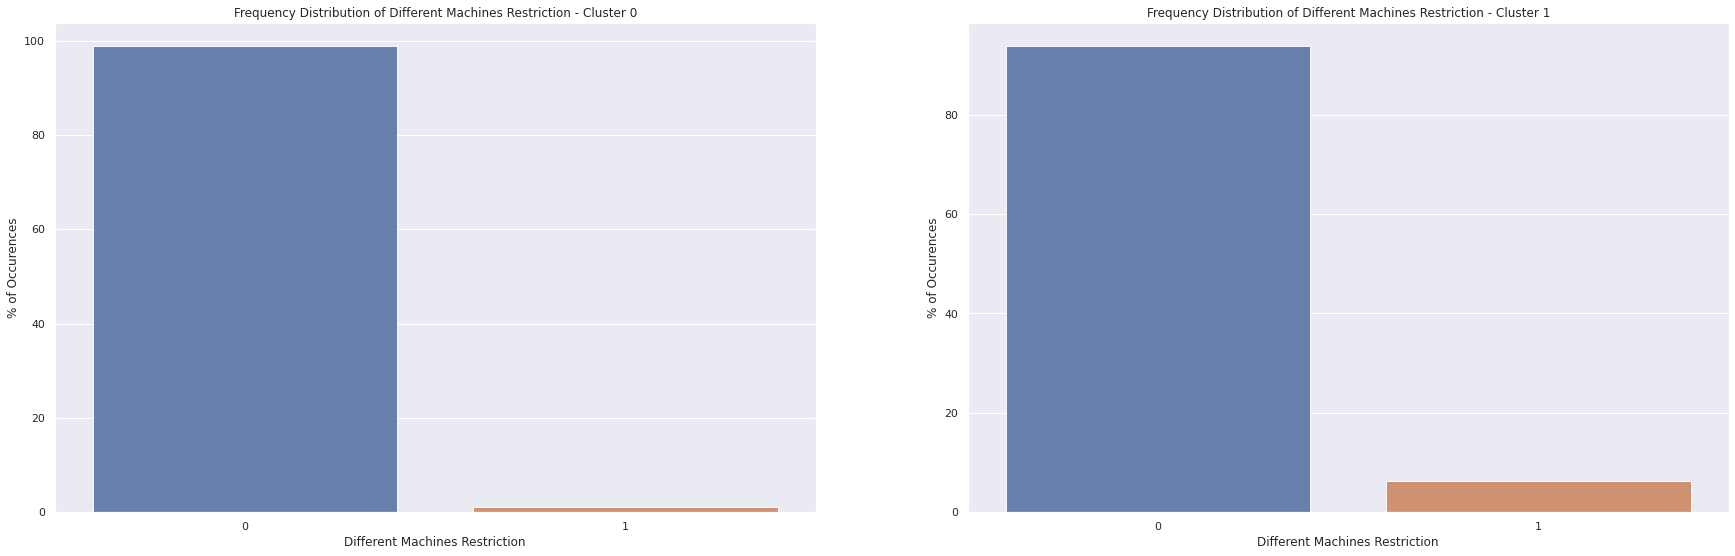

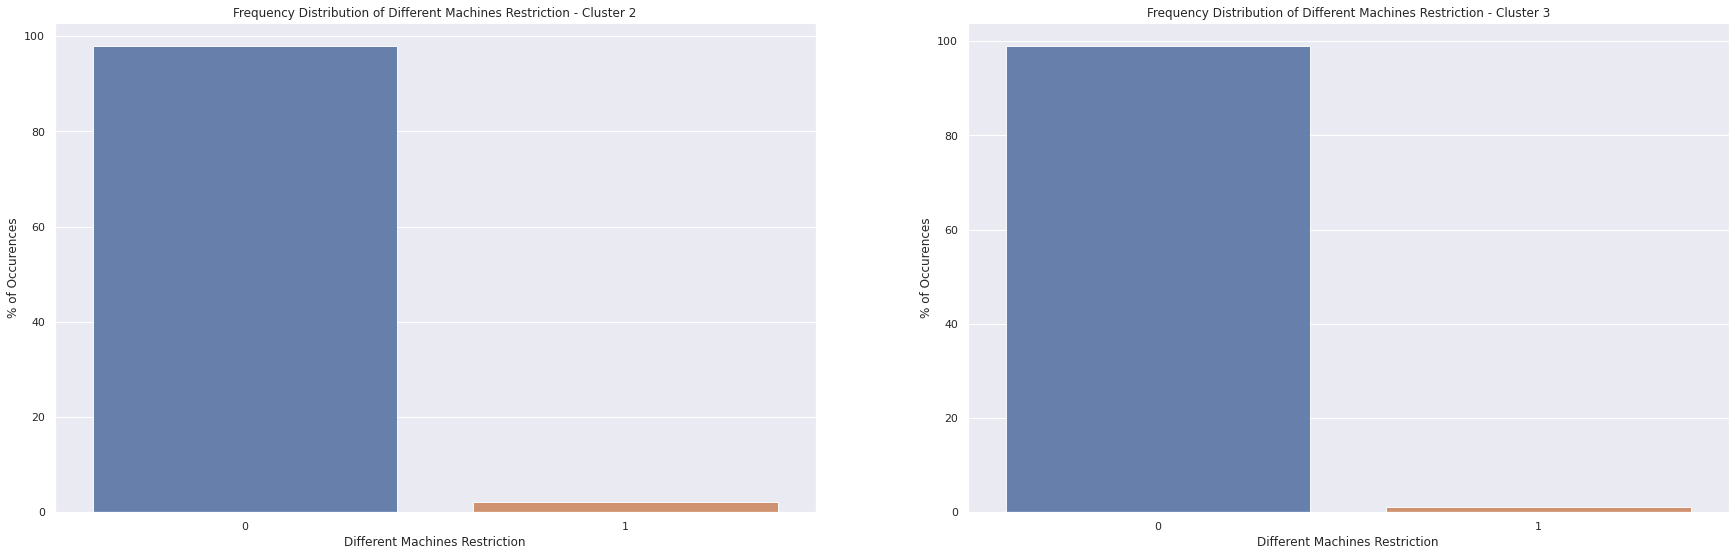

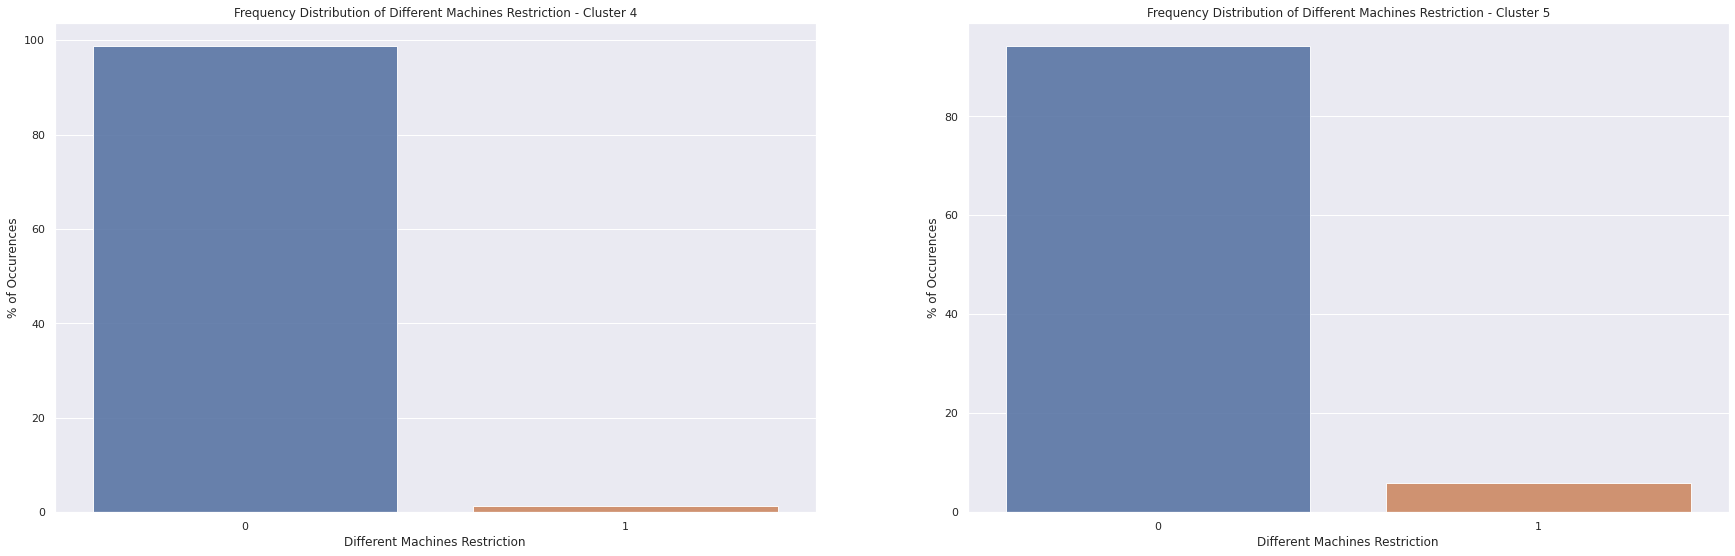

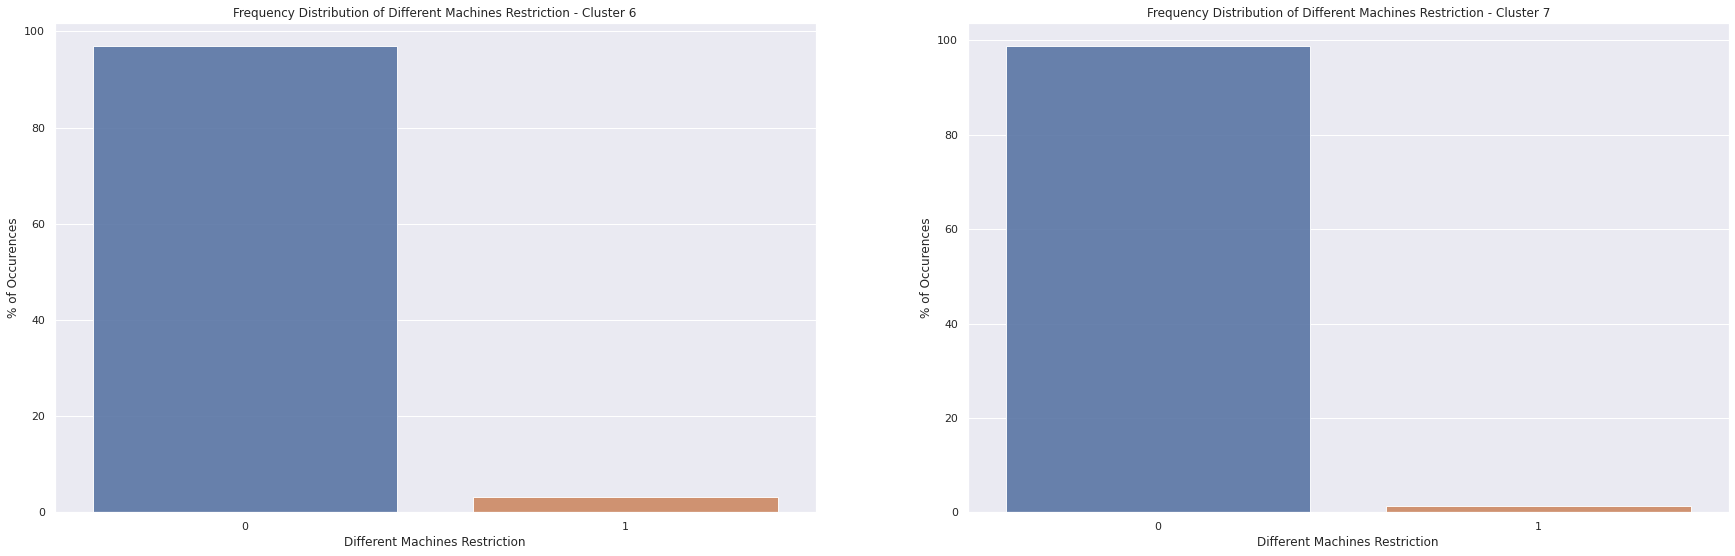

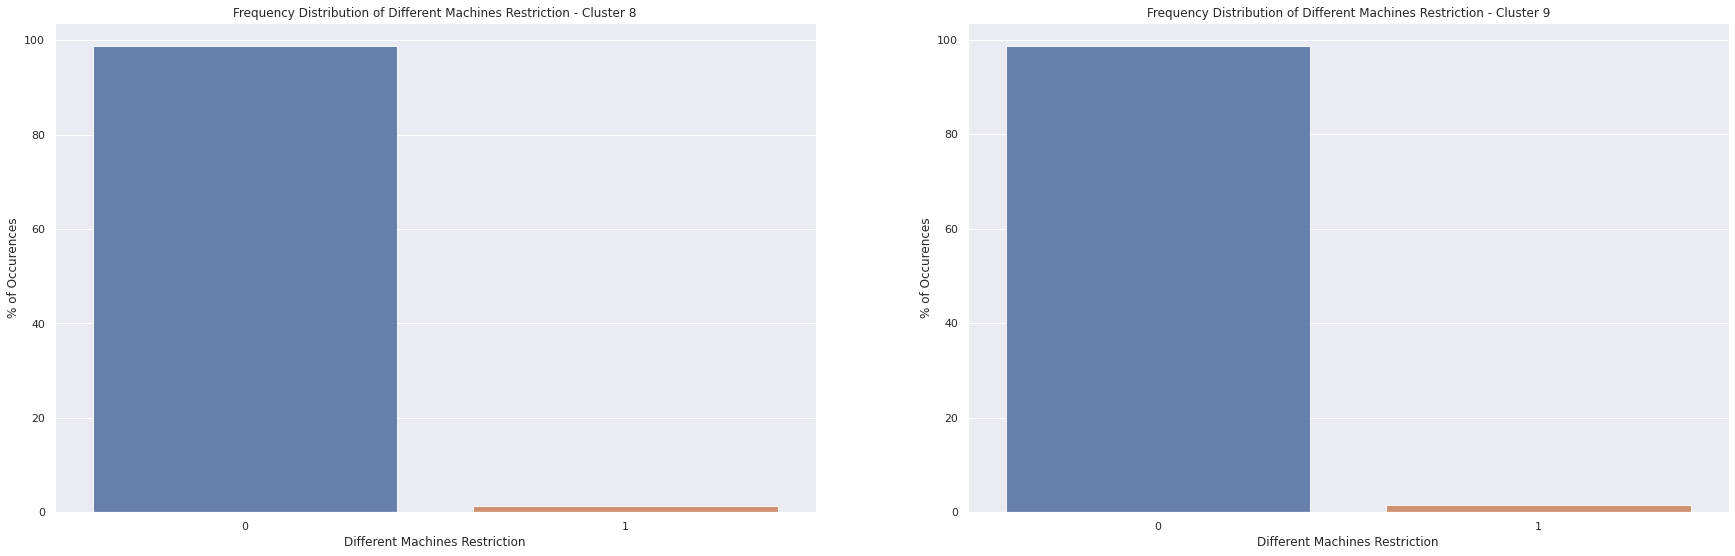

In [345]:
cluster_labels = cluster_labels_10
label = "different machines restriction"

for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in range(0,2):
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for disk request - quartiles

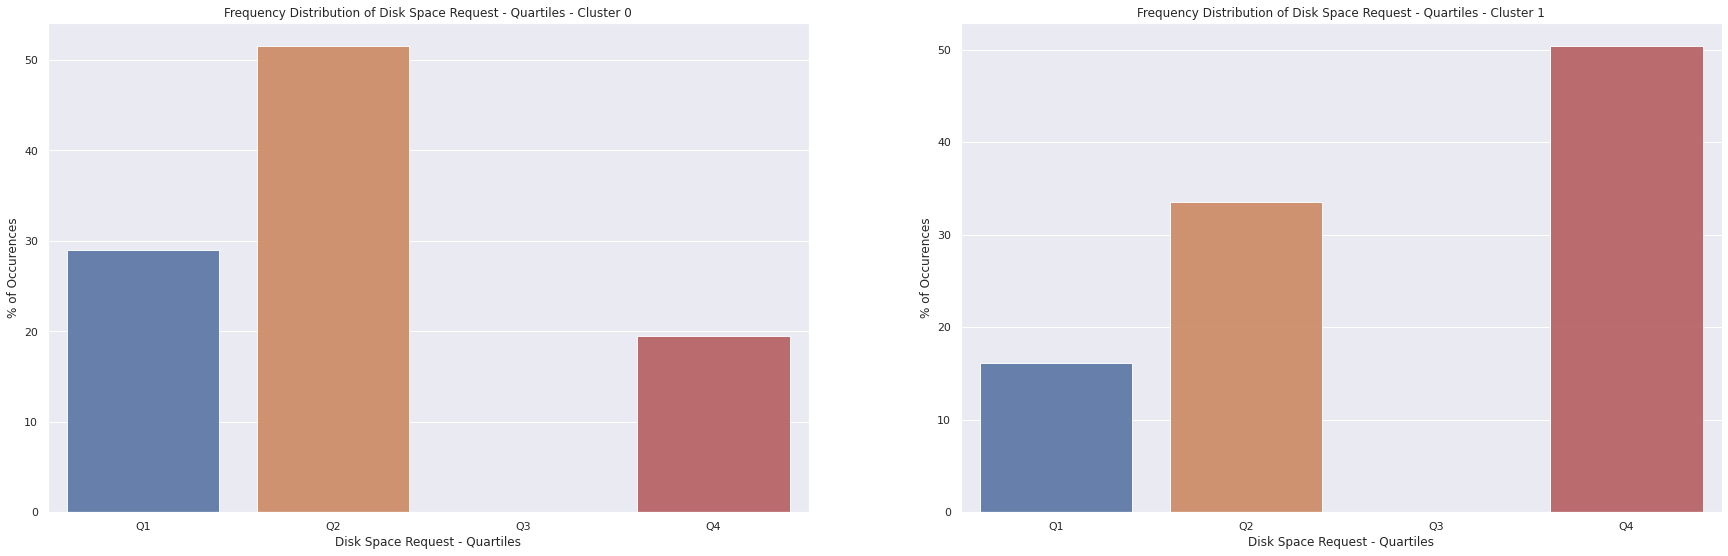

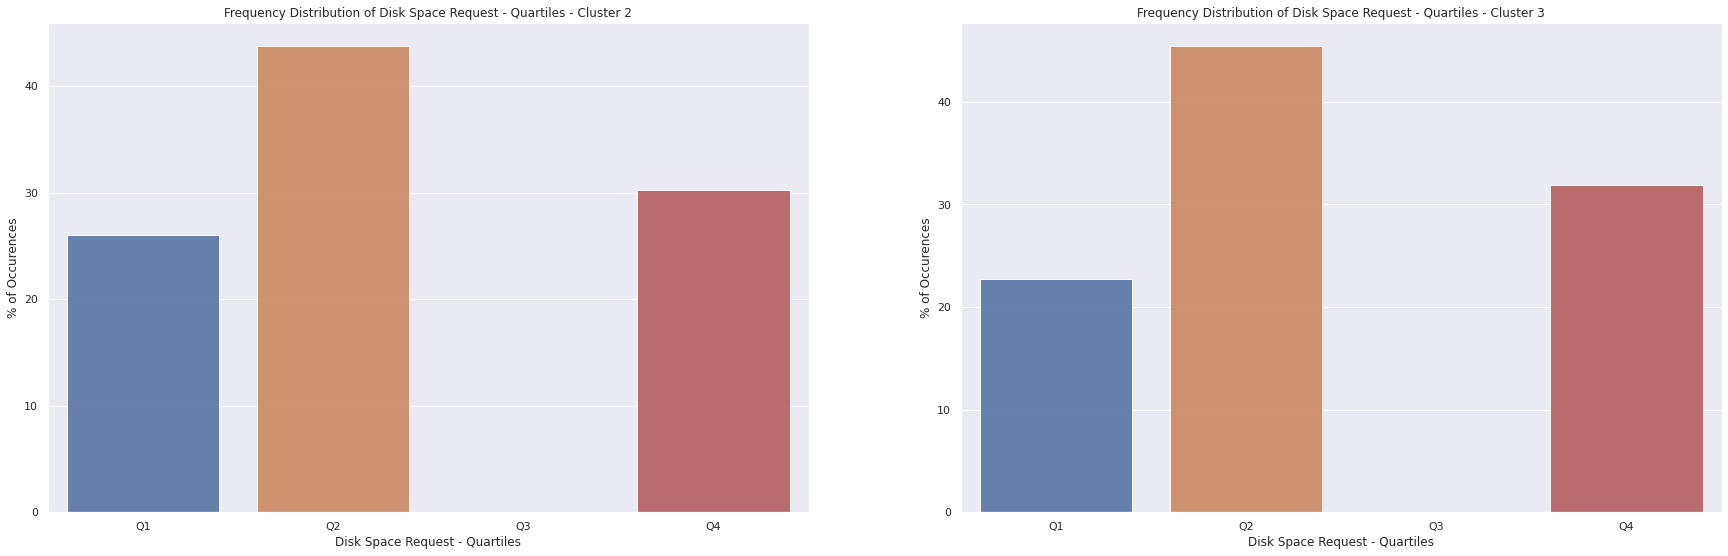

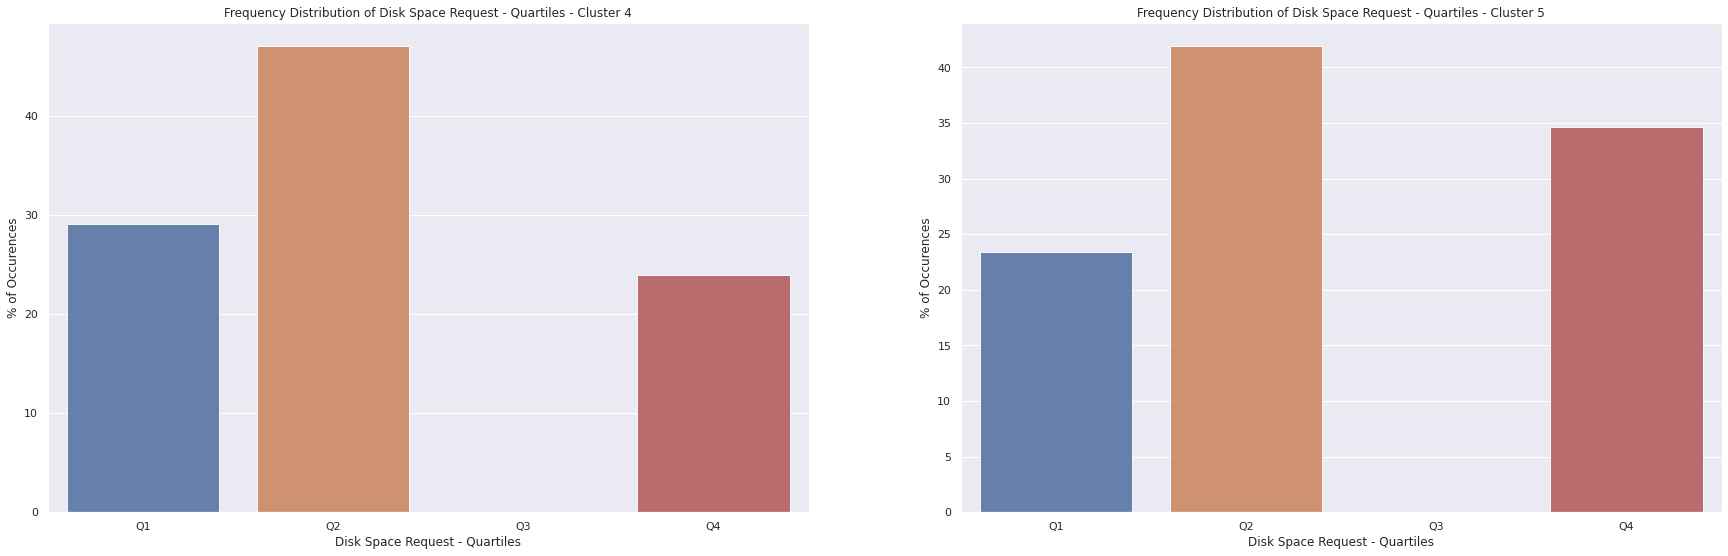

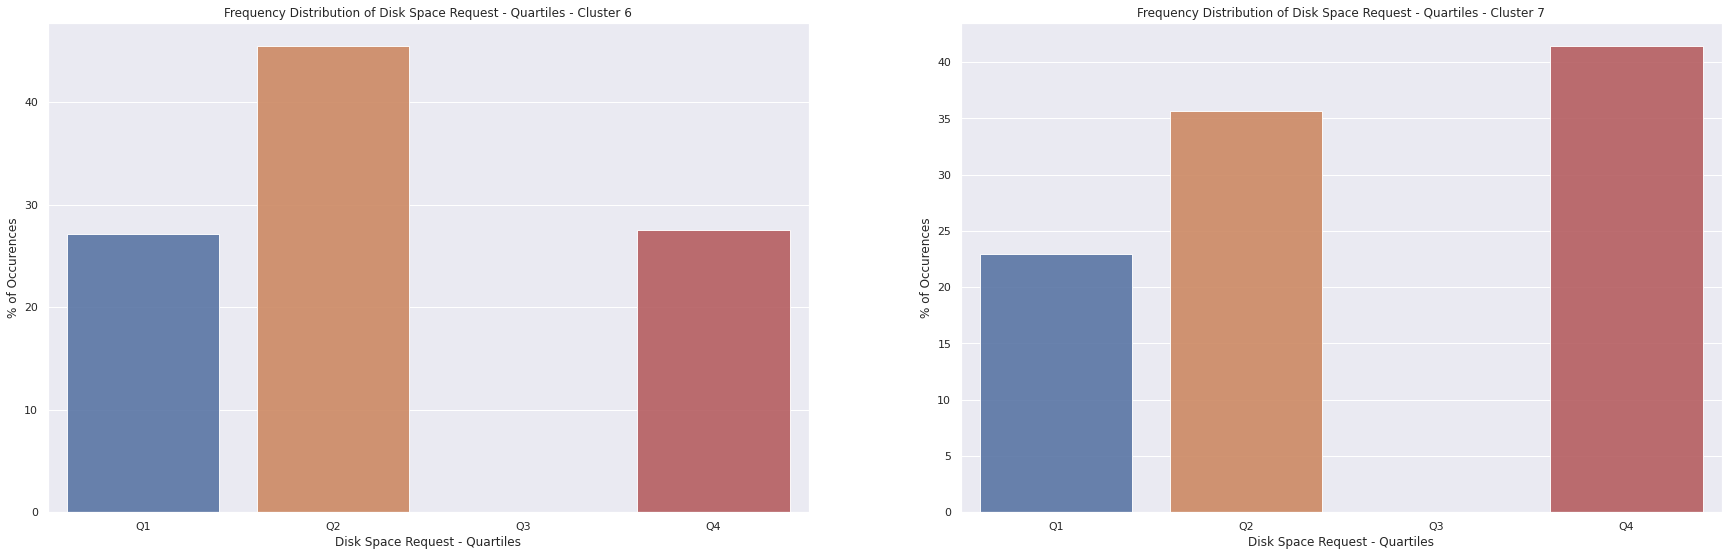

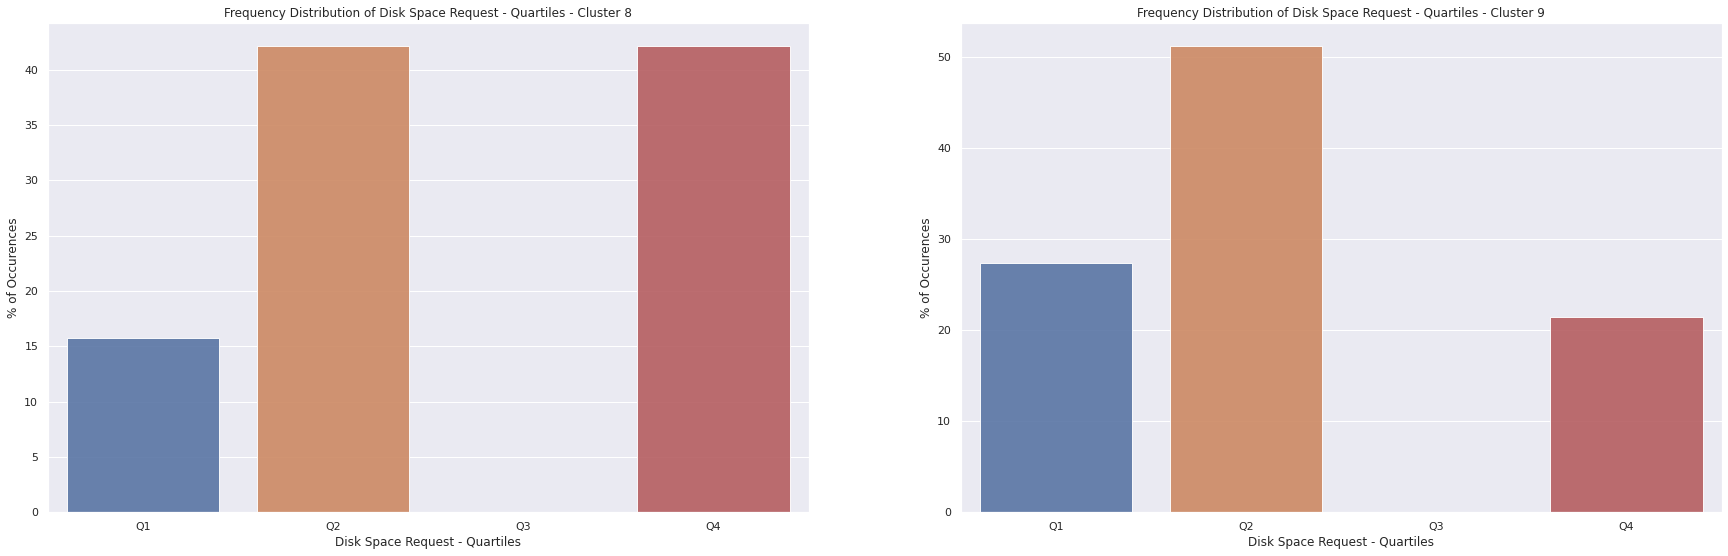

In [346]:
cluster_labels = cluster_labels_10
label = "disk space request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for memory request - quartiles

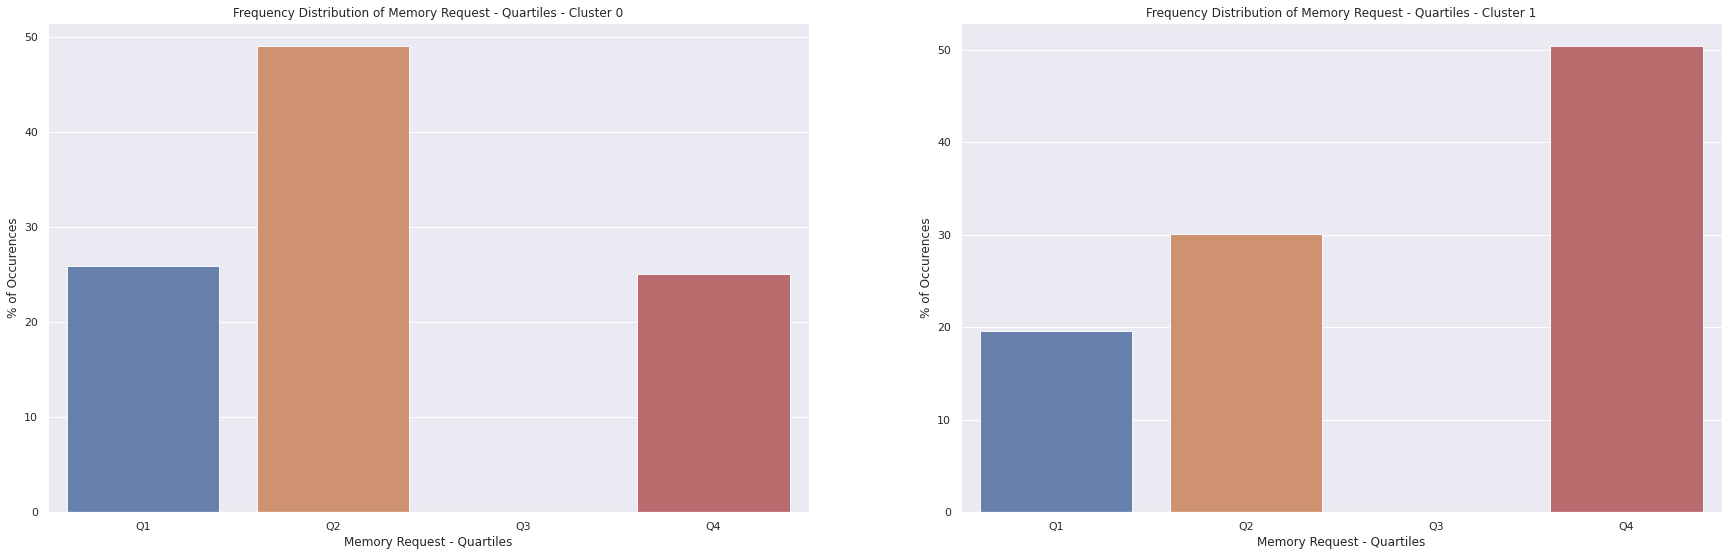

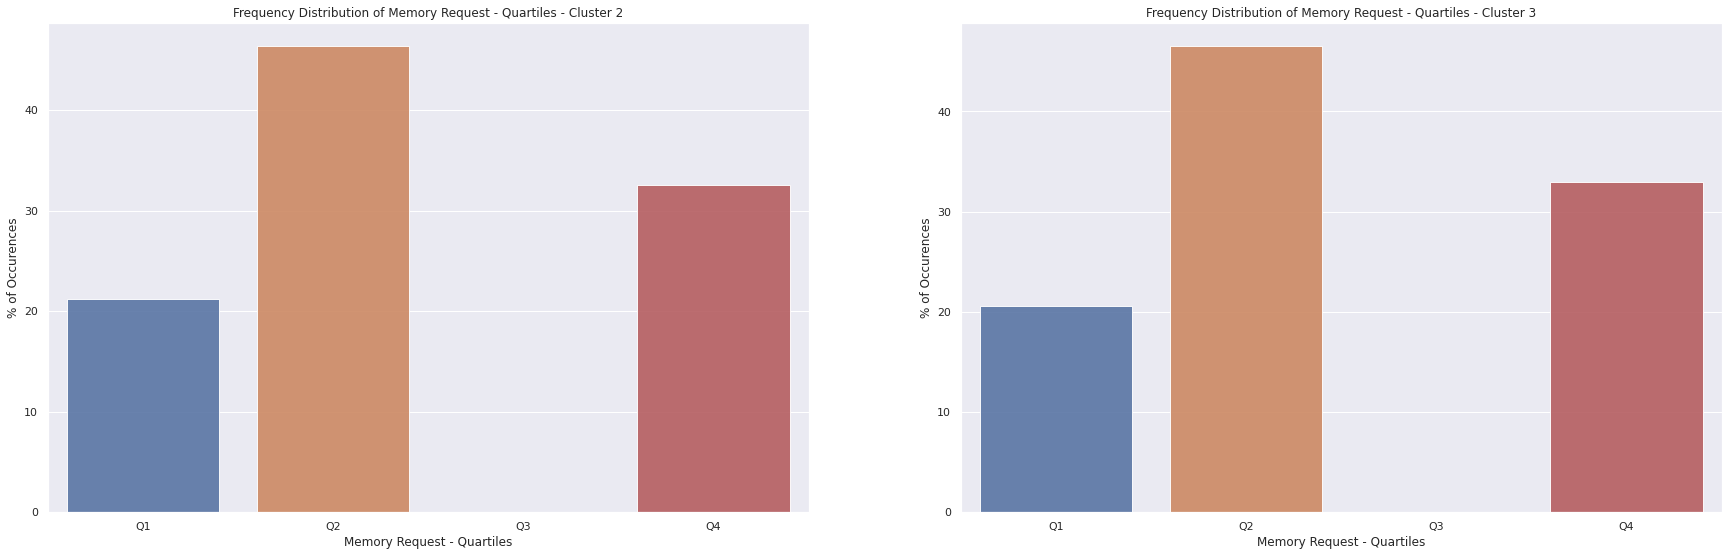

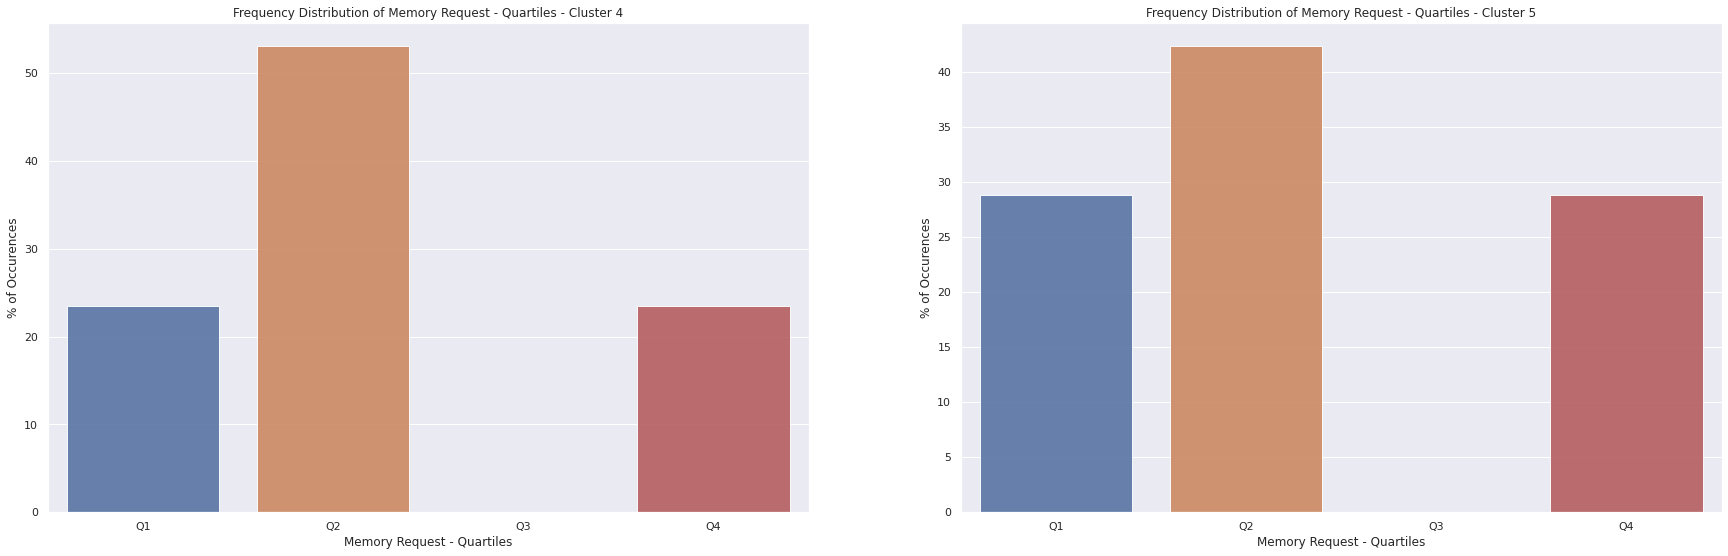

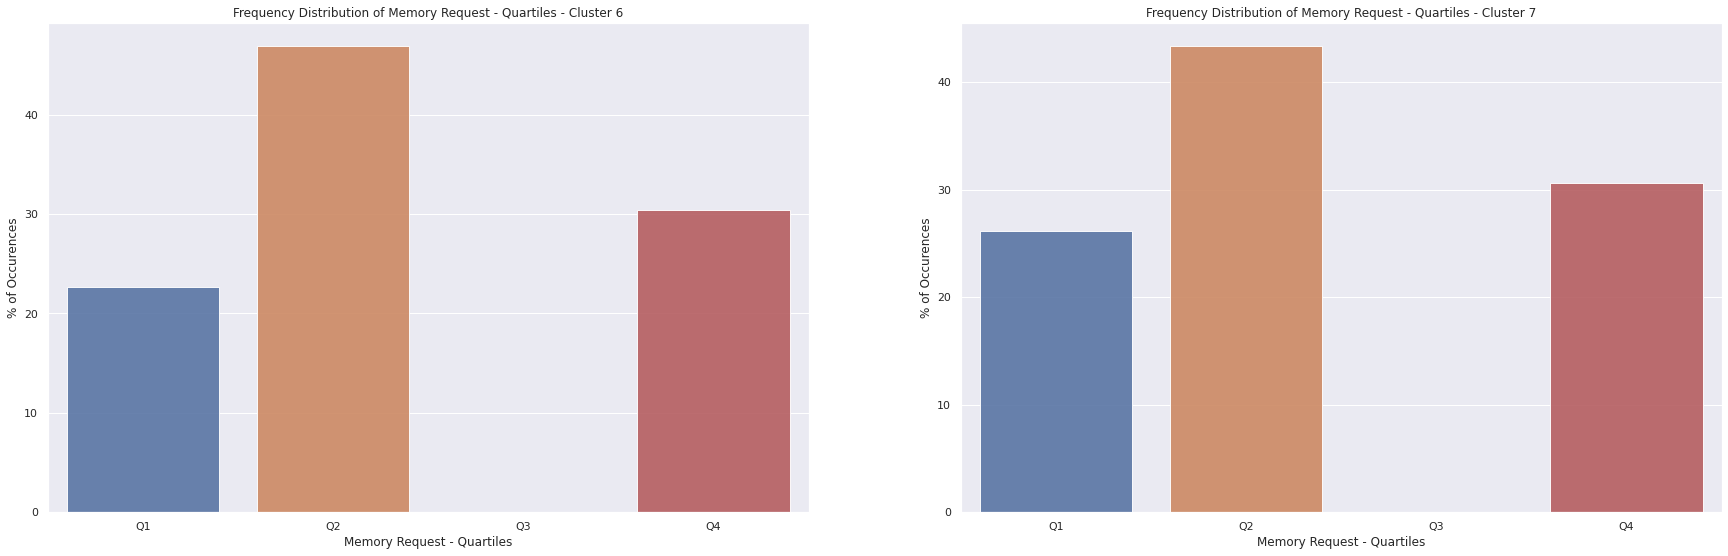

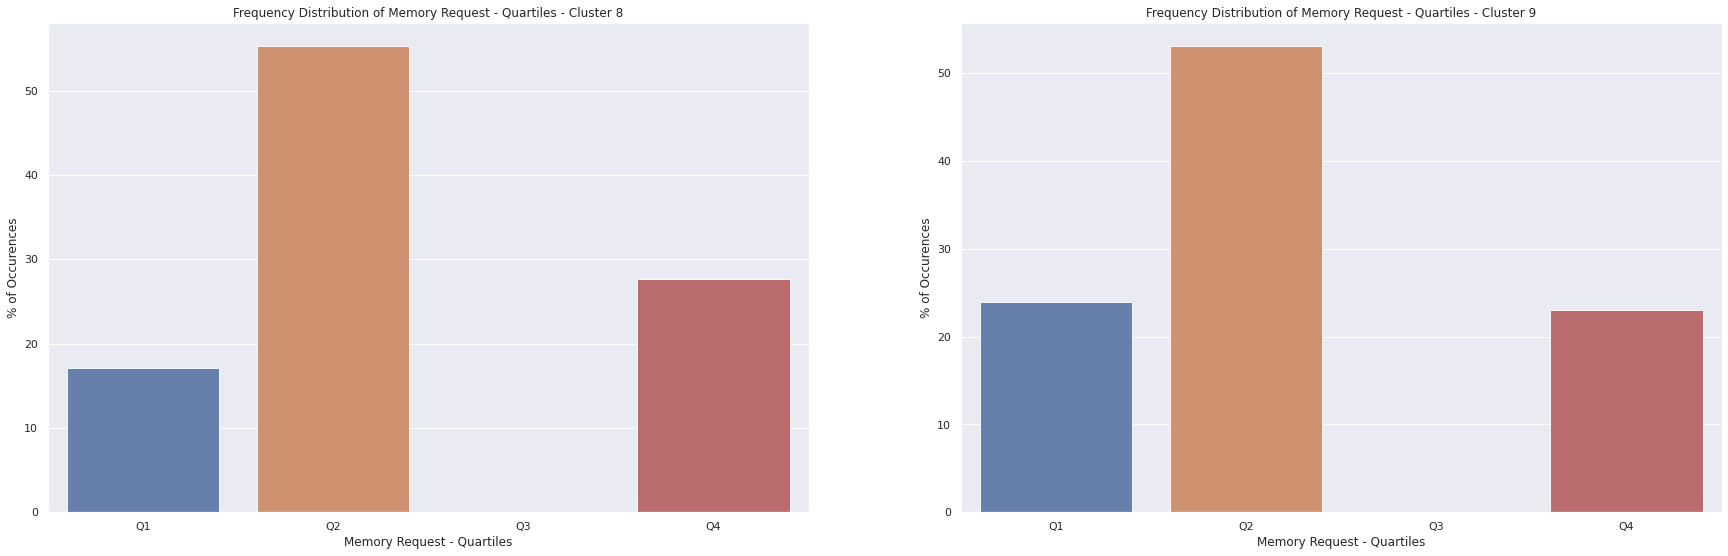

In [347]:
cluster_labels = cluster_labels_10
label = "memory request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

#### Frequency distribution for CPU request - quartiles

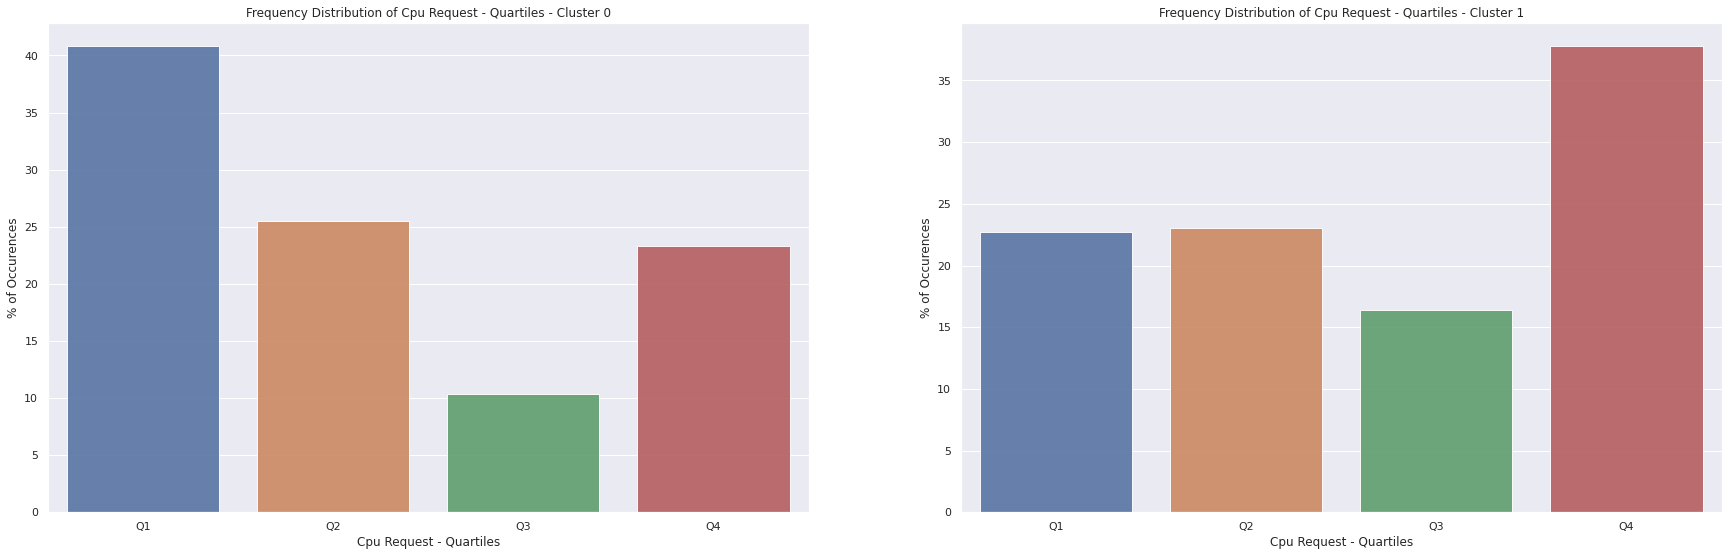

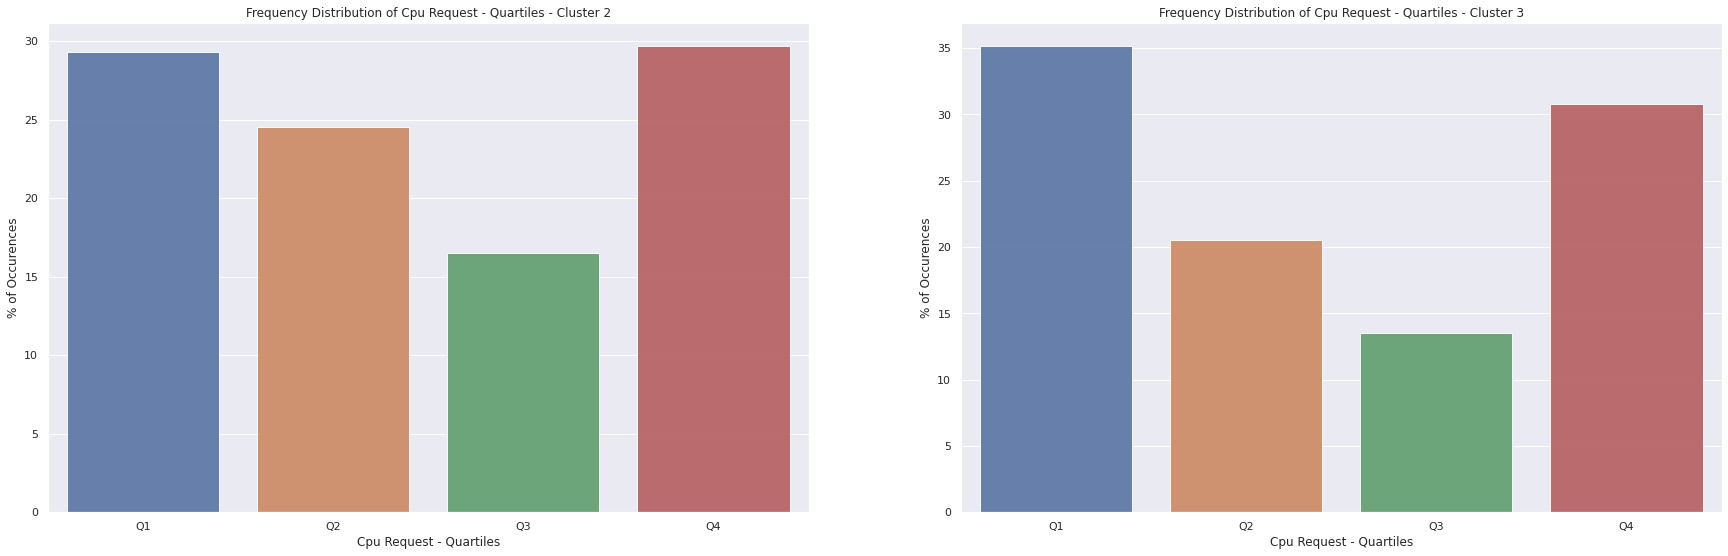

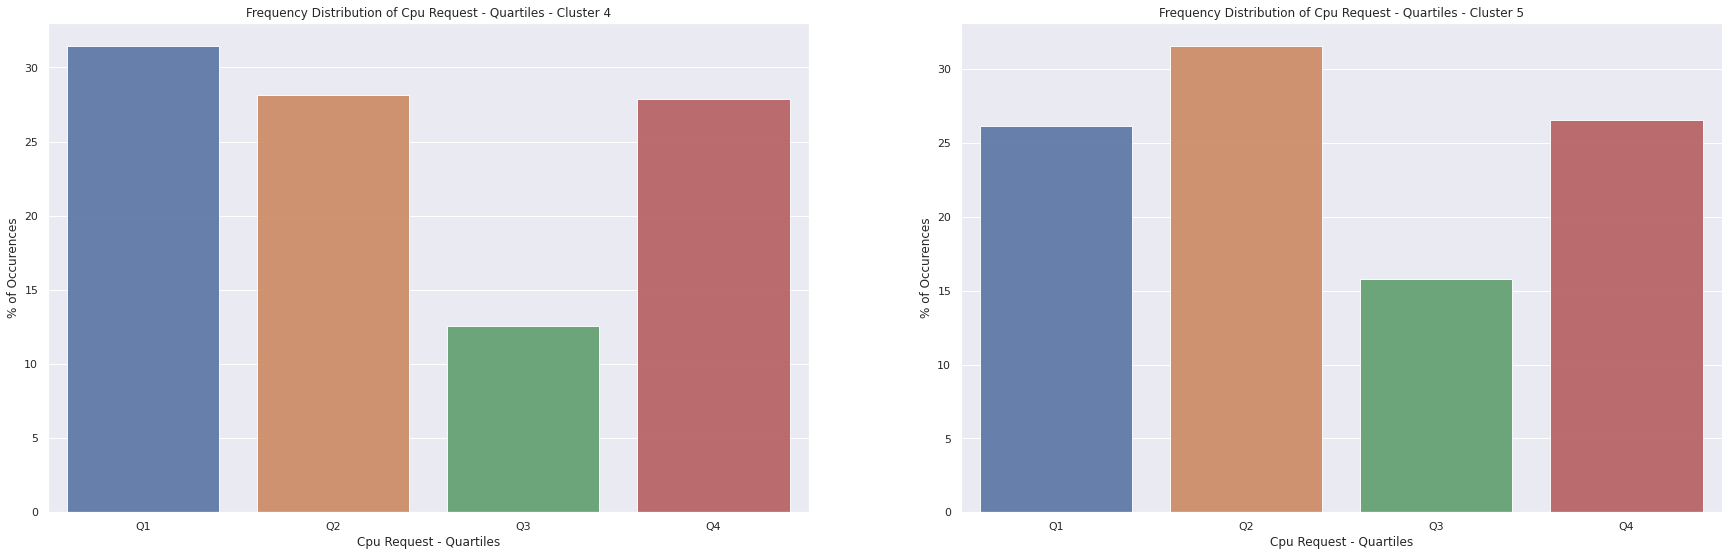

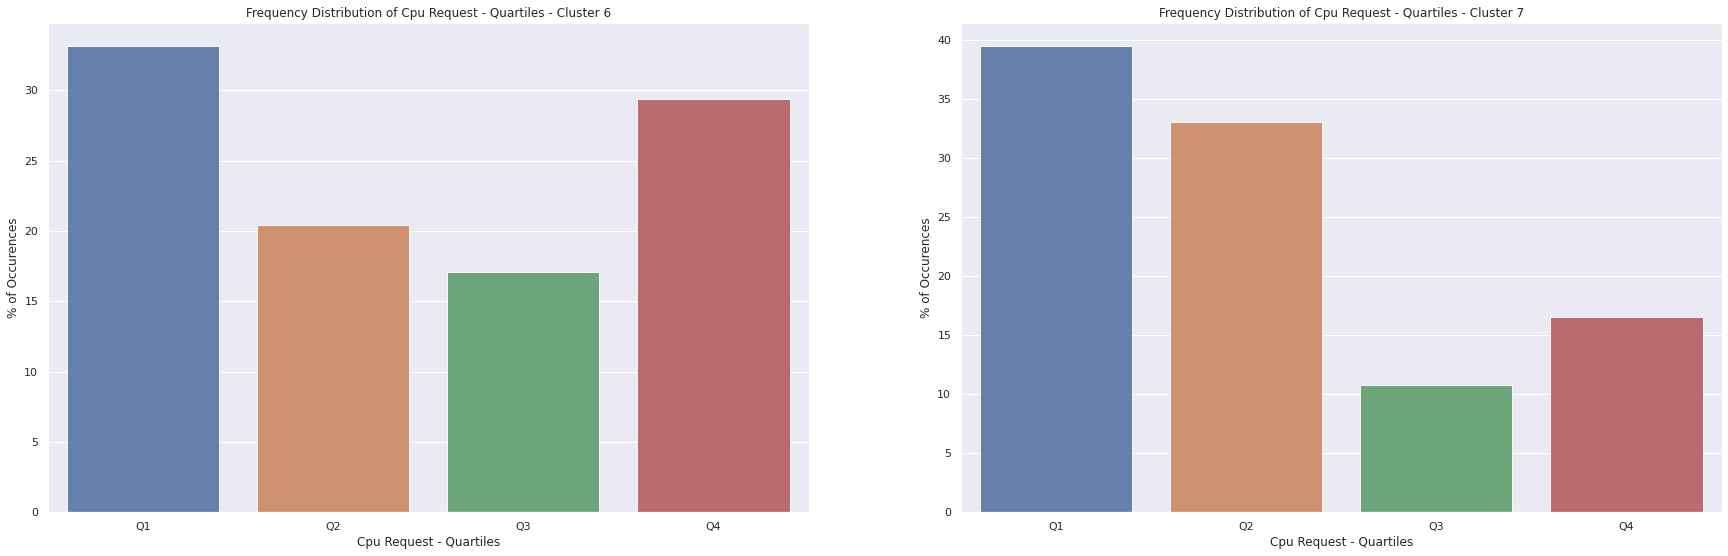

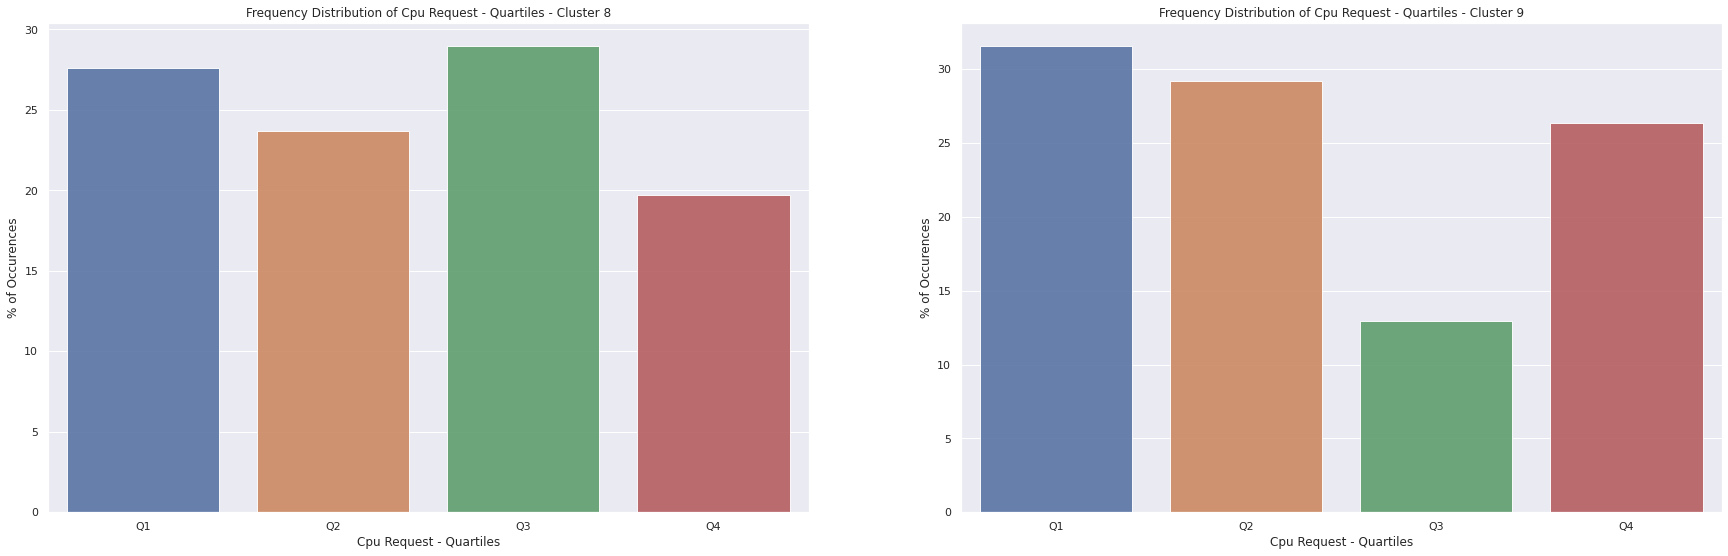

In [348]:
cluster_labels = cluster_labels_10
label = "CPU request - Quartiles"
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(0, 10, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 9)
    axes=[ax1, ax2]
    for j in range(2):
        column_count = static_metrics[cluster_labels == i+j][label].value_counts().sort_values(ascending=False)
        for pr_lab in quartiles:
            if pr_lab not in column_count.index:
                s = pd.Series([0], index=[pr_lab])
                column_count = column_count.append(s)
        column_count = column_count.reindex(quartiles)
        sns.set(style="darkgrid")
        sns.barplot(column_count.index, column_count.values  / len(static_metrics[cluster_labels == i+j]) * 100, alpha=0.9, ax=axes[j])
        axes[j].set_title(f'Frequency Distribution of {label.title()} - Cluster {i+j}')
        axes[j].set_ylabel('% of Occurences', fontsize=12)
        axes[j].set_xlabel(f'{label.title()}', fontsize=12)

## Finalizing static features df

In [921]:
static_metrics['K-Means = 2'] = cluster_labels_2
static_metrics['K-Means = 4'] = cluster_labels_4
static_metrics['K-Means = 6'] = cluster_labels_6
static_metrics['K-Means = 8'] = cluster_labels_8
static_metrics['K-Means = 10'] = cluster_labels_10
static_metrics

priority  different machines restriction  disk space request - Q1  \
job ID                                                                          
3418309            9                               0                        0   
3418329            9                               0                        0   
3418334            9                               0                        0   
6590391            9                               0                        0   
6933059           10                               0                        0   
...              ...                             ...                      ...   
6486577243         0                               0                        0   
6486605021         1                               0                        0   
6486606105         4                               1                        0   
6486612710         4                               0                        0   
6486624675         1                               0                        0   

            disk space request - Q2  disk space request - Q3  \
job ID                                                         
3418309                           0                        0   
3418329                           0                        0   
3418334                           0                        0   
6590391                           0                        0   
6933059                           0                        0   
...                             ...                      ...   
6486577243                        1                        0   
6486605021                        1                        0   
6486606105                        0                        0   
6486612710                        0                        0   
6486624675                        1                        0   

            disk space request - Q4  memory request - Q1  memory request - Q2  \
job ID                                                                          
3418309                           1                    0                    0   
3418329                           1                    0                    0   
3418334                           1                    0                    0   
6590391                           1                    0                    0   
6933059                           1                    0                    0   
...                             ...                  ...                  ...   
6486577243                        0                    0                    0   
6486605021                        0                    0                    0   
6486606105                        1                    0                    0   
6486612710                        1                    0                    0   
6486624675                        0                    0                    0   

            memory request - Q3  memory request - Q4  ...  \
job ID                                                ...   
3418309                       0                    1  ...   
3418329                       0                    1  ...   
3418334                       0                    1  ...   
6590391                       0                    1  ...   
6933059                       0                    1  ...   
...                         ...                  ...  ...   
6486577243                    1                    0  ...   
6486605021                    1                    0  ...   
6486606105                    0                    1  ...   
6486612710                    0                    1  ...   
6486624675                    1                    0  ...   

            CPU request - Quartiles  priority labels  \
job ID                                                 
3418309                          Q4   Production [9]   
3418329                          Q4   Production [9]   
3418334                          Q4   Production [9] 

In [823]:
static_metrics.to_csv('data/static_metrics_and_kmeans.csv')

## Summarizing static features

In [922]:
priority_vector=["Free [0,1]", "Other [2,8]", "Production [9]", "Monitoring [10]", "Infrastructure [11]"]
static_metrics['priority labels'] = pd.Categorical(static_metrics['priority labels'], categories=priority_vector)
#static_metrics['CPU request - Quartiles'] = pd.Categorical(static_metrics['CPU request - Quartiles'], categories=['Q1', 'Q2', 'Q3', 'Q4'])
#static_metrics['memory request - Quartiles'] = pd.Categorical(static_metrics['memory request - Quartiles'], categories=['Q1', 'Q2', 'Q3', 'Q4'])
#static_metrics['disk space request - Quartiles'] = pd.Categorical(static_metrics['disk space request - Quartiles'], categories=['Q1', 'Q2', 'Q3', 'Q4'])


In [923]:
static_metrics

priority  different machines restriction  disk space request - Q1  \
job ID                                                                          
3418309            9                               0                        0   
3418329            9                               0                        0   
3418334            9                               0                        0   
6590391            9                               0                        0   
6933059           10                               0                        0   
...              ...                             ...                      ...   
6486577243         0                               0                        0   
6486605021         1                               0                        0   
6486606105         4                               1                        0   
6486612710         4                               0                        0   
6486624675         1                               0                        0   

            disk space request - Q2  disk space request - Q3  \
job ID                                                         
3418309                           0                        0   
3418329                           0                        0   
3418334                           0                        0   
6590391                           0                        0   
6933059                           0                        0   
...                             ...                      ...   
6486577243                        1                        0   
6486605021                        1                        0   
6486606105                        0                        0   
6486612710                        0                        0   
6486624675                        1                        0   

            disk space request - Q4  memory request - Q1  memory request - Q2  \
job ID                                                                          
3418309                           1                    0                    0   
3418329                           1                    0                    0   
3418334                           1                    0                    0   
6590391                           1                    0                    0   
6933059                           1                    0                    0   
...                             ...                  ...                  ...   
6486577243                        0                    0                    0   
6486605021                        0                    0                    0   
6486606105                        1                    0                    0   
6486612710                        1                    0                    0   
6486624675                        0                    0                    0   

            memory request - Q3  memory request - Q4  ...  \
job ID                                                ...   
3418309                       0                    1  ...   
3418329                       0                    1  ...   
3418334                       0                    1  ...   
6590391                       0                    1  ...   
6933059                       0                    1  ...   
...                         ...                  ...  ...   
6486577243                    1                    0  ...   
6486605021                    1                    0  ...   
6486606105                    0                    1  ...   
6486612710                    0                    1  ...   
6486624675                    1                    0  ...   

            CPU request - Quartiles  priority labels  \
job ID                                                 
3418309                          Q4   Production [9]   
3418329                          Q4   Production [9]   
3418334                          Q4   Production [9] 

### Priority

<Figure size 1080x576 with 0 Axes>

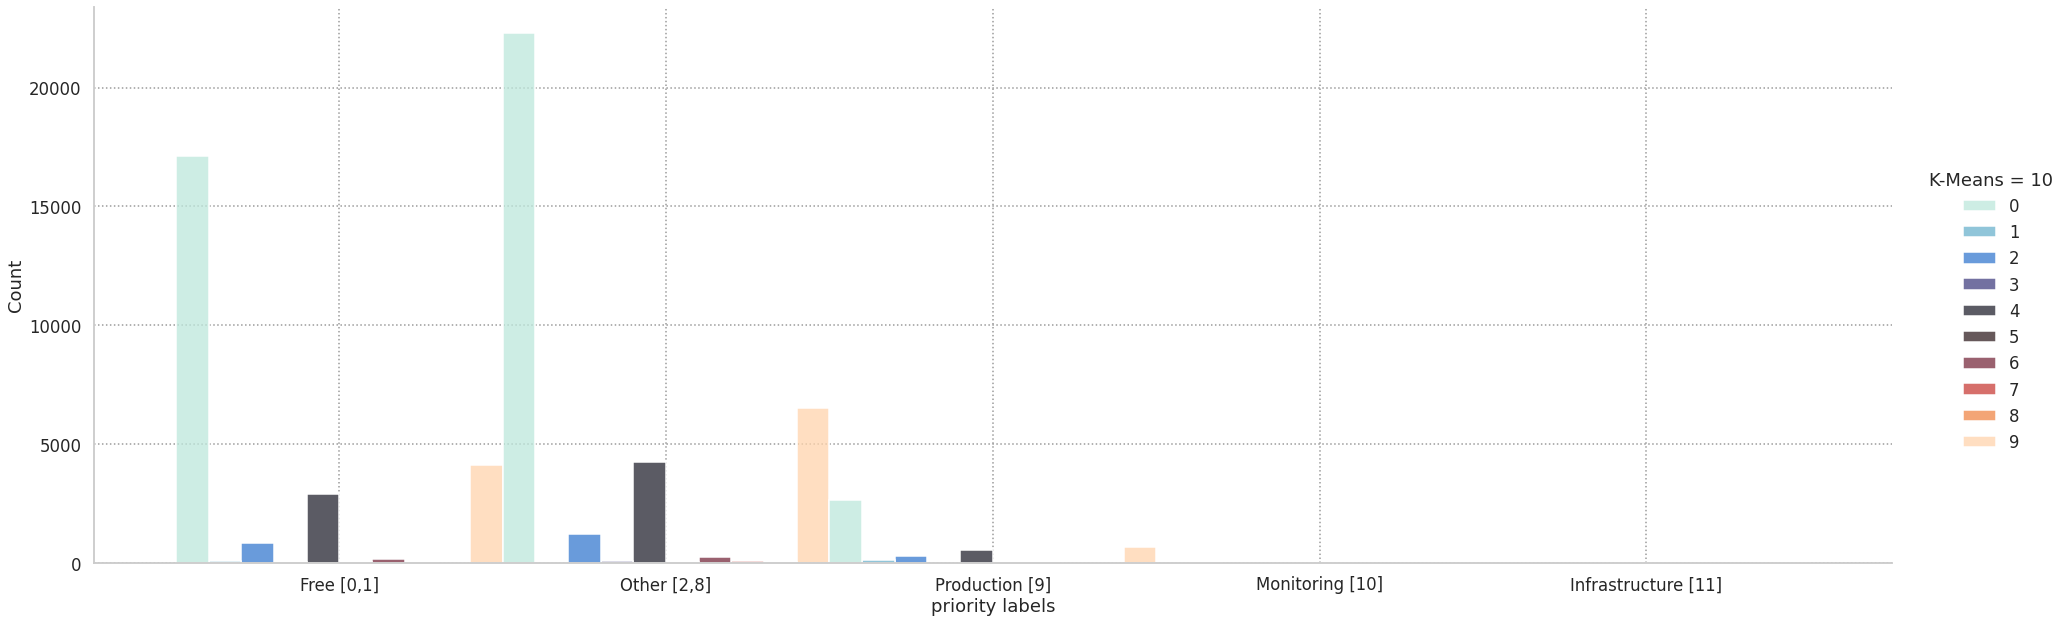

In [836]:
import matplotlib.ticker as ticker

plt.figure(figsize=(15,8))
sns.displot(static_metrics, x="priority labels", hue="K-Means = 10", height=9, aspect=3, palette="icefire", multiple="dodge")
#plt.yscale("log")
#tick_spacing=1
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

<AxesSubplot:xlabel='priority labels', ylabel='proportion'>

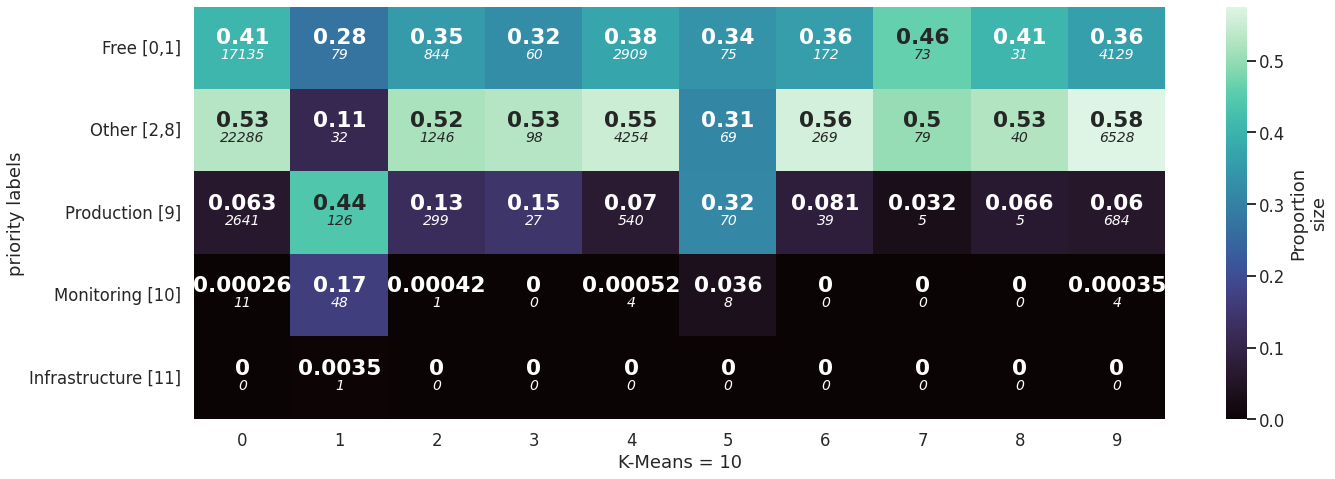

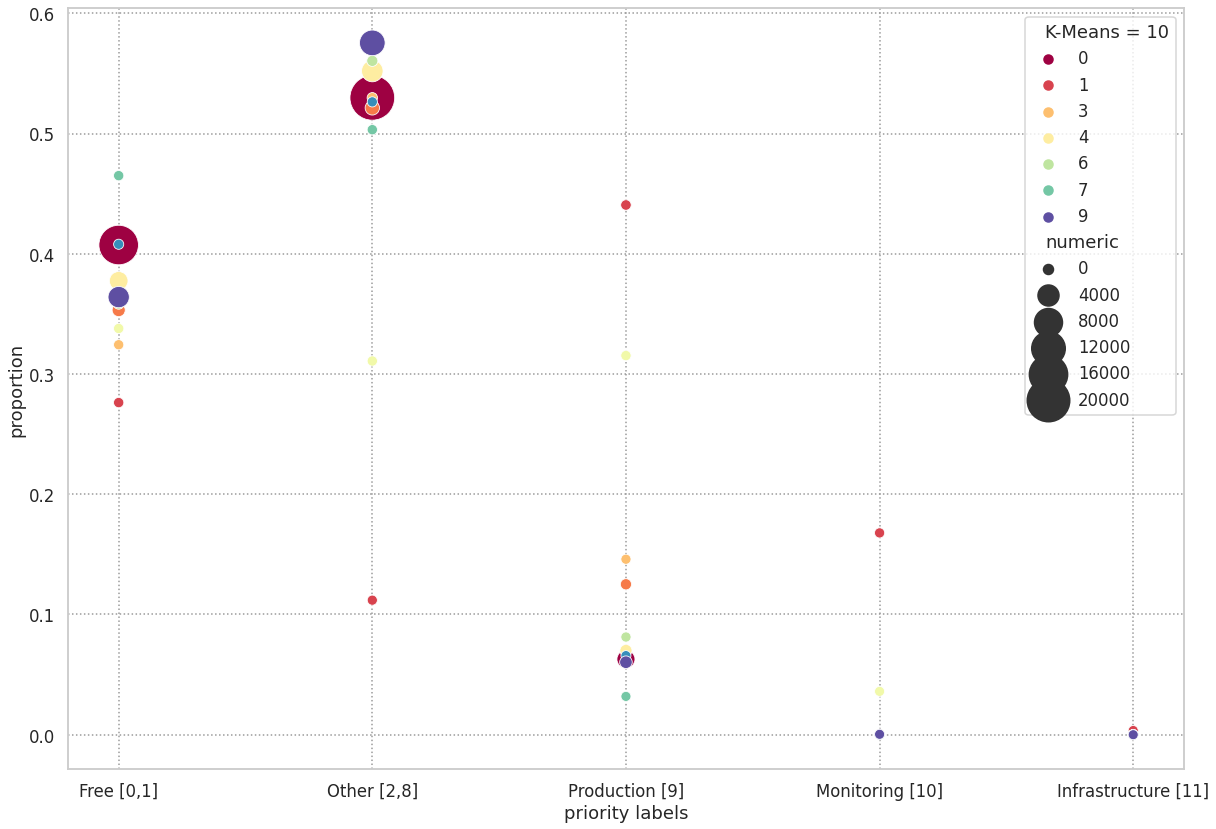

In [870]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 10"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 10", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 10", "priority count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k10.svg')

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_perc, annot=True, cmap="mako")
x = heatmap_df_perc.unstack()
x = x.to_frame()
x.reset_index(inplace=True)
x.columns = ["K-Means = 10", "priority labels", "proportion"]

x2=heatmap_df_total.unstack()
x2 = x2.to_frame()
x2.reset_index(inplace=True)
x2 = x2[x2["K-Means = 10"] != "total"]
x2.columns = ["K-Means = 10", "priority labels", "numeric"]
x["numeric"] = x2["numeric"].values


plt.figure(figsize=(20,14))
sns.scatterplot(
    data=x, x="priority labels", y="proportion", hue="K-Means = 10", size="numeric", units="K-Means = 10",
    sizes=(100, 2000),
    legend="auto",
    palette="Spectral"
)
#plt.plot(x["priority labels"], x["proportion"], lw=0.5, linestyle=":")

#g = sns.FacetGrid(x, hue="K-Means = 10", height=9, aspect=2)
#g.map_dataframe(sns.scatterplot, "priority labels", "proportion", size="numeric", sizes=(10, 2000))
#g.map_dataframe(plt.plot, "priority labels", "proportion", lw=0.5, linestyle=":")
#g.add_legend(title="clusters", legend_data= {0: 'r.',1: 'r.',2: 'r.',3: 'r.',4: 'r.',5: 'r.',6: 'r.',7: 'r.',8: 'r.',9: 'r.'})


<AxesSubplot:xlabel='priority labels', ylabel='proportion'>

<Figure size 1440x504 with 0 Axes>

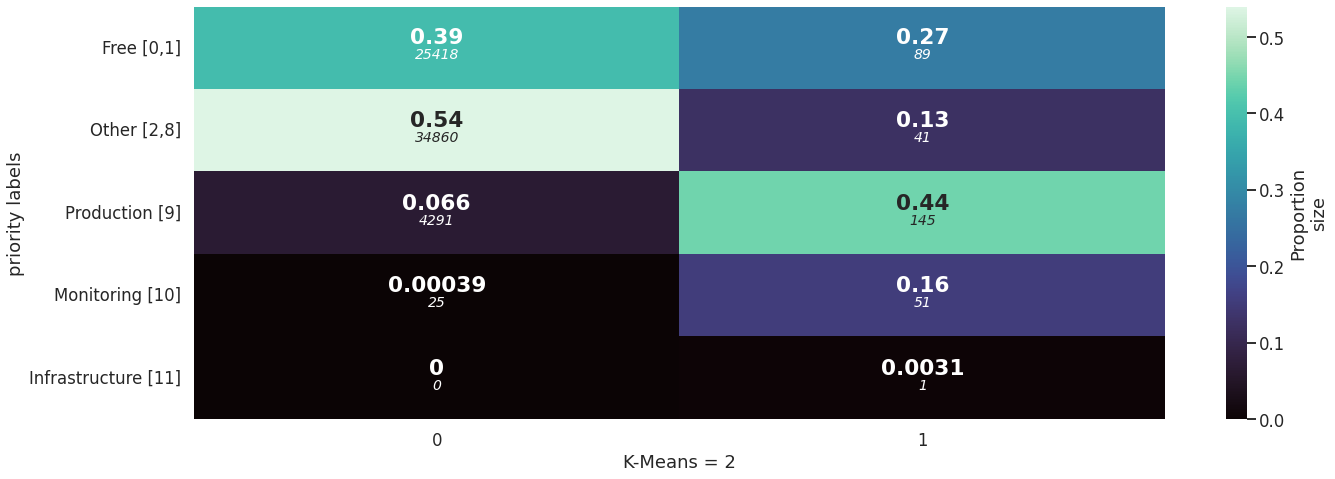

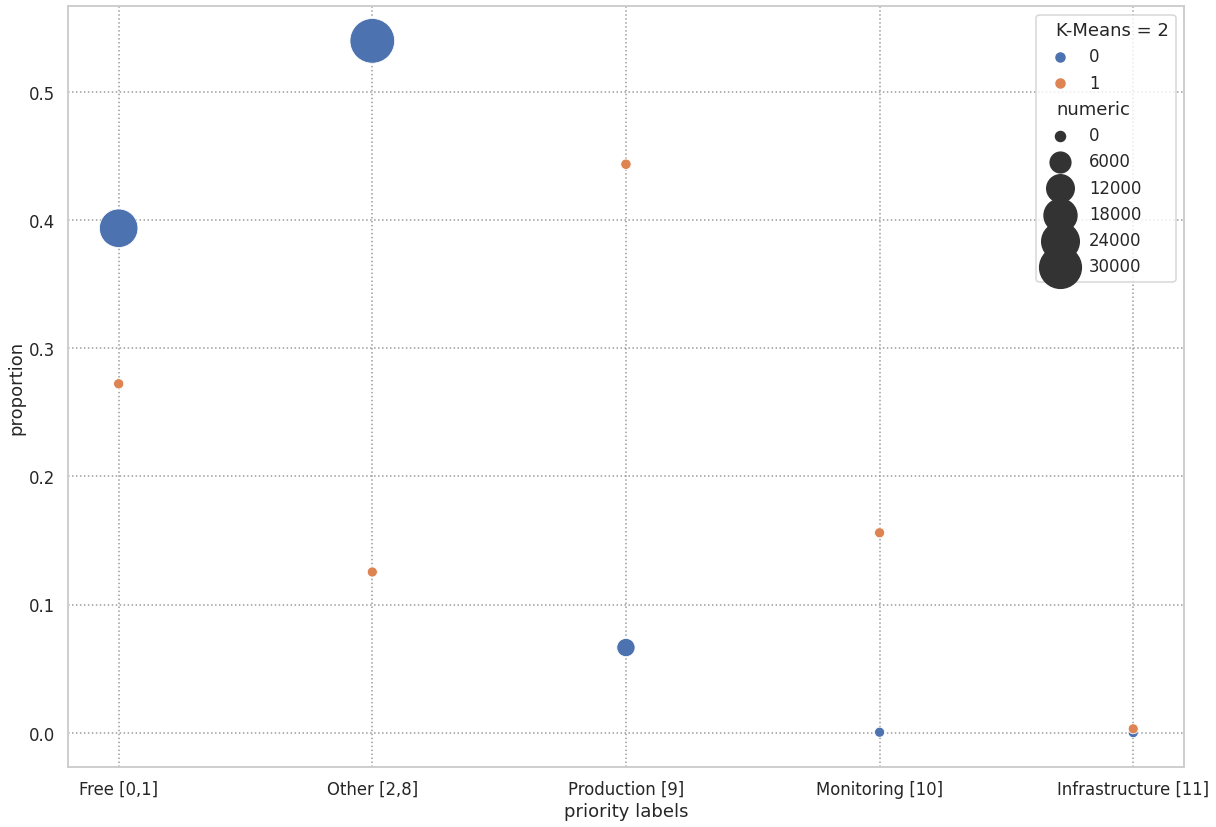

In [859]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 2"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 2", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

plt.figure(figsize=(20,7))

#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 2", "priority count")

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k2.svg')


x = heatmap_df_perc.unstack()
x = x.to_frame()
x.reset_index(inplace=True)
x.columns = ["K-Means = 2", "priority labels", "proportion"]

x2=heatmap_df_total.unstack()
x2 = x2.to_frame()
x2.reset_index(inplace=True)
x2 = x2[x2["K-Means = 2"] != "total"]
x2.columns = ["K-Means = 2", "priority labels", "numeric"]
x["numeric"] = x2["numeric"].values

plt.figure(figsize=(20,14))
sns.scatterplot(
    data=x, x="priority labels", y="proportion", hue="K-Means = 2", size="numeric", units="K-Means = 2",
    sizes=(100, 2000),
    legend="auto",
    #palette="Spectral"
)

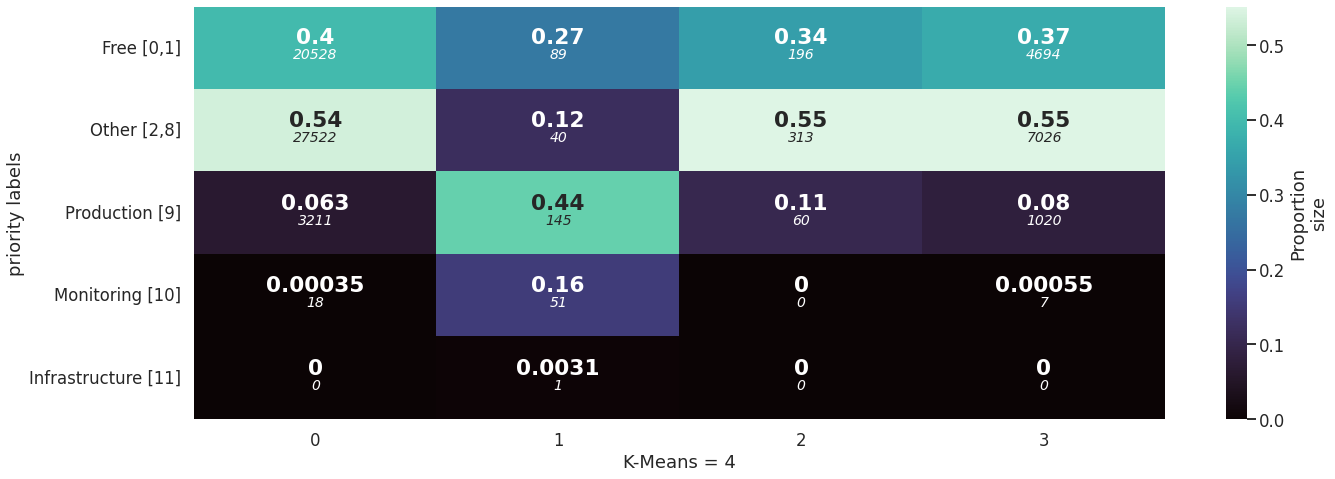

In [862]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 4"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 4", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 4", "priority count")

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k4.svg')


#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_perc, annot=True, cmap="mako")

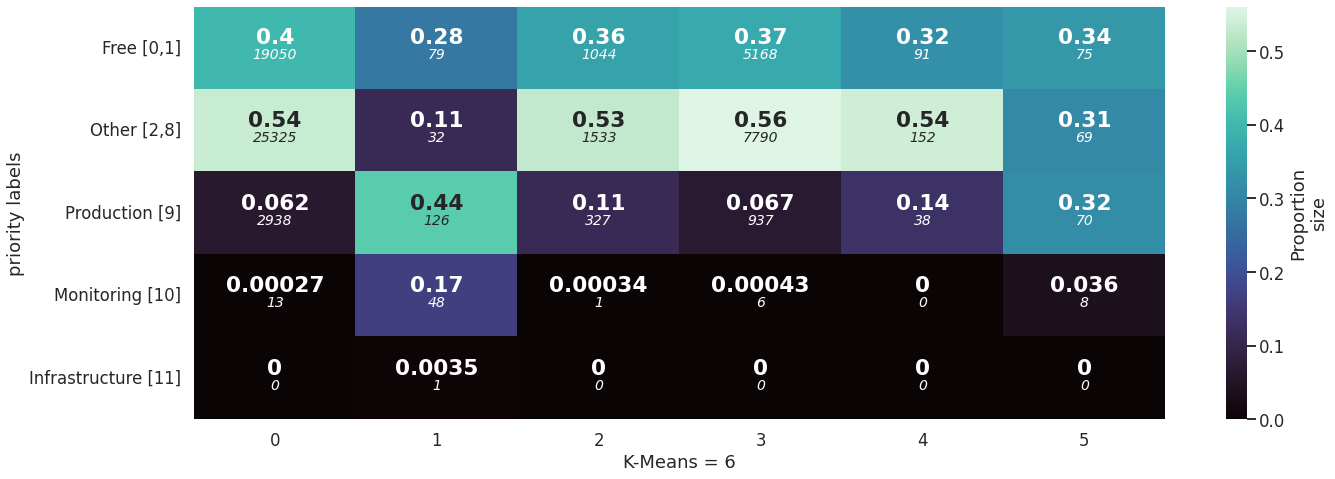

In [863]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 6"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 6", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 6", "priority count")

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k6.svg')

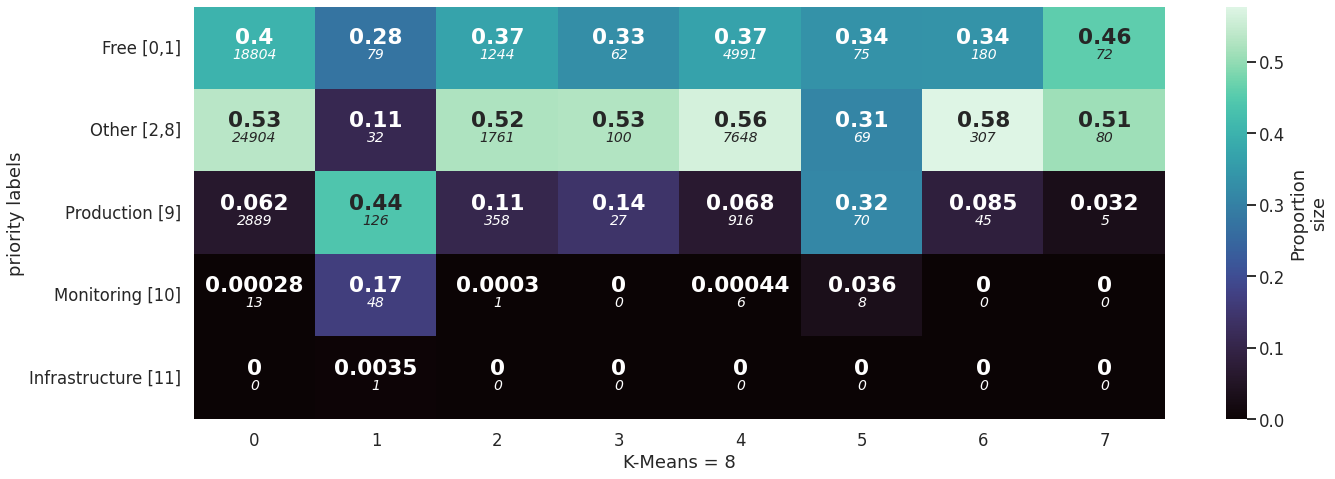

In [879]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 8"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 8", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values


#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 8", "priority count")

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k8.svg')

#### Priority overall

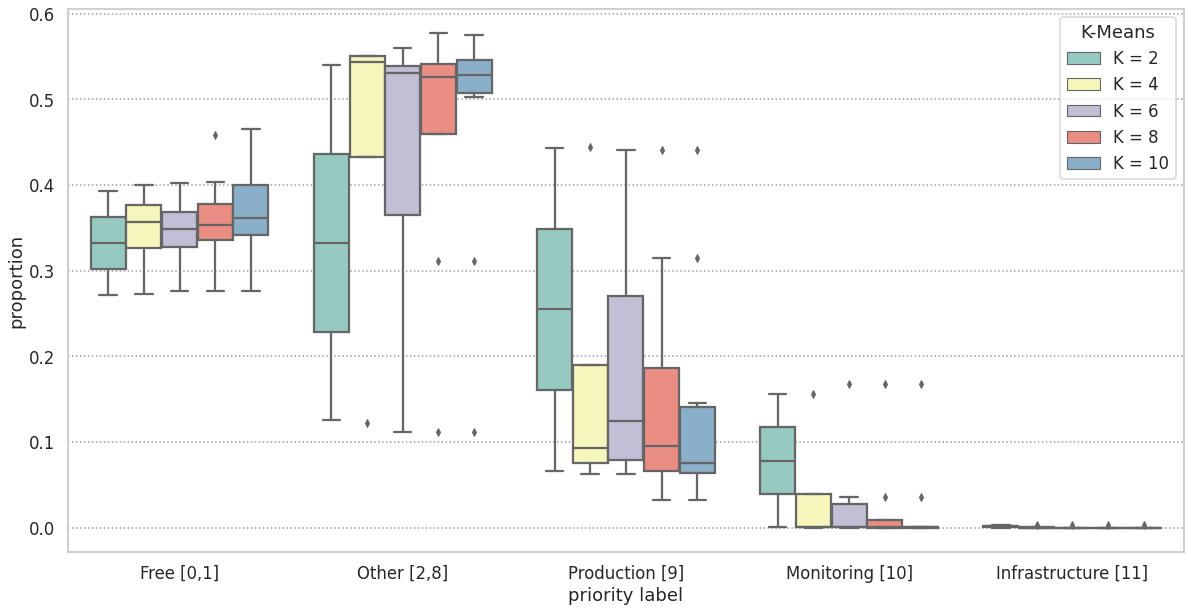

In [899]:
heatmap_df = static_metrics.groupby(["priority labels", "K-Means = 10"])["priority labels"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]


heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 10", "priority count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc.columns = ["priority label", "K-Means", "proportion"]
heatmap_df_perc["K-Means"] = "K = 10"
heatmap_df_final = heatmap_df_perc.copy()

for k in range(2, 10, 2):
    heatmap_df = static_metrics.groupby(["priority labels", f"K-Means = {k}"])["priority labels"].count()
    heatmap_df = heatmap_df.to_frame()
    heatmap_df.columns = ["priority count"]


    heatmap_df_total = heatmap_df.reset_index()
    heatmap_df_total = heatmap_df_total.pivot("priority labels", f"K-Means = {k}", "priority count")
    #heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

    #plt.figure(figsize=(20,7))
    #sns.heatmap(heatmap_df_total, annot=True, fmt="d")
    #
    heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
    heatmap_df_perc = heatmap_df_perc.reset_index()
    heatmap_df_perc.columns = ["priority label", "K-Means", "proportion"]
    heatmap_df_perc["K-Means"] = f"K = {k}"
    heatmap_df_final = heatmap_df_final.append(heatmap_df_perc)
    
heatmap_df_final
heatmap_df_final["K-Means"] = pd.Categorical(heatmap_df_final['K-Means'], categories=[f"K = {k}" for k in range(2, 12, 2)])

plt.figure(figsize=(20,10))
sns.boxplot(x="priority label", y="proportion", hue="K-Means", data=heatmap_df_final, palette="Set3")
plt.savefig('figures/2021-11-28-presentation/priority_labels_boxplot-sum.svg')

### CPU resource requested

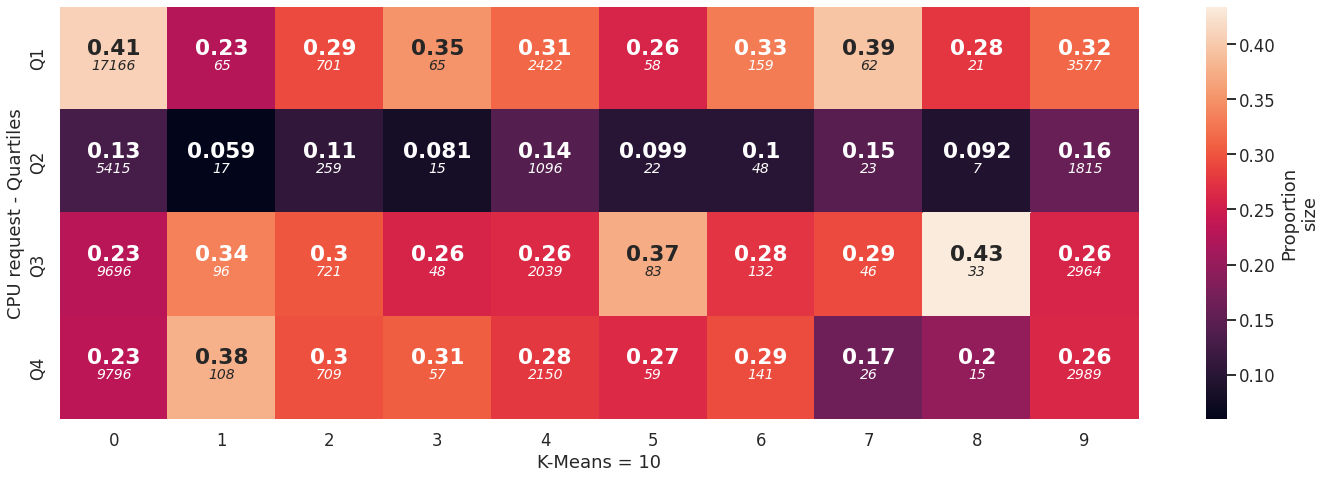

In [929]:
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", "K-Means = 10"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", "K-Means = 10", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/cpu_requests_heatmap_k10.svg')

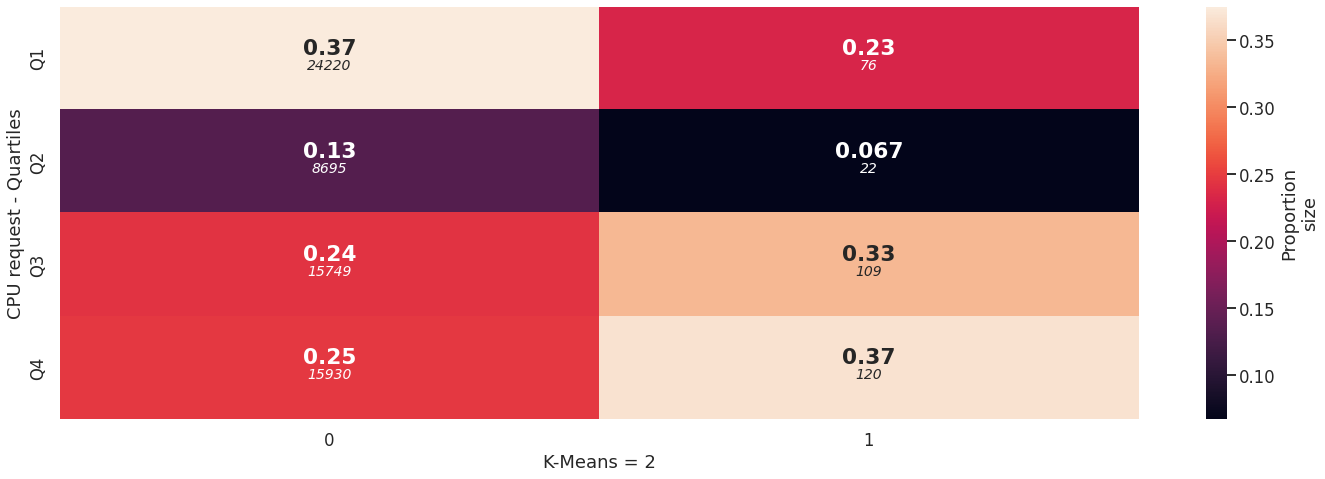

In [932]:
k=2
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

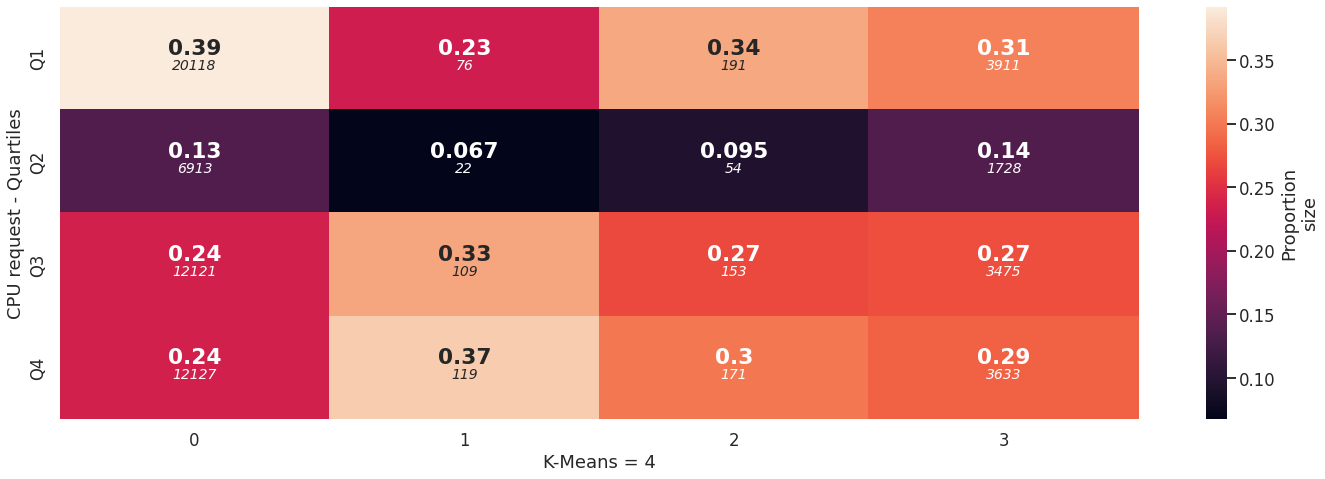

In [933]:
k=4
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

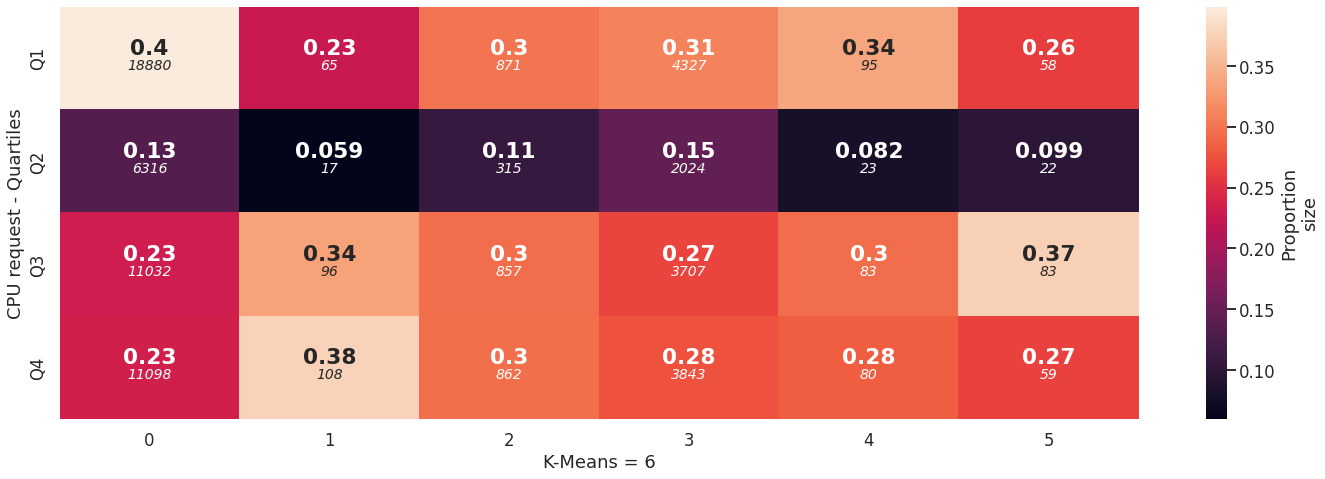

In [934]:
k=6
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

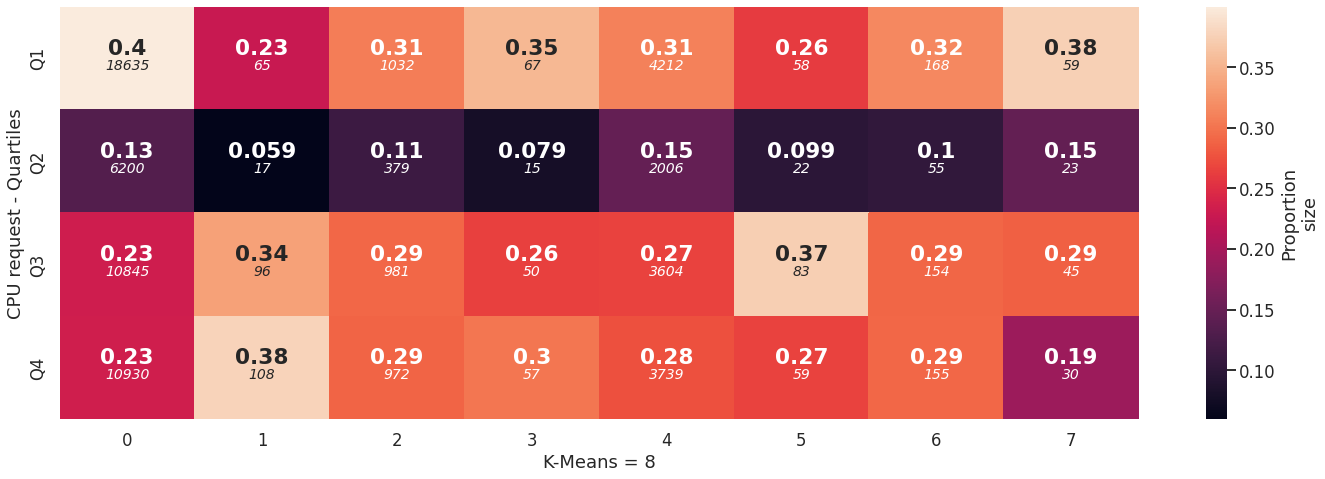

In [935]:
k=8
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

#### CPU request overall

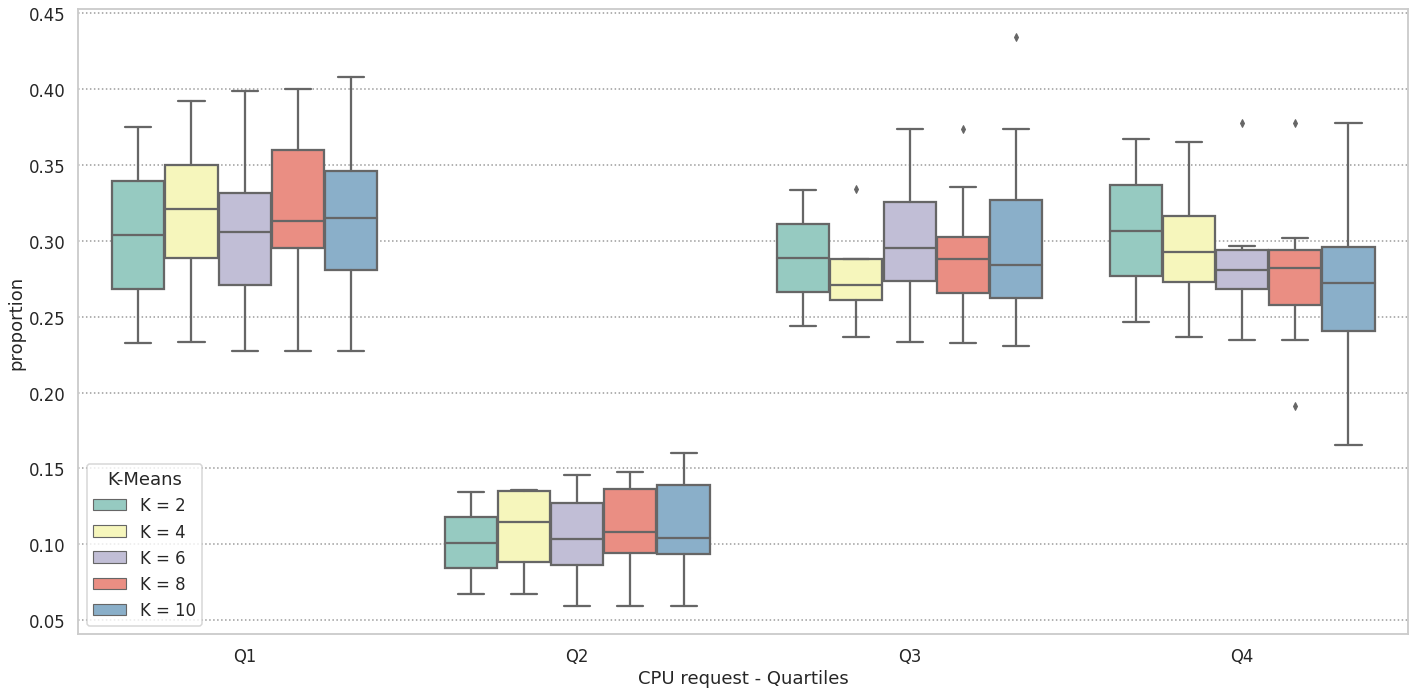

In [938]:
heatmap_df = static_metrics.groupby(["CPU request - Quartiles", "K-Means = 10"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]


heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc.columns = ["CPU request - Quartiles", "K-Means", "proportion"]
heatmap_df_perc["K-Means"] = "K = 10"
heatmap_df_final = heatmap_df_perc.copy()

for k in range(2, 10, 2):
    heatmap_df = static_metrics.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
    heatmap_df = heatmap_df.to_frame()
    heatmap_df.columns = ["quartiles count"]


    heatmap_df_total = heatmap_df.reset_index()
    heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count")
    #heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

    #plt.figure(figsize=(20,7))
    #sns.heatmap(heatmap_df_total, annot=True, fmt="d")
    #
    heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
    heatmap_df_perc = heatmap_df_perc.reset_index()
    heatmap_df_perc.columns = ["CPU request - Quartiles", "K-Means", "proportion"]
    heatmap_df_perc["K-Means"] = f"K = {k}"
    heatmap_df_final = heatmap_df_final.append(heatmap_df_perc)
    
heatmap_df_final
heatmap_df_final["K-Means"] = pd.Categorical(heatmap_df_final['K-Means'], categories=[f"K = {k}" for k in range(2, 12, 2)])

plt.figure(figsize=(20,10))
sns.boxplot(x="CPU request - Quartiles", y="proportion", hue="K-Means", data=heatmap_df_final, palette="Set3")
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/cpu_requests_boxplot-sum.svg')

### memory resource requested

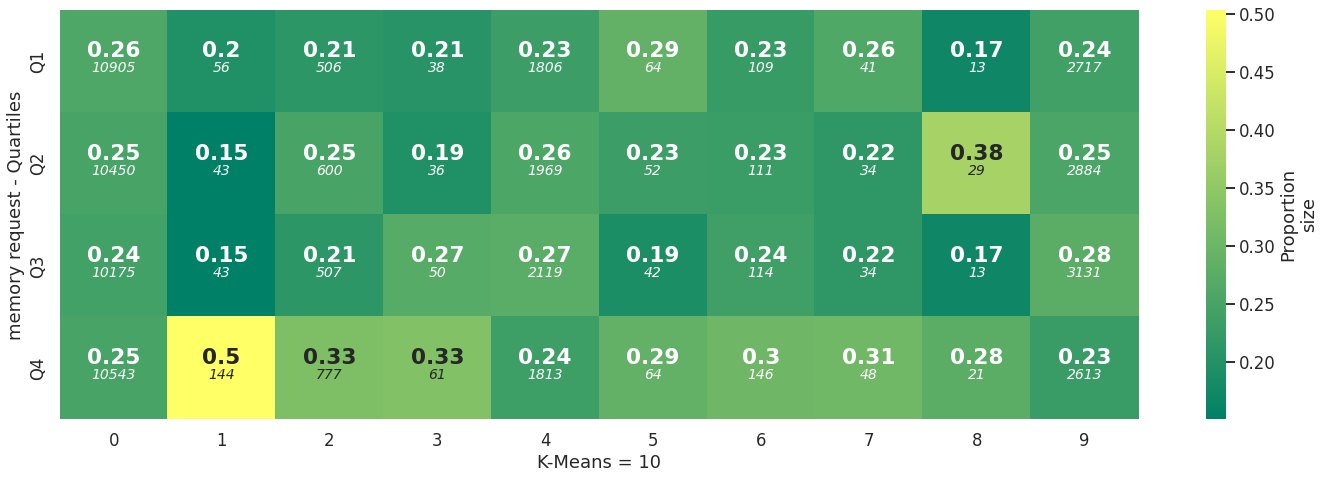

In [1043]:
heatmap_df = static_metrics.groupby(["memory request - Quartiles", "K-Means = 10"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", "K-Means = 10", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/memory_requests_heatmap_k10.svg')

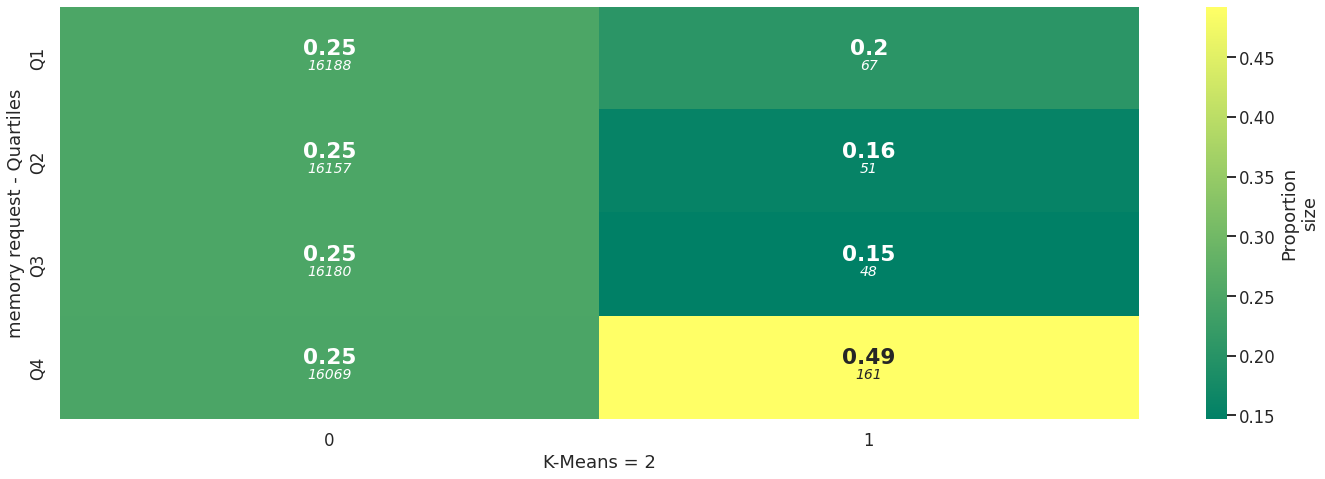

In [1047]:
k=2
heatmap_df = static_metrics.groupby(["memory request - Quartiles", f"K-Means = {k}"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/memory_requests_heatmap_k{k}.svg')

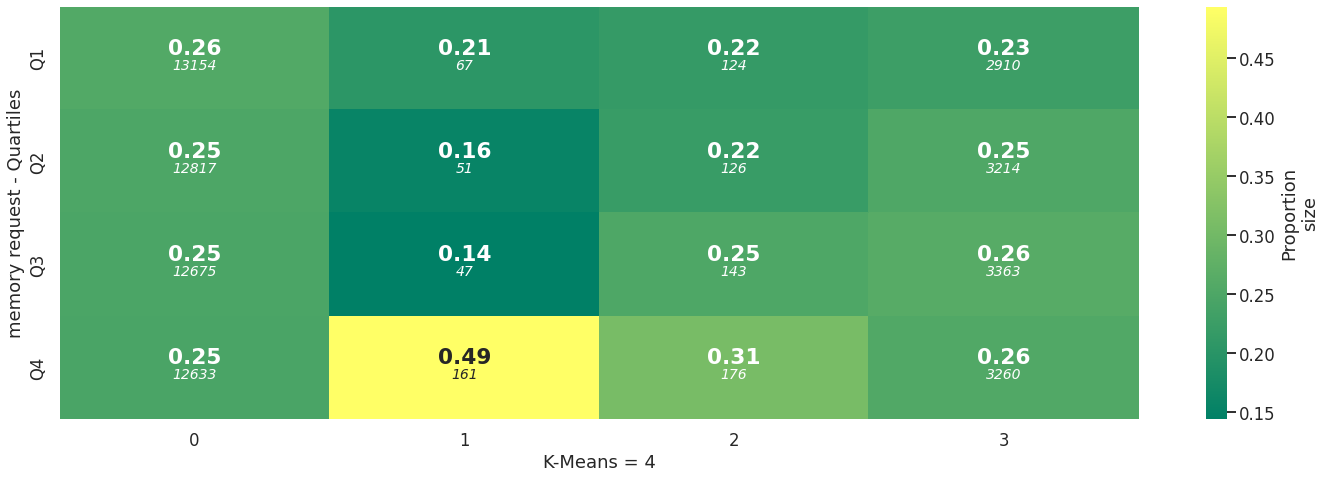

In [1048]:
k=4
heatmap_df = static_metrics.groupby(["memory request - Quartiles", f"K-Means = {k}"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/memory_requests_heatmap_k{k}.svg')

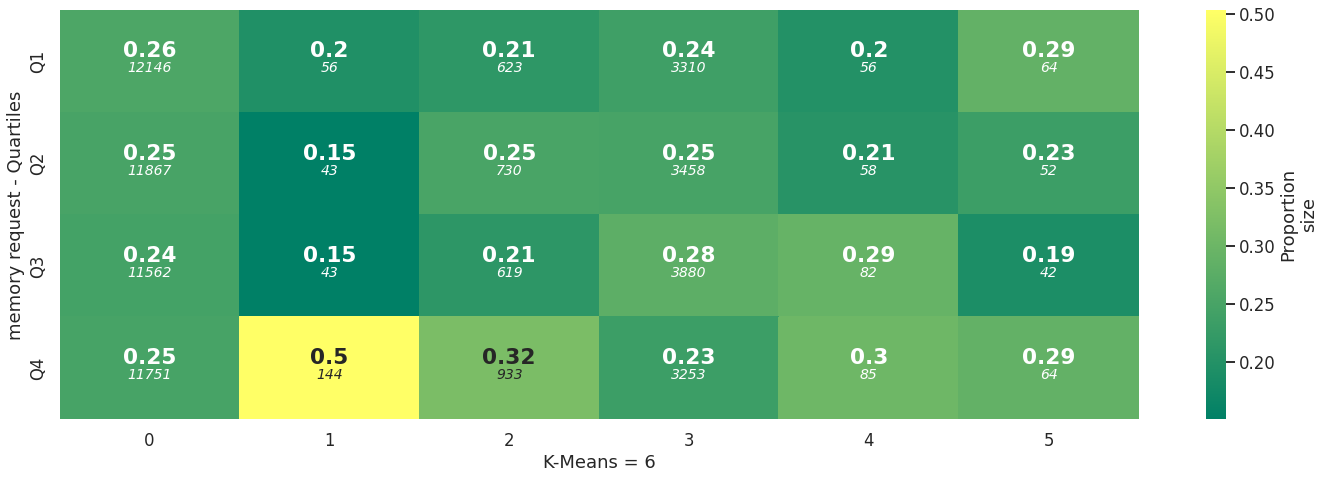

In [1049]:
k=6
heatmap_df = static_metrics.groupby(["memory request - Quartiles", f"K-Means = {k}"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/memory_requests_heatmap_k{k}.svg')

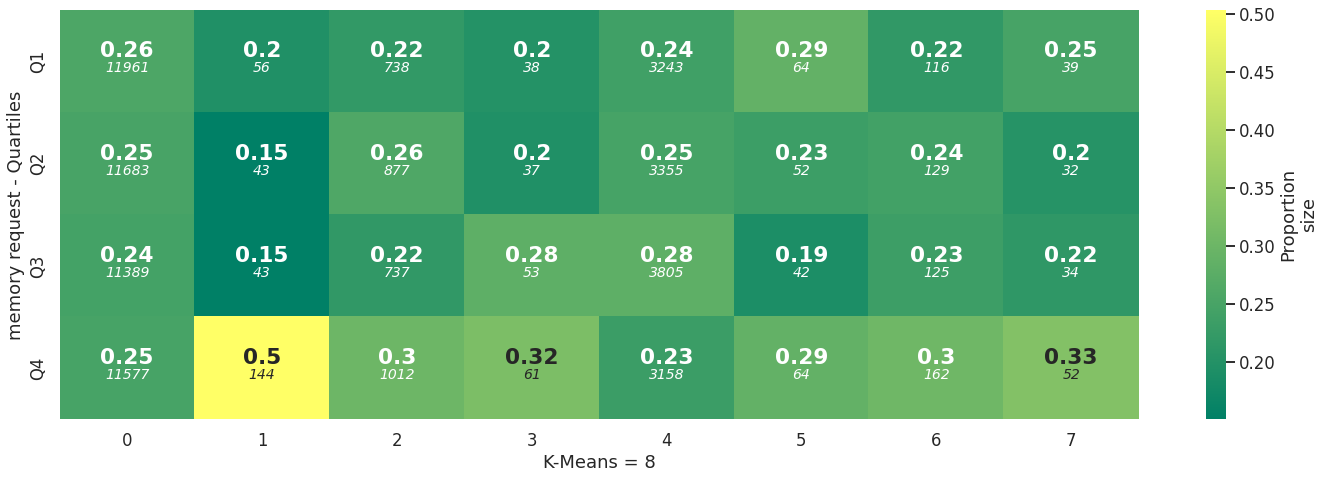

In [1050]:
k=8
heatmap_df = static_metrics.groupby(["memory request - Quartiles", f"K-Means = {k}"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/memory_requests_heatmap_k{k}.svg')

#### memory request overall

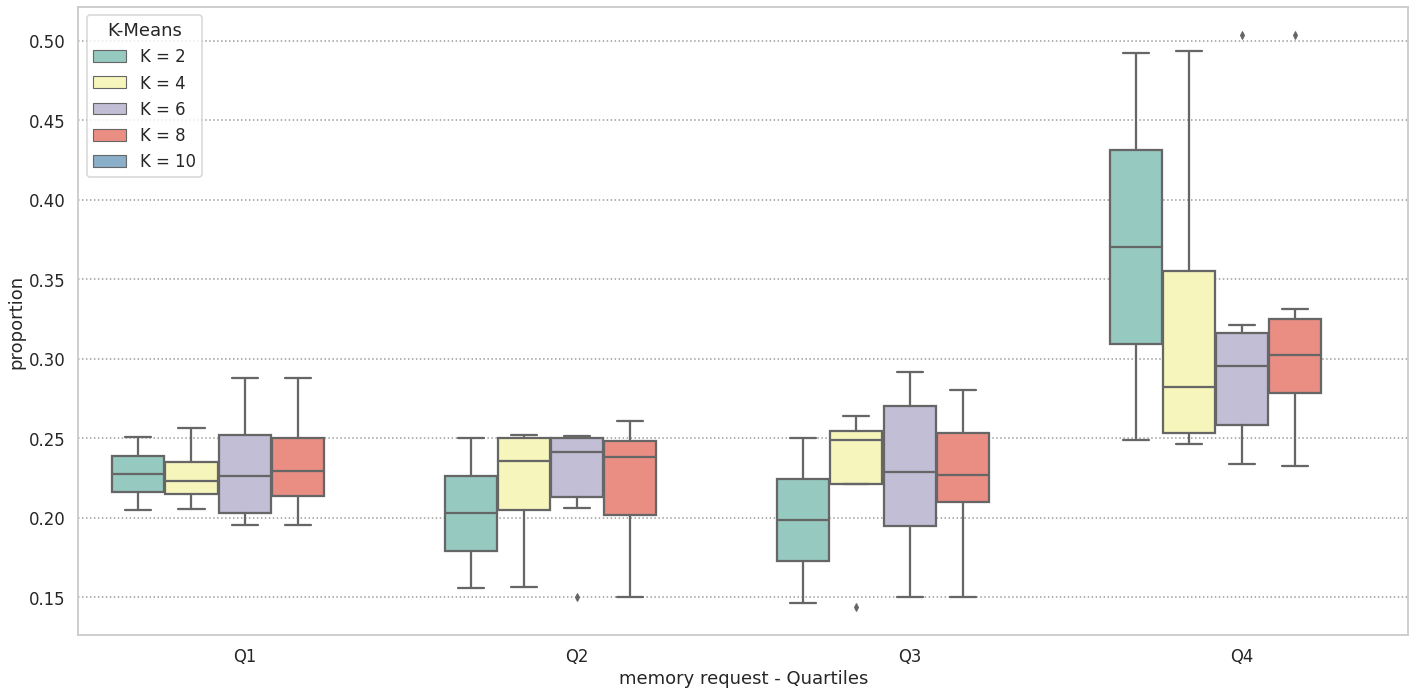

In [1052]:
heatmap_df = static_metrics.groupby(["memory request - Quartiles", "K-Means = 10"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]


heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc.columns = ["CPU request - Quartiles", "K-Means", "proportion"]
heatmap_df_perc["K-Means"] = "K = 10"
heatmap_df_final = heatmap_df_perc.copy()

for k in range(2, 10, 2):
    heatmap_df = static_metrics.groupby(["memory request - Quartiles", f"K-Means = {k}"])["memory request - Quartiles"].count()
    heatmap_df = heatmap_df.to_frame()
    heatmap_df.columns = ["quartiles count"]


    heatmap_df_total = heatmap_df.reset_index()
    heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", f"K-Means = {k}", "quartiles count")
    #heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

    #plt.figure(figsize=(20,7))
    #sns.heatmap(heatmap_df_total, annot=True, fmt="d")
    #
    heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
    heatmap_df_perc = heatmap_df_perc.reset_index()
    heatmap_df_perc.columns = ["memory request - Quartiles", "K-Means", "proportion"]
    heatmap_df_perc["K-Means"] = f"K = {k}"
    heatmap_df_final = heatmap_df_final.append(heatmap_df_perc)
    
heatmap_df_final
heatmap_df_final["K-Means"] = pd.Categorical(heatmap_df_final['K-Means'], categories=[f"K = {k}" for k in range(2, 12, 2)])

plt.figure(figsize=(20,10))
sns.boxplot(x="memory request - Quartiles", y="proportion", hue="K-Means", data=heatmap_df_final, palette="Set3")
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/memory_requests_boxplot-sum.svg')

### disk space resource requested

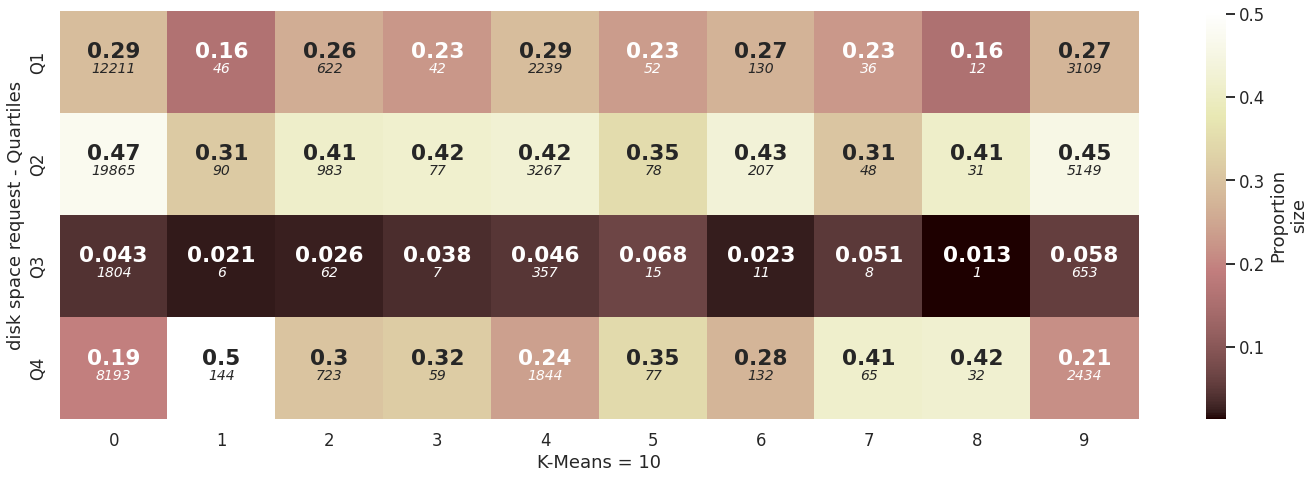

In [1058]:
target_metric="disk space request - Quartiles"

heatmap_df = static_metrics.groupby([target_metric, "K-Means = 10"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, "K-Means = 10", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="pink", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="pink", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/disk_requests_heatmap_k10.svg')

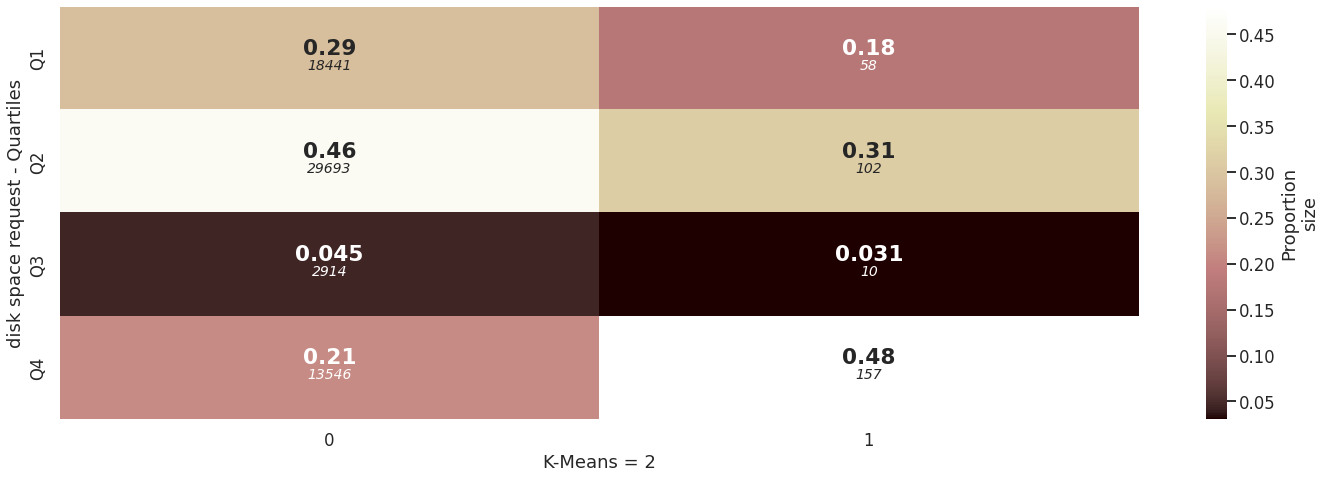

In [1059]:
k=2
target_metric="disk space request - Quartiles"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="pink", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="pink", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/disk_requests_heatmap_k{k}.svg')

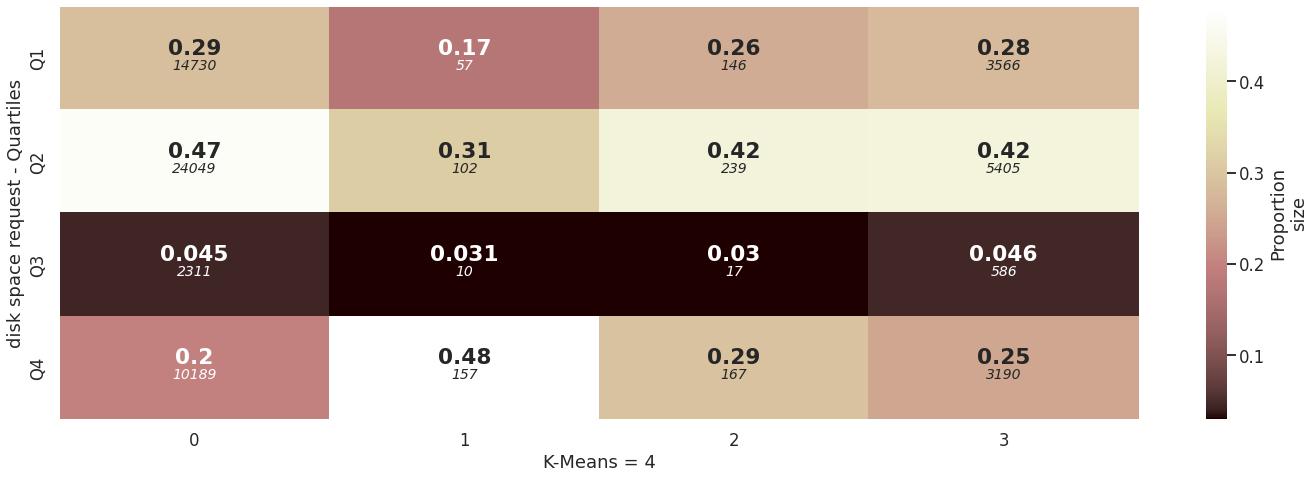

In [1060]:
k=4
target_metric="disk space request - Quartiles"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="pink", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="pink", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/disk_requests_heatmap_k{k}.svg')

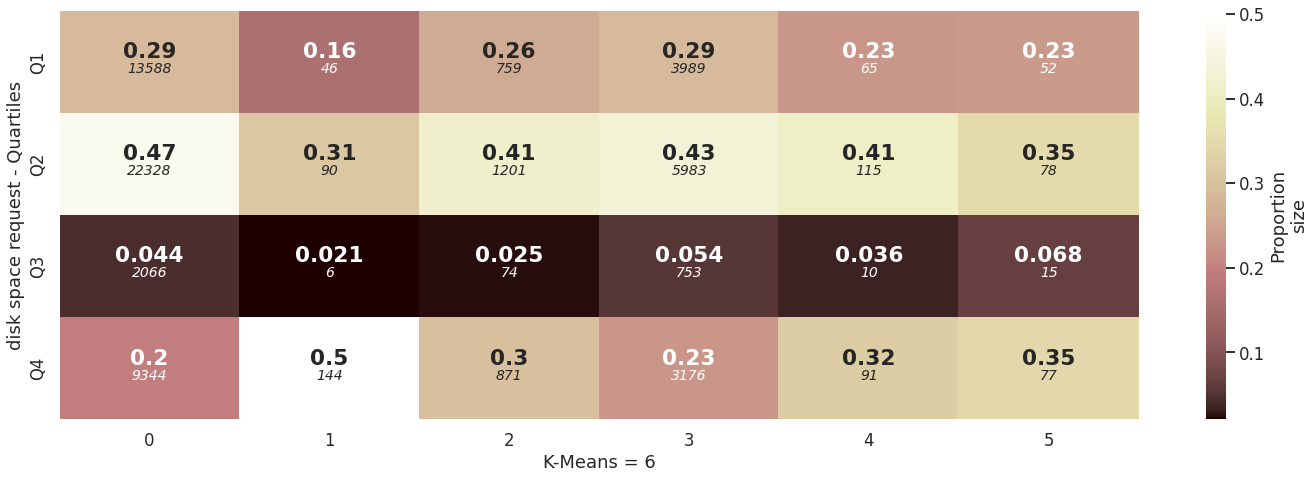

In [1061]:
k=6
target_metric="disk space request - Quartiles"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="pink", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="pink", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/disk_requests_heatmap_k{k}.svg')

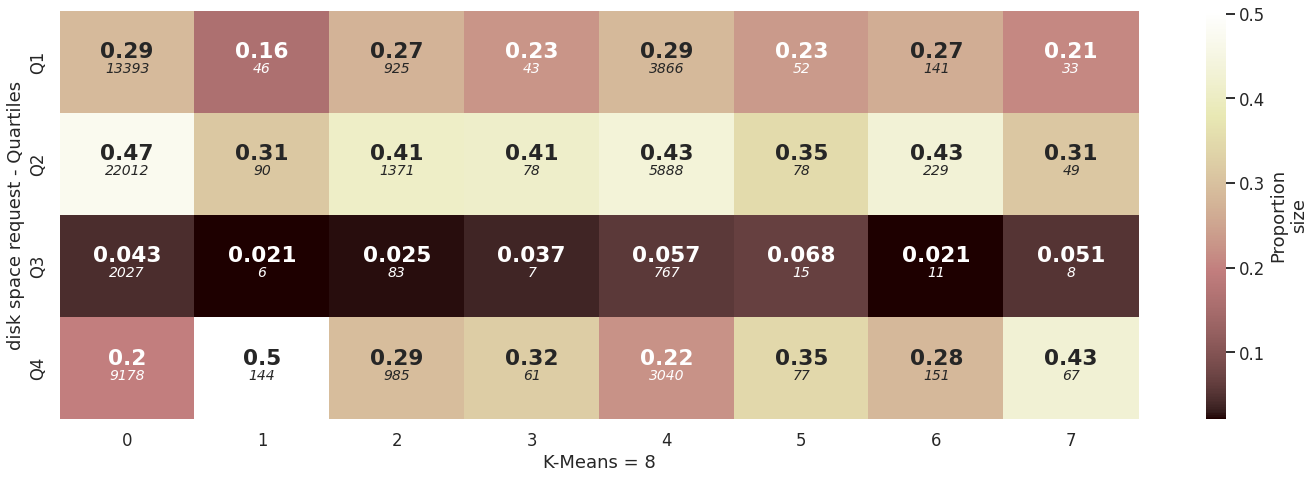

In [1062]:
k=8
target_metric="disk space request - Quartiles"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="pink", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="pink", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/disk_requests_heatmap_k{k}.svg')

#### disk request overall

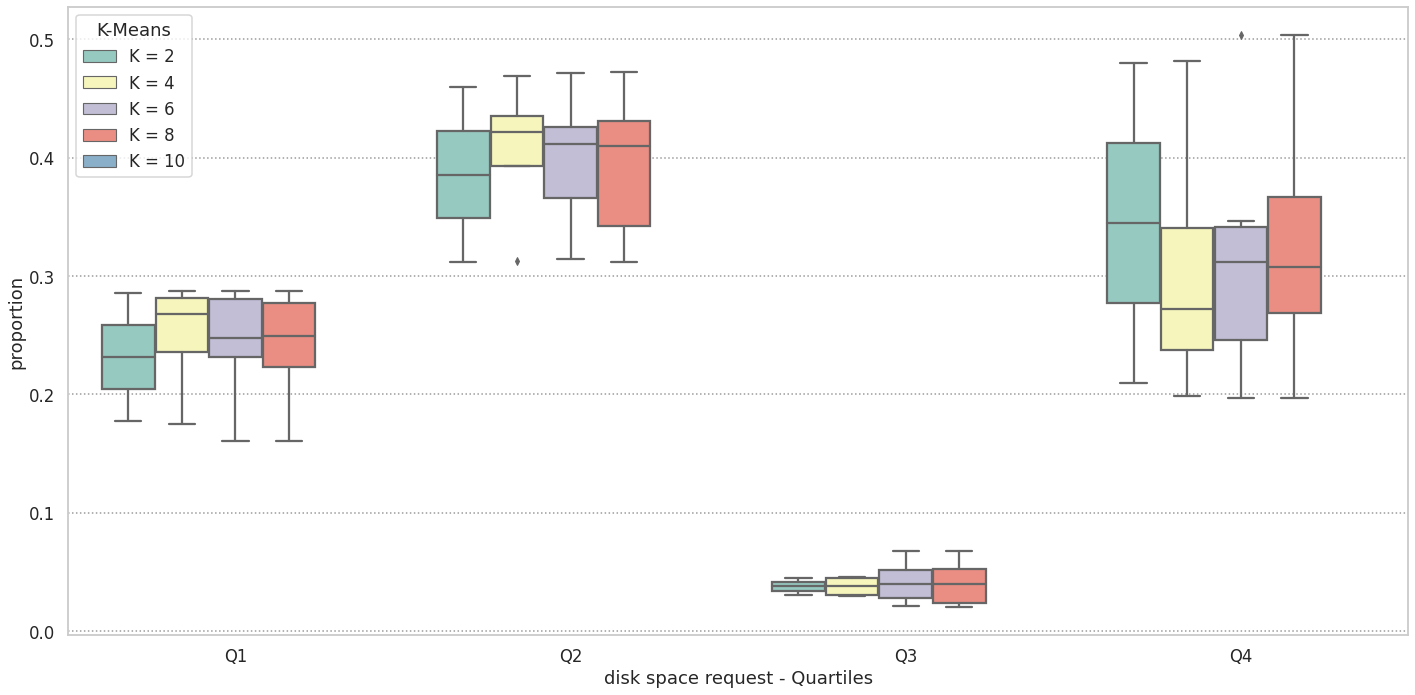

In [1063]:
target_metric="disk space request - Quartiles"


heatmap_df = static_metrics.groupby([target_metric, "K-Means = 10"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]


heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc.columns = ["CPU request - Quartiles", "K-Means", "proportion"]
heatmap_df_perc["K-Means"] = "K = 10"
heatmap_df_final = heatmap_df_perc.copy()

for k in range(2, 10, 2):
    heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
    heatmap_df = heatmap_df.to_frame()
    heatmap_df.columns = ["quartiles count"]


    heatmap_df_total = heatmap_df.reset_index()
    heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
    #heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

    #plt.figure(figsize=(20,7))
    #sns.heatmap(heatmap_df_total, annot=True, fmt="d")
    #
    heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
    heatmap_df_perc = heatmap_df_perc.reset_index()
    heatmap_df_perc.columns = [target_metric, "K-Means", "proportion"]
    heatmap_df_perc["K-Means"] = f"K = {k}"
    heatmap_df_final = heatmap_df_final.append(heatmap_df_perc)
    
heatmap_df_final
heatmap_df_final["K-Means"] = pd.Categorical(heatmap_df_final['K-Means'], categories=[f"K = {k}" for k in range(2, 12, 2)])

plt.figure(figsize=(20,10))
sns.boxplot(x=target_metric, y="proportion", hue="K-Means", data=heatmap_df_final, palette="Set3")
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/disk_requests_boxplot-sum.svg')

### Scheduling class resource requested

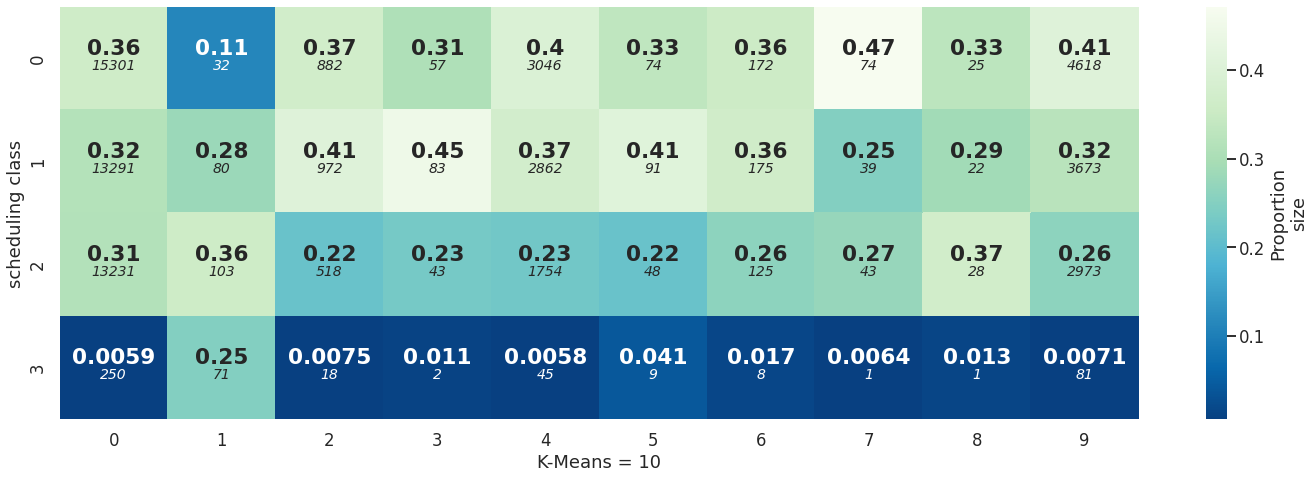

In [1076]:
target_metric="scheduling class"

heatmap_df = static_metrics.groupby([target_metric, "K-Means = 10"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total
heatmap_df_total = heatmap_df_total.pivot(target_metric, "K-Means = 10", "quartiles count")
heatmap_df_total

heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])
#
heatmap_df_perc = heatmap_df_perc.pivot(target_metric, "K-Means = 10", "quartiles count")
#
#
plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/schedclass_heatmap_k10.svg')

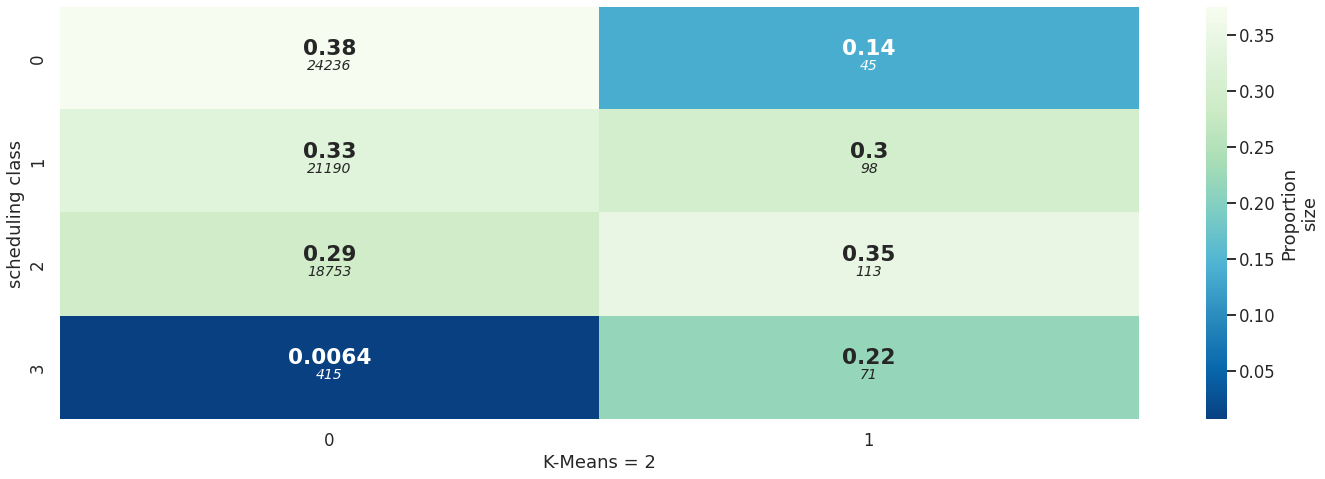

In [1077]:
k=2
target_metric="scheduling class"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

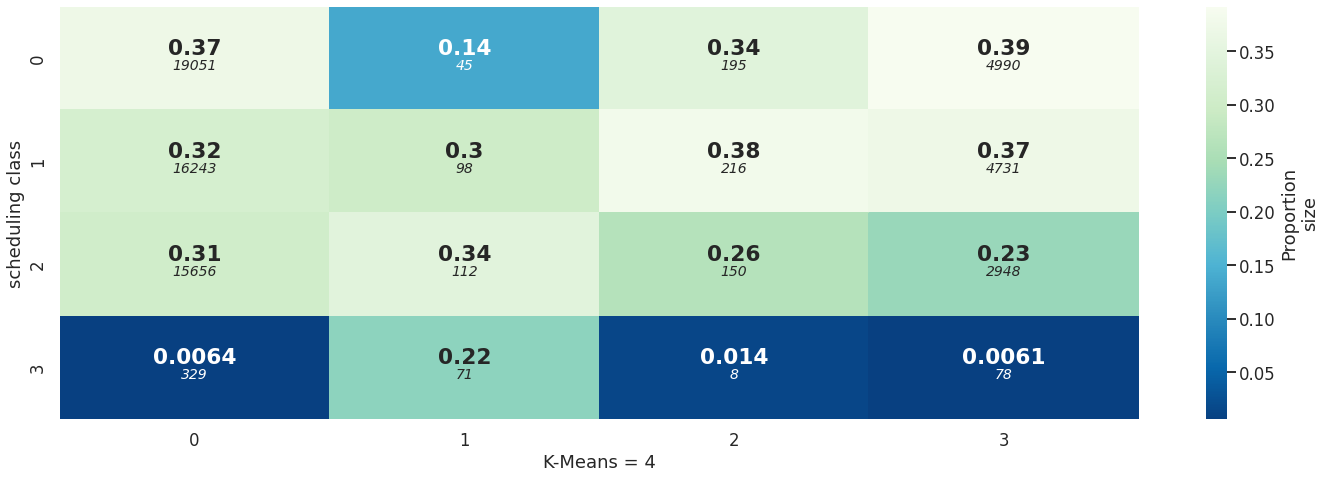

In [1078]:
k=4
target_metric="scheduling class"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

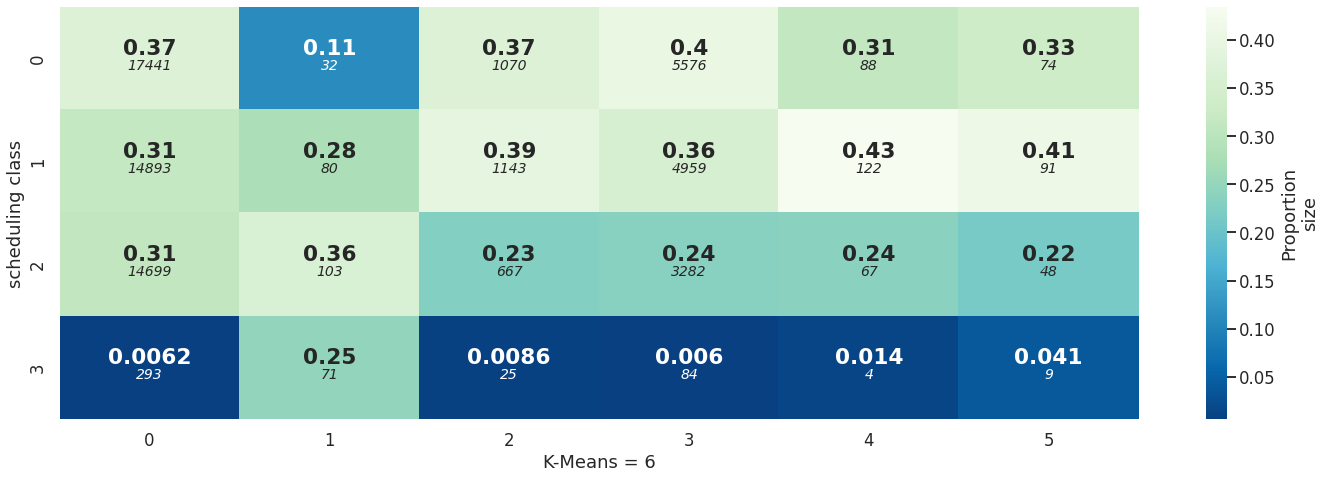

In [1079]:
k=6
target_metric="scheduling class"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

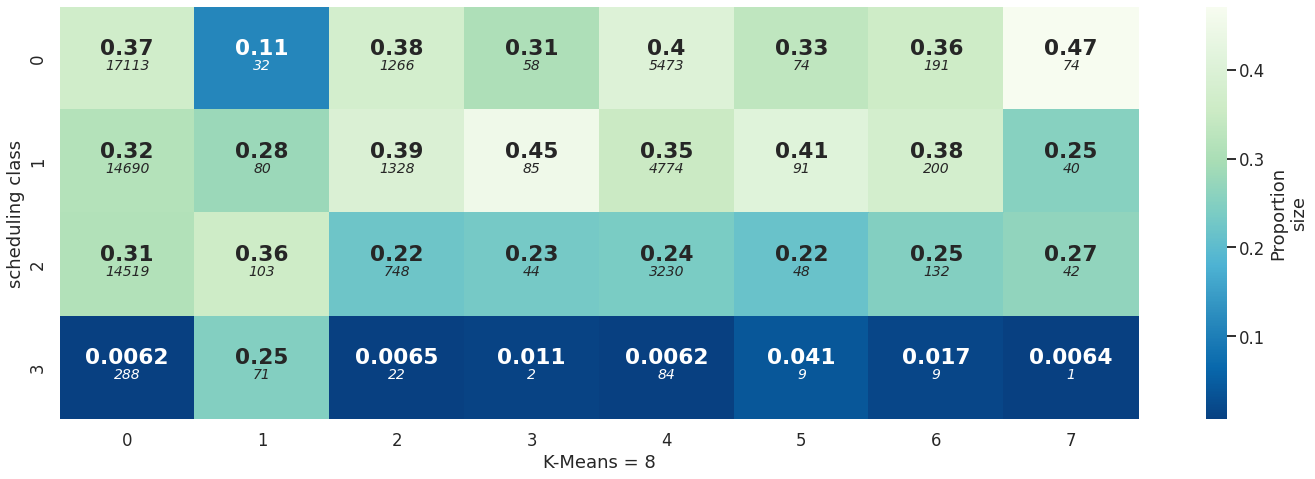

In [1080]:
k=8
target_metric="scheduling class"

heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count")


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

#### scheduling class overall

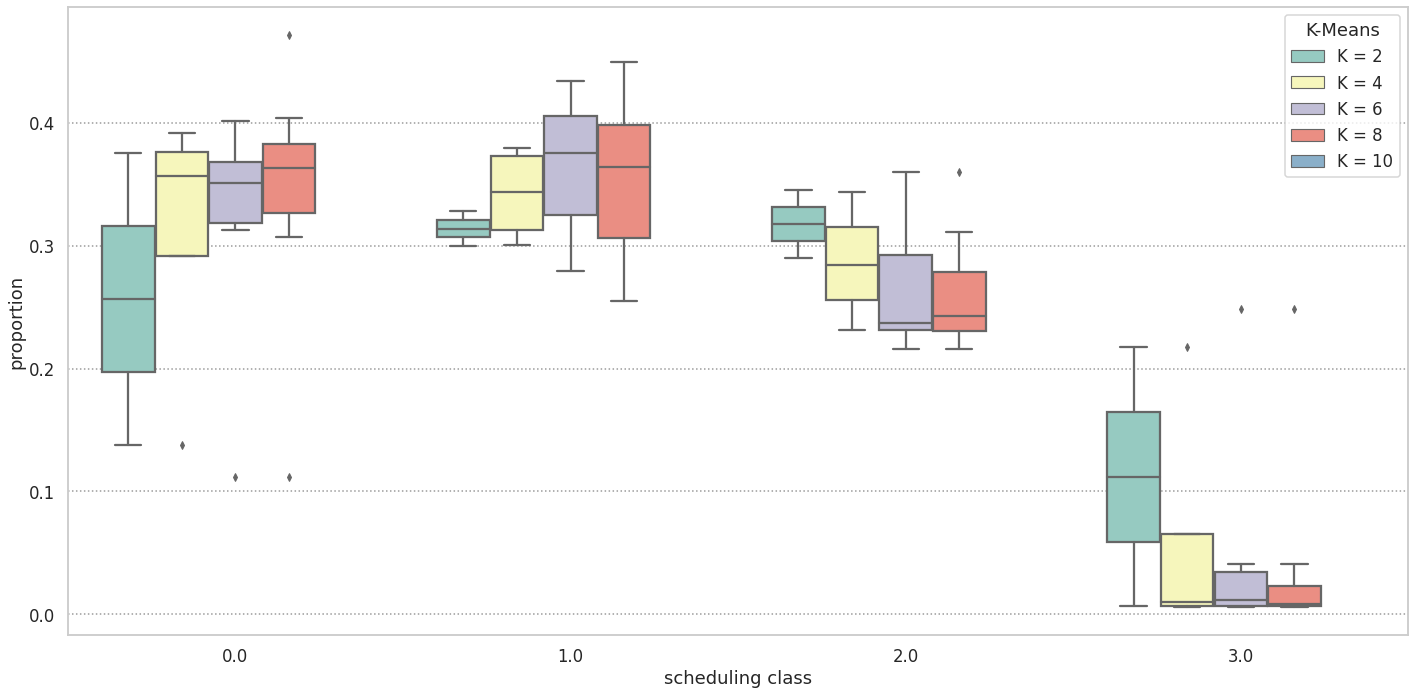

In [1082]:
target_metric="scheduling class"


heatmap_df = static_metrics.groupby([target_metric, "K-Means = 10"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]


heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, "K-Means = 10", "quartiles count")
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc.columns = ["CPU request - Quartiles", "K-Means", "proportion"]
heatmap_df_perc["K-Means"] = "K = 10"
heatmap_df_final = heatmap_df_perc.copy()

for k in range(2, 10, 2):
    heatmap_df = static_metrics.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
    heatmap_df = heatmap_df.to_frame()
    heatmap_df.columns = ["quartiles count"]


    heatmap_df_total = heatmap_df.reset_index()
    heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count")
    #heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

    #plt.figure(figsize=(20,7))
    #sns.heatmap(heatmap_df_total, annot=True, fmt="d")
    #
    heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
    heatmap_df_perc = heatmap_df_perc.reset_index()
    heatmap_df_perc.columns = [target_metric, "K-Means", "proportion"]
    heatmap_df_perc["K-Means"] = f"K = {k}"
    heatmap_df_final = heatmap_df_final.append(heatmap_df_perc)
    
heatmap_df_final
heatmap_df_final["K-Means"] = pd.Categorical(heatmap_df_final['K-Means'], categories=[f"K = {k}" for k in range(2, 12, 2)])

plt.figure(figsize=(20,10))
sns.boxplot(x=target_metric, y="proportion", hue="K-Means", data=heatmap_df_final, palette="Set3")
plt.tight_layout()
plt.savefig('figures/2021-11-28-presentation/schedclass_boxplot-sum.svg')